In [16]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time
from numpy import linalg as LA
from scipy.linalg import hadamard, subspace_angles
from numpy.linalg import matrix_rank
import math

In [17]:
# Define functions

def gen_syn_data(M, N, dim_lat, nu):
    x = np.zeros((dim_lat + nu, 1))
    rho = 10  # Increasing rho increases excitation for better operator recovery
    Sigma = rho * np.eye(dim_lat + nu) + np.random.rand(dim_lat + nu, dim_lat + nu)
    Sigma_symm = ((1 / 2) * (Sigma + Sigma.T))
    Sigma_symm = ((dim_lat + nu) / np.trace(Sigma_symm)) * Sigma_symm
    X=[]
    Y=[]
    for i in range(N):
        X.append(sqrtm(Sigma_symm).dot(np.random.normal(0, 1, dim_lat + nu))) 
        w = np.random.normal(0, 1, 1)
        Y.append(M.dot(X[i]) + w)

    return X, Y


def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def tasksgen(nx, nu, r, dim_lat, H, scale):
    # True representation
    Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
    Phi = Phi[:r, :]

    F_0 = np.random.randn(1, nu + nx)  # Nominal task weights F
    M_0 = F_0.dot(Phi)  # Nominal operator M

    # Generating different tasks weights
    F = []
    P = []
    for h in range(1, H + 1):
        L = scale * np.random.randn(1, 1)
        F.append(L*F_0)  # Generating the true weights for H different tasks

    M = []
    for h in range(H):
        M.append(F[h].dot(Phi))  # Generating the true operators M for H different tasks
    return M, Phi



def grad_F(F,Phi,j,X,Y,lambda_F,ny,r,sigma):
    
    M = len(F)
    T = len(X)
    
    sum_term = 0
    
    for t in range(T):
        Phi_term = np.zeros([ny,r])
        Phi_term[j,:] = np.dot(Phi,X[t]).T
        
        sum_term = sum_term + (1/(sigma**2))*np.dot((Y[t] - np.dot(np.dot(F,Phi),X[t])).T,Phi_term)
    
    grad_weight = -(F[:,j])/(lambda_F**2) + sum_term
    
    return grad_weight


def grad_Phi(F,Phi,j,Xc,Yc,lambda_Phi,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M): 
        for t in range(T):
            X = np.zeros([Xc[i][t].shape[0],1])
            X[:,0] = Xc[i][t]
            sum_term = sum_term + (1/(sigma**2))*np.dot(F[i].T,Yc[i][t]-np.dot(np.dot(F[i],Phi),X))*X[j,0]
    
    grad_phi = np.zeros([r,1])
    grad_phi[:,0] = Phi[:,j]      
    grad_phi=-grad_phi/(lambda_phi**2) + sum_term
    return grad_phi

def log_joint(F,Phi,Yc,Xc,lambda_phi,lambda_F,nx,ny,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M):
        for t in range(T):
            X = np.zeros([Xc[i][t].shape[0],1])
            X[:,0] = Xc[i][t]
            sum_term = sum_term  - (1/2*(sigma**2))*(Yc[i][t] - np.dot(np.dot(F[i],Phi),X))**2
        
        sum_term = sum_term -(LA.norm(F[i], 2)**2)/(2*(lambda_F)**2)
    
    for j in range(nx):
        sum_term = sum_term - (1/2)*(lambda_phi**2)*(LA.norm(Phi_hat[:,j], 2)**2)
    
    return sum_term[0][0]



def CAMAP(Phi_hat, F, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi, sigma, X, Y):
    

    r = nx + nu

    Error_rep = []
    Log_joint_iter = []
    
    for k in range(K):
        start_time = time.time()
        
        # Calculating subspace distance
        Error_rep.append(subspace_distance(Phi_true, Phi_hat))
        if math.isnan(Error_rep[k]):
            break 
        
       
        Xc=[]
        Yc=[]
        
        for h in range(H): # For all tasks do
           
            for j in range(ny):
                F[h][:] = F[h][:] + eta_F*grad_F(F[h],Phi_hat,int(j),X[h],Y[h],lambda_F,ny,r,sigma)
                
        for j in range(nx):
            Phi_hat[:,j] = Phi_hat[:,j] + (eta_phi)*grad_Phi(F,Phi_hat,int(j),X,Y,lambda_phi,sigma)[:,0]
        
        eta_phi = eta_phi/1.001
        
        
        Log_joint_iter.append(log_joint(F,Phi_hat,Y,X,lambda_phi,lambda_F,nx,ny,sigma))

        
        end_time = time.time()
        print(f"Iteration: {k}, Subspace Dist: {Error_rep[k]}, Time: {end_time - start_time}")
        
    return Error_rep, Log_joint_iter, Phi_hat, F


$\textbf{System Parameter:}$

In [18]:
# System dimensions
nx = 5
nu = 2
r = nx + nu  # rank
dim_lat = 50  # dimension of the latent space
H = 20 # number of tasks
scale = 0.001  # scale of rotation
N = 100
lambda_F = 1


M, Phi_true = tasksgen(nx, nu, r, dim_lat, H, scale)

np.save('seed', {"M_list": M, "Phi_true": Phi_true})

#Initializing the representation
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)

ny = 1 #Linear regression
    
F = []
for h in range(H):
    F_i = np.zeros([ny,r])
    for i in range(ny):
        for j in range(r):
            F_i[i,j] = np.random.normal(loc=0, scale=lambda_F)
    F.append(F_i)

X = []
Y = []
for h in range(H):
    [X_h,Y_h] = gen_syn_data(M[h], N, dim_lat, nu)
    X.append(X_h)
    Y.append(Y_h)

$\textbf{Coordinate Ascent MAP Estimation:}$

In [38]:
K = 5000 # number of global iterations
N = 100  # number of samples

lambda_phi = 10
sigma = 0.15

eta_F = 0.00001
eta_phi = 0.00024

Phi_hat = Phi_true.dot(rot)

$\textbf{Single task}\;\ (M = 1)$

In [41]:
H = 1
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_1, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.452562688404641, Time: 0.004986763000488281
Iteration: 1, Subspace Dist: 2.4524261325333567, Time: 0.003023862838745117
Iteration: 2, Subspace Dist: 2.4522929916280756, Time: 0.001964569091796875
Iteration: 3, Subspace Dist: 2.452163034588638, Time: 0.0009970664978027344
Iteration: 4, Subspace Dist: 2.4520360409916506, Time: 0.002783536911010742
Iteration: 5, Subspace Dist: 2.451911800992137, Time: 0.0029916763305664062
Iteration: 6, Subspace Dist: 2.451790115155621, Time: 0.004717111587524414
Iteration: 7, Subspace Dist: 2.4516707942351674, Time: 0.003016948699951172
Iteration: 8, Subspace Dist: 2.451553658905608, Time: 0.001960277557373047
Iteration: 9, Subspace Dist: 2.4514385394652027, Time: 0.003989219665527344
Iteration: 10, Subspace Dist: 2.451325275513334, Time: 0.002992868423461914
Iteration: 11, Subspace Dist: 2.4512137156114053, Time: 0.003989458084106445
Iteration: 12, Subspace Dist: 2.4511037169328964, Time: 0.002025604248046875
Iteration: 13

Iteration: 205, Subspace Dist: 2.429197715844257, Time: 0.002990245819091797
Iteration: 206, Subspace Dist: 2.429078846204667, Time: 0.0029938220977783203
Iteration: 207, Subspace Dist: 2.4289600378370437, Time: 0.001994609832763672
Iteration: 208, Subspace Dist: 2.428841291447298, Time: 0.001993417739868164
Iteration: 209, Subspace Dist: 2.4287226077281656, Time: 0.0029926300048828125
Iteration: 210, Subspace Dist: 2.428603987359477, Time: 0.0029935836791992188
Iteration: 211, Subspace Dist: 2.428485431008422, Time: 0.003015756607055664
Iteration: 212, Subspace Dist: 2.428366939329808, Time: 0.0019683837890625
Iteration: 213, Subspace Dist: 2.428248512966313, Time: 0.0020308494567871094
Iteration: 214, Subspace Dist: 2.428130152548733, Time: 0.0019872188568115234
Iteration: 215, Subspace Dist: 2.428011858696226, Time: 0.0010001659393310547
Iteration: 216, Subspace Dist: 2.4278936320165445, Time: 0.0009999275207519531
Iteration: 217, Subspace Dist: 2.427775473106275, Time: 0.0010266304

Iteration: 319, Subspace Dist: 2.416151015026104, Time: 0.0050199031829833984
Iteration: 320, Subspace Dist: 2.416041697108173, Time: 0.002959728240966797
Iteration: 321, Subspace Dist: 2.4159324748686104, Time: 0.0025234222412109375
Iteration: 322, Subspace Dist: 2.4158233483958185, Time: 0.001996755599975586
Iteration: 323, Subspace Dist: 2.4157143177763287, Time: 0.001996755599975586
Iteration: 324, Subspace Dist: 2.4156053830948263, Time: 0.003008127212524414
Iteration: 325, Subspace Dist: 2.415496544434173, Time: 0.0010356903076171875
Iteration: 326, Subspace Dist: 2.4153878018754305, Time: 0.0020232200622558594
Iteration: 327, Subspace Dist: 2.4152791554978807, Time: 0.0009963512420654297
Iteration: 328, Subspace Dist: 2.415170605379051, Time: 0.001995086669921875
Iteration: 329, Subspace Dist: 2.415062151594734, Time: 0.0009989738464355469
Iteration: 330, Subspace Dist: 2.414953794219008, Time: 0.0009961128234863281
Iteration: 331, Subspace Dist: 2.41484553332426, Time: 0.001963

Iteration: 431, Subspace Dist: 2.4045131163070304, Time: 0.001994609832763672
Iteration: 432, Subspace Dist: 2.4044147452258358, Time: 0.001995563507080078
Iteration: 433, Subspace Dist: 2.4043164717836025, Time: 0.0030241012573242188
Iteration: 434, Subspace Dist: 2.404218295949205, Time: 0.0029604434967041016
Iteration: 435, Subspace Dist: 2.404120217690952, Time: 0.0029931068420410156
Iteration: 436, Subspace Dist: 2.4040222369765947, Time: 0.001993417739868164
Iteration: 437, Subspace Dist: 2.40392435377333, Time: 0.0009980201721191406
Iteration: 438, Subspace Dist: 2.4038265680478066, Time: 0.0019941329956054688
Iteration: 439, Subspace Dist: 2.4037288797661307, Time: 0.0009975433349609375
Iteration: 440, Subspace Dist: 2.403631288893871, Time: 0.001994609832763672
Iteration: 441, Subspace Dist: 2.403533795396063, Time: 0.0009970664978027344
Iteration: 442, Subspace Dist: 2.4034363992372176, Time: 0.0019953250885009766
Iteration: 443, Subspace Dist: 2.403339100381321, Time: 0.0009

Iteration: 540, Subspace Dist: 2.3943562485188017, Time: 0.0019969940185546875
Iteration: 541, Subspace Dist: 2.3942682438694742, Time: 0.001992940902709961
Iteration: 542, Subspace Dist: 2.3941803310638825, Time: 0.0029981136322021484
Iteration: 543, Subspace Dist: 2.39409251003334, Time: 0.003989696502685547
Iteration: 544, Subspace Dist: 2.394004780708979, Time: 0.0019941329956054688
Iteration: 545, Subspace Dist: 2.393917143021752, Time: 0.001993894577026367
Iteration: 546, Subspace Dist: 2.393829596902434, Time: 0.0009932518005371094
Iteration: 547, Subspace Dist: 2.3937421422816265, Time: 0.0019941329956054688
Iteration: 548, Subspace Dist: 2.3936547790897564, Time: 0.0009975433349609375
Iteration: 549, Subspace Dist: 2.393567507257081, Time: 0.000997304916381836
Iteration: 550, Subspace Dist: 2.393480326713687, Time: 0.0019948482513427734
Iteration: 551, Subspace Dist: 2.393393237389496, Time: 0.000997304916381836
Iteration: 552, Subspace Dist: 2.3933062392142634, Time: 0.002943

Iteration: 730, Subspace Dist: 2.3792008936380484, Time: 0.002992391586303711
Iteration: 731, Subspace Dist: 2.379128986825859, Time: 0.0019948482513427734
Iteration: 732, Subspace Dist: 2.3790571572509607, Time: 0.001995086669921875
Iteration: 733, Subspace Dist: 2.3789854048345567, Time: 0.002932310104370117
Iteration: 734, Subspace Dist: 2.3789137294978753, Time: 0.002991914749145508
Iteration: 735, Subspace Dist: 2.3788421311621706, Time: 0.003989458084106445
Iteration: 736, Subspace Dist: 2.3787706097487216, Time: 0.004987001419067383
Iteration: 737, Subspace Dist: 2.3786991651788347, Time: 0.0049860477447509766
Iteration: 738, Subspace Dist: 2.3786277973738432, Time: 0.0019958019256591797
Iteration: 739, Subspace Dist: 2.3785565062551064, Time: 0.0039904117584228516
Iteration: 740, Subspace Dist: 2.3784852917440125, Time: 0.0029909610748291016
Iteration: 741, Subspace Dist: 2.3784141537619763, Time: 0.002005338668823242
Iteration: 742, Subspace Dist: 2.378343092230443, Time: 0.00

Iteration: 890, Subspace Dist: 2.3686264291858516, Time: 0.0019943714141845703
Iteration: 891, Subspace Dist: 2.3685659039226263, Time: 0.0009975433349609375
Iteration: 892, Subspace Dist: 2.368505443825295, Time: 0.001994609832763672
Iteration: 893, Subspace Dist: 2.3684450488227764, Time: 0.0010056495666503906
Iteration: 894, Subspace Dist: 2.3683847188440503, Time: 0.001990795135498047
Iteration: 895, Subspace Dist: 2.368324453818159, Time: 0.0029921531677246094
Iteration: 896, Subspace Dist: 2.3682642536742065, Time: 0.000997304916381836
Iteration: 897, Subspace Dist: 2.3682041183413602, Time: 0.00203704833984375
Iteration: 898, Subspace Dist: 2.3681440477488493, Time: 0.0019521713256835938
Iteration: 899, Subspace Dist: 2.3680840418259654, Time: 0.0009999275207519531
Iteration: 900, Subspace Dist: 2.3680241005020637, Time: 0.0019905567169189453
Iteration: 901, Subspace Dist: 2.3679642237065606, Time: 0.0009980201721191406
Iteration: 902, Subspace Dist: 2.3679044113689365, Time: 0.

Iteration: 1098, Subspace Dist: 2.357339852679117, Time: 0.0019931793212890625
Iteration: 1099, Subspace Dist: 2.357291446950872, Time: 0.000997304916381836
Iteration: 1100, Subspace Dist: 2.3572430929967116, Time: 0.0009975433349609375
Iteration: 1101, Subspace Dist: 2.3571947907590385, Time: 0.0009968280792236328
Iteration: 1102, Subspace Dist: 2.357146540180318, Time: 0.0016412734985351562
Iteration: 1103, Subspace Dist: 2.357098341203078, Time: 0.00199127197265625
Iteration: 1104, Subspace Dist: 2.3570501937699118, Time: 0.0009975433349609375
Iteration: 1105, Subspace Dist: 2.3570020978234743, Time: 0.0009975433349609375
Iteration: 1106, Subspace Dist: 2.356954053306483, Time: 0.0023145675659179688
Iteration: 1107, Subspace Dist: 2.3569060601617218, Time: 0.0020265579223632812
Iteration: 1108, Subspace Dist: 2.3568581183320334, Time: 0.0015752315521240234
Iteration: 1109, Subspace Dist: 2.356810227760327, Time: 0.0017752647399902344
Iteration: 1110, Subspace Dist: 2.356762388389573

Iteration: 1210, Subspace Dist: 2.352227499010352, Time: 0.0025610923767089844
Iteration: 1211, Subspace Dist: 2.352184548126549, Time: 0.0009975433349609375
Iteration: 1212, Subspace Dist: 2.3521416429497104, Time: 0.0019943714141845703
Iteration: 1213, Subspace Dist: 2.352098783429053, Time: 0.0009975433349609375
Iteration: 1214, Subspace Dist: 2.352055969513849, Time: 0.0019943714141845703
Iteration: 1215, Subspace Dist: 2.3520132011534316, Time: 0.0009975433349609375
Iteration: 1216, Subspace Dist: 2.351970478297189, Time: 0.0039920806884765625
Iteration: 1217, Subspace Dist: 2.3519278008945683, Time: 0.0019931793212890625
Iteration: 1218, Subspace Dist: 2.351885168895074, Time: 0.0019948482513427734
Iteration: 1219, Subspace Dist: 2.35184258224827, Time: 0.0009965896606445312
Iteration: 1220, Subspace Dist: 2.351800040903776, Time: 0.0020265579223632812
Iteration: 1221, Subspace Dist: 2.351757544811269, Time: 0.001909017562866211
Iteration: 1222, Subspace Dist: 2.351715093920485, 

Iteration: 1363, Subspace Dist: 2.3461590074246956, Time: 0.0029921531677246094
Iteration: 1364, Subspace Dist: 2.3461224918911943, Time: 0.0035393238067626953
Iteration: 1365, Subspace Dist: 2.3460860149360387, Time: 0.0019905567169189453
Iteration: 1366, Subspace Dist: 2.3460495765166627, Time: 0.002992391586303711
Iteration: 1367, Subspace Dist: 2.3460131765905494, Time: 0.005738496780395508
Iteration: 1368, Subspace Dist: 2.3459768151152316, Time: 0.0009870529174804688
Iteration: 1369, Subspace Dist: 2.345940492048291, Time: 0.0039899349212646484
Iteration: 1370, Subspace Dist: 2.3459042073473584, Time: 0.002992391586303711
Iteration: 1371, Subspace Dist: 2.3458679609701143, Time: 0.0028450489044189453
Iteration: 1372, Subspace Dist: 2.345831752874288, Time: 0.001993417739868164
Iteration: 1373, Subspace Dist: 2.345795583017657, Time: 0.0009968280792236328
Iteration: 1374, Subspace Dist: 2.3457594513580498, Time: 0.0019943714141845703
Iteration: 1375, Subspace Dist: 2.3457233578533

Iteration: 1533, Subspace Dist: 2.340472899935133, Time: 0.003988742828369141
Iteration: 1534, Subspace Dist: 2.3404423691430947, Time: 0.0009968280792236328
Iteration: 1535, Subspace Dist: 2.34041187035875, Time: 0.001996278762817383
Iteration: 1536, Subspace Dist: 2.340381403547154, Time: 0.0019943714141845703
Iteration: 1537, Subspace Dist: 2.340350968673404, Time: 0.005385875701904297
Iteration: 1538, Subspace Dist: 2.3403205657026356, Time: 0.003989219665527344
Iteration: 1539, Subspace Dist: 2.3402901946000245, Time: 0.000997781753540039
Iteration: 1540, Subspace Dist: 2.340259855330789, Time: 0.002644777297973633
Iteration: 1541, Subspace Dist: 2.3402295478601856, Time: 0.002983570098876953
Iteration: 1542, Subspace Dist: 2.3401992721535114, Time: 0.003986358642578125
Iteration: 1543, Subspace Dist: 2.3401690281761036, Time: 0.0019948482513427734
Iteration: 1544, Subspace Dist: 2.340138815893341, Time: 0.002991199493408203
Iteration: 1545, Subspace Dist: 2.3401086352706395, Time

Iteration: 1745, Subspace Dist: 2.3346646938806654, Time: 0.002991914749145508
Iteration: 1746, Subspace Dist: 2.3346402266375974, Time: 0.002993345260620117
Iteration: 1747, Subspace Dist: 2.334615784826119, Time: 0.0009961128234863281
Iteration: 1748, Subspace Dist: 2.3345913684188453, Time: 0.0029916763305664062
Iteration: 1749, Subspace Dist: 2.3345669773884246, Time: 0.001995086669921875
Iteration: 1750, Subspace Dist: 2.3345426117075334, Time: 0.001994609832763672
Iteration: 1751, Subspace Dist: 2.3345182713488826, Time: 0.0019953250885009766
Iteration: 1752, Subspace Dist: 2.3344939562852125, Time: 0.0019936561584472656
Iteration: 1753, Subspace Dist: 2.334469666489294, Time: 0.001995563507080078
Iteration: 1754, Subspace Dist: 2.3344454019339302, Time: 0.001994609832763672
Iteration: 1755, Subspace Dist: 2.334421162591955, Time: 0.0009970664978027344
Iteration: 1756, Subspace Dist: 2.3343969484362326, Time: 0.0016102790832519531
Iteration: 1757, Subspace Dist: 2.334372759439659

Iteration: 1851, Subspace Dist: 2.332207561276719, Time: 0.0029926300048828125
Iteration: 1852, Subspace Dist: 2.332185643227893, Time: 0.0029916763305664062
Iteration: 1853, Subspace Dist: 2.332163747874556, Time: 0.0010297298431396484
Iteration: 1854, Subspace Dist: 2.332141875192429, Time: 0.0018553733825683594
Iteration: 1855, Subspace Dist: 2.3321200251572627, Time: 0.0010271072387695312
Iteration: 1856, Subspace Dist: 2.3320981977448323, Time: 0.001992464065551758
Iteration: 1857, Subspace Dist: 2.3320763929309427, Time: 0.0019681453704833984
Iteration: 1858, Subspace Dist: 2.3320546106914253, Time: 0.0029876232147216797
Iteration: 1859, Subspace Dist: 2.332032851002139, Time: 0.0019941329956054688
Iteration: 1860, Subspace Dist: 2.3320111138389685, Time: 0.00399017333984375
Iteration: 1861, Subspace Dist: 2.3319893991778287, Time: 0.0019969940185546875
Iteration: 1862, Subspace Dist: 2.331967706994659, Time: 0.0009965896606445312
Iteration: 1863, Subspace Dist: 2.331946037265427

Iteration: 1958, Subspace Dist: 2.3299863554135873, Time: 0.003990888595581055
Iteration: 1959, Subspace Dist: 2.3299667333776366, Time: 0.0009949207305908203
Iteration: 1960, Subspace Dist: 2.329947131588566, Time: 0.002024412155151367
Iteration: 1961, Subspace Dist: 2.3299275500248506, Time: 0.0009975433349609375
Iteration: 1962, Subspace Dist: 2.329907988664991, Time: 0.001995086669921875
Iteration: 1963, Subspace Dist: 2.3298884474875114, Time: 0.00099945068359375
Iteration: 1964, Subspace Dist: 2.3298689264709598, Time: 0.003954887390136719
Iteration: 1965, Subspace Dist: 2.3298494255939075, Time: 0.001994609832763672
Iteration: 1966, Subspace Dist: 2.3298299448349513, Time: 0.0019948482513427734
Iteration: 1967, Subspace Dist: 2.329810484172711, Time: 0.001996755599975586
Iteration: 1968, Subspace Dist: 2.3297910435858307, Time: 0.0010213851928710938
Iteration: 1969, Subspace Dist: 2.3297716230529777, Time: 0.0019979476928710938
Iteration: 1970, Subspace Dist: 2.3297522225528446,

Iteration: 2170, Subspace Dist: 2.3262475030784016, Time: 0.003989219665527344
Iteration: 2171, Subspace Dist: 2.3262317274363387, Time: 0.0029916763305664062
Iteration: 2172, Subspace Dist: 2.3262159679742975, Time: 0.0039904117584228516
Iteration: 2173, Subspace Dist: 2.326200224675267, Time: 0.0029916763305664062
Iteration: 2174, Subspace Dist: 2.326184497522254, Time: 0.0029914379119873047
Iteration: 2175, Subspace Dist: 2.326168786498284, Time: 0.0029935836791992188
Iteration: 2176, Subspace Dist: 2.326153091586402, Time: 0.0019941329956054688
Iteration: 2177, Subspace Dist: 2.3261374127696715, Time: 0.001993417739868164
Iteration: 2178, Subspace Dist: 2.3261217500311733, Time: 0.0009980201721191406
Iteration: 2179, Subspace Dist: 2.3261061033540082, Time: 0.0017535686492919922
Iteration: 2180, Subspace Dist: 2.326090472721295, Time: 0.0009975433349609375
Iteration: 2181, Subspace Dist: 2.3260748581161717, Time: 0.001994609832763672
Iteration: 2182, Subspace Dist: 2.32605925952179

Iteration: 2280, Subspace Dist: 2.3246056155757757, Time: 0.004022359848022461
Iteration: 2281, Subspace Dist: 2.3245915216639954, Time: 0.002960205078125
Iteration: 2282, Subspace Dist: 2.3245774421684775, Time: 0.0029692649841308594
Iteration: 2283, Subspace Dist: 2.3245633770741403, Time: 0.0019960403442382812
Iteration: 2284, Subspace Dist: 2.32454932636592, Time: 0.0029904842376708984
Iteration: 2285, Subspace Dist: 2.3245352900287677, Time: 0.002023935317993164
Iteration: 2286, Subspace Dist: 2.324521268047653, Time: 0.001516580581665039
Iteration: 2287, Subspace Dist: 2.3245072604075596, Time: 0.0012869834899902344
Iteration: 2288, Subspace Dist: 2.32449326709349, Time: 0.0009975433349609375
Iteration: 2289, Subspace Dist: 2.3244792880904606, Time: 0.0019941329956054688
Iteration: 2290, Subspace Dist: 2.3244653233835053, Time: 0.000997781753540039
Iteration: 2291, Subspace Dist: 2.3244513729576752, Time: 0.000997304916381836
Iteration: 2292, Subspace Dist: 2.3244374367980356, Ti

Iteration: 2459, Subspace Dist: 2.3222989489194665, Time: 0.0029916763305664062
Iteration: 2460, Subspace Dist: 2.322287209955942, Time: 0.0029914379119873047
Iteration: 2461, Subspace Dist: 2.3222754829540024, Time: 0.0008466243743896484
Iteration: 2462, Subspace Dist: 2.322263767901226, Time: 0.0019910335540771484
Iteration: 2463, Subspace Dist: 2.3222520647852036, Time: 0.002995729446411133
Iteration: 2464, Subspace Dist: 2.3222403735935386, Time: 0.002989053726196289
Iteration: 2465, Subspace Dist: 2.3222286943138504, Time: 0.0020046234130859375
Iteration: 2466, Subspace Dist: 2.322217026933768, Time: 0.0019910335540771484
Iteration: 2467, Subspace Dist: 2.3222053714409365, Time: 0.0029790401458740234
Iteration: 2468, Subspace Dist: 2.322193727823014, Time: 0.001992940902709961
Iteration: 2469, Subspace Dist: 2.32218209606767, Time: 0.002995014190673828
Iteration: 2470, Subspace Dist: 2.3221704761625896, Time: 0.001993894577026367
Iteration: 2471, Subspace Dist: 2.3221588680954697,

Iteration: 2566, Subspace Dist: 2.321108315686974, Time: 0.001995563507080078
Iteration: 2567, Subspace Dist: 2.3210977887413633, Time: 0.00299072265625
Iteration: 2568, Subspace Dist: 2.321087272500994, Time: 0.0025377273559570312
Iteration: 2569, Subspace Dist: 2.3210767669547923, Time: 0.0029926300048828125
Iteration: 2570, Subspace Dist: 2.3210662720916937, Time: 0.0029926300048828125
Iteration: 2571, Subspace Dist: 2.321055787900647, Time: 0.0019969940185546875
Iteration: 2572, Subspace Dist: 2.321045314370612, Time: 0.0009622573852539062
Iteration: 2573, Subspace Dist: 2.3210348514905608, Time: 0.0020215511322021484
Iteration: 2574, Subspace Dist: 2.321024399249477, Time: 0.0029611587524414062
Iteration: 2575, Subspace Dist: 2.3210139576363558, Time: 0.001996278762817383
Iteration: 2576, Subspace Dist: 2.3210035266402054, Time: 0.0020072460174560547
Iteration: 2577, Subspace Dist: 2.3209931062500435, Time: 0.0019903182983398438
Iteration: 2578, Subspace Dist: 2.320982696454902, T

Iteration: 2673, Subspace Dist: 2.3200405033249547, Time: 0.0029993057250976562
Iteration: 2674, Subspace Dist: 2.3200310613135753, Time: 0.0019843578338623047
Iteration: 2675, Subspace Dist: 2.3200216288869147, Time: 0.0019948482513427734
Iteration: 2676, Subspace Dist: 2.3200122060350914, Time: 0.000997304916381836
Iteration: 2677, Subspace Dist: 2.320002792748234, Time: 0.0009975433349609375
Iteration: 2678, Subspace Dist: 2.3199933890164814, Time: 0.0029935836791992188
Iteration: 2679, Subspace Dist: 2.319983994829984, Time: 0.000997304916381836
Iteration: 2680, Subspace Dist: 2.3199746101789014, Time: 0.0019943714141845703
Iteration: 2681, Subspace Dist: 2.3199652350534037, Time: 0.0019943714141845703
Iteration: 2682, Subspace Dist: 2.319955869443673, Time: 0.0040204524993896484
Iteration: 2683, Subspace Dist: 2.3199465133398993, Time: 0.001964569091796875
Iteration: 2684, Subspace Dist: 2.3199371667322852, Time: 0.001995563507080078
Iteration: 2685, Subspace Dist: 2.3199278296110

Iteration: 2780, Subspace Dist: 2.3190826545786827, Time: 0.001994609832763672
Iteration: 2781, Subspace Dist: 2.319074184115841, Time: 0.0020263195037841797
Iteration: 2782, Subspace Dist: 2.319065722237605, Time: 0.0009663105010986328
Iteration: 2783, Subspace Dist: 2.319057268935152, Time: 0.0012407302856445312
Iteration: 2784, Subspace Dist: 2.3190488241996667, Time: 0.0009975433349609375
Iteration: 2785, Subspace Dist: 2.319040388022347, Time: 0.000997304916381836
Iteration: 2786, Subspace Dist: 2.319031960394396, Time: 0.000997304916381836
Iteration: 2787, Subspace Dist: 2.319023541307028, Time: 0.0020003318786621094
Iteration: 2788, Subspace Dist: 2.319015130751468, Time: 0.0009963512420654297
Iteration: 2789, Subspace Dist: 2.3190067287189473, Time: 0.0029926300048828125
Iteration: 2790, Subspace Dist: 2.3189983352007077, Time: 0.002992868423461914
Iteration: 2791, Subspace Dist: 2.3189899501880014, Time: 0.002032756805419922
Iteration: 2792, Subspace Dist: 2.318981573672088, T

Iteration: 2892, Subspace Dist: 2.3181853701927517, Time: 0.0029921531677246094
Iteration: 2893, Subspace Dist: 2.318177808422032, Time: 0.002997875213623047
Iteration: 2894, Subspace Dist: 2.3181702543033538, Time: 0.003024578094482422
Iteration: 2895, Subspace Dist: 2.3181627078288756, Time: 0.002960681915283203
Iteration: 2896, Subspace Dist: 2.3181551689907636, Time: 0.0010004043579101562
Iteration: 2897, Subspace Dist: 2.318147637781194, Time: 0.0016002655029296875
Iteration: 2898, Subspace Dist: 2.318140114192349, Time: 0.0009942054748535156
Iteration: 2899, Subspace Dist: 2.318132598216421, Time: 0.000997304916381836
Iteration: 2900, Subspace Dist: 2.3181250898456094, Time: 0.0019943714141845703
Iteration: 2901, Subspace Dist: 2.318117589072122, Time: 0.000997781753540039
Iteration: 2902, Subspace Dist: 2.3181100958881755, Time: 0.0019941329956054688
Iteration: 2903, Subspace Dist: 2.318102610285993, Time: 0.0030379295349121094
Iteration: 2904, Subspace Dist: 2.318095132257808, 

Iteration: 3005, Subspace Dist: 2.317377528033726, Time: 0.002992868423461914
Iteration: 3006, Subspace Dist: 2.3173707831941517, Time: 0.001993894577026367
Iteration: 3007, Subspace Dist: 2.317364045170585, Time: 0.002991199493408203
Iteration: 3008, Subspace Dist: 2.3173573139560615, Time: 0.0020170211791992188
Iteration: 3009, Subspace Dist: 2.3173505895436213, Time: 0.001968860626220703
Iteration: 3010, Subspace Dist: 2.317343871926314, Time: 0.000997304916381836
Iteration: 3011, Subspace Dist: 2.3173371610971945, Time: 0.0019943714141845703
Iteration: 3012, Subspace Dist: 2.3173304570493265, Time: 0.001996755599975586
Iteration: 3013, Subspace Dist: 2.31732375977578, Time: 0.0019927024841308594
Iteration: 3014, Subspace Dist: 2.3173170692696337, Time: 0.002992868423461914
Iteration: 3015, Subspace Dist: 2.3173103855239705, Time: 0.0020275115966796875
Iteration: 3016, Subspace Dist: 2.3173037085318837, Time: 0.0019948482513427734
Iteration: 3017, Subspace Dist: 2.3172970382864726, 

Iteration: 3111, Subspace Dist: 2.3166991976096565, Time: 0.0027735233306884766
Iteration: 3112, Subspace Dist: 2.316693137866627, Time: 0.0029931068420410156
Iteration: 3113, Subspace Dist: 2.3166870842402205, Time: 0.0009644031524658203
Iteration: 3114, Subspace Dist: 2.3166810367242, Time: 0.0019943714141845703
Iteration: 3115, Subspace Dist: 2.3166749953123356, Time: 0.0032854080200195312
Iteration: 3116, Subspace Dist: 2.3166689599984025, Time: 0.0019958019256591797
Iteration: 3117, Subspace Dist: 2.3166629307761837, Time: 0.0039882659912109375
Iteration: 3118, Subspace Dist: 2.316656907639467, Time: 0.0009660720825195312
Iteration: 3119, Subspace Dist: 2.316650890582049, Time: 0.001993417739868164
Iteration: 3120, Subspace Dist: 2.3166448795977304, Time: 0.003992557525634766
Iteration: 3121, Subspace Dist: 2.31663887468032, Time: 0.0019910335540771484
Iteration: 3122, Subspace Dist: 2.316632875823632, Time: 0.000997304916381836
Iteration: 3123, Subspace Dist: 2.316626883021488, T

Iteration: 3219, Subspace Dist: 2.3160788478718435, Time: 0.000997304916381836
Iteration: 3220, Subspace Dist: 2.3160734139739065, Time: 0.0027174949645996094
Iteration: 3221, Subspace Dist: 2.316067985555079, Time: 0.0029609203338623047
Iteration: 3222, Subspace Dist: 2.316062562609787, Time: 0.0039899349212646484
Iteration: 3223, Subspace Dist: 2.316057145132459, Time: 0.004916191101074219
Iteration: 3224, Subspace Dist: 2.316051733117533, Time: 0.001995086669921875
Iteration: 3225, Subspace Dist: 2.3160463265594498, Time: 0.004773616790771484
Iteration: 3226, Subspace Dist: 2.3160409254526573, Time: 0.0010216236114501953
Iteration: 3227, Subspace Dist: 2.316035529791609, Time: 0.0017821788787841797
Iteration: 3228, Subspace Dist: 2.316030139570764, Time: 0.000997304916381836
Iteration: 3229, Subspace Dist: 2.316024754784587, Time: 0.003011465072631836
Iteration: 3230, Subspace Dist: 2.3160193754275484, Time: 0.001974821090698242
Iteration: 3231, Subspace Dist: 2.3160140014941253, Ti

Iteration: 3327, Subspace Dist: 2.3155225372111823, Time: 0.003991365432739258
Iteration: 3328, Subspace Dist: 2.315517663989017, Time: 0.002957582473754883
Iteration: 3329, Subspace Dist: 2.315512795675959, Time: 0.0019974708557128906
Iteration: 3330, Subspace Dist: 2.3155079322670225, Time: 0.001993894577026367
Iteration: 3331, Subspace Dist: 2.3155030737572257, Time: 0.0019965171813964844
Iteration: 3332, Subspace Dist: 2.3154982201415937, Time: 0.0032167434692382812
Iteration: 3333, Subspace Dist: 2.315493371415156, Time: 0.00202178955078125
Iteration: 3334, Subspace Dist: 2.3154885275729464, Time: 0.0009980201721191406
Iteration: 3335, Subspace Dist: 2.3154836886100045, Time: 0.001997709274291992
Iteration: 3336, Subspace Dist: 2.315478854521376, Time: 0.0009915828704833984
Iteration: 3337, Subspace Dist: 2.3154740253021098, Time: 0.0019621849060058594
Iteration: 3338, Subspace Dist: 2.3154692009472613, Time: 0.002996683120727539
Iteration: 3339, Subspace Dist: 2.31546438145189, T

Iteration: 3434, Subspace Dist: 2.3150279783134247, Time: 0.0029633045196533203
Iteration: 3435, Subspace Dist: 2.3150236030835574, Time: 0.0029892921447753906
Iteration: 3436, Subspace Dist: 2.315019232257415, Time: 0.0019943714141845703
Iteration: 3437, Subspace Dist: 2.315014865830533, Time: 0.001995086669921875
Iteration: 3438, Subspace Dist: 2.315010503798451, Time: 0.00299835205078125
Iteration: 3439, Subspace Dist: 2.315006146156712, Time: 0.0020208358764648438
Iteration: 3440, Subspace Dist: 2.3150017929008646, Time: 0.0009982585906982422
Iteration: 3441, Subspace Dist: 2.3149974440264622, Time: 0.0018885135650634766
Iteration: 3442, Subspace Dist: 2.314993099529062, Time: 0.0019919872283935547
Iteration: 3443, Subspace Dist: 2.314988759404227, Time: 0.0030221939086914062
Iteration: 3444, Subspace Dist: 2.3149844236475228, Time: 0.0009658336639404297
Iteration: 3445, Subspace Dist: 2.3149800922545216, Time: 0.0020279884338378906
Iteration: 3446, Subspace Dist: 2.314975765220798

Iteration: 3542, Subspace Dist: 2.314580010680133, Time: 0.0035185813903808594
Iteration: 3543, Subspace Dist: 2.3145760861644313, Time: 0.0019943714141845703
Iteration: 3544, Subspace Dist: 2.3145721655957794, Time: 0.0019936561584472656
Iteration: 3545, Subspace Dist: 2.314568248970182, Time: 0.0029926300048828125
Iteration: 3546, Subspace Dist: 2.3145643362836474, Time: 0.001905679702758789
Iteration: 3547, Subspace Dist: 2.3145604275321867, Time: 0.0019958019256591797
Iteration: 3548, Subspace Dist: 2.3145565227118166, Time: 0.001992940902709961
Iteration: 3549, Subspace Dist: 2.3145526218185566, Time: 0.002991914749145508
Iteration: 3550, Subspace Dist: 2.3145487248484313, Time: 0.0020258426666259766
Iteration: 3551, Subspace Dist: 2.3145448317974693, Time: 0.0019617080688476562
Iteration: 3552, Subspace Dist: 2.3145409426617025, Time: 0.000997781753540039
Iteration: 3553, Subspace Dist: 2.314537057437168, Time: 0.000997304916381836
Iteration: 3554, Subspace Dist: 2.31453317611990

Iteration: 3651, Subspace Dist: 2.3141746541801744, Time: 0.001960277557373047
Iteration: 3652, Subspace Dist: 2.314171137208449, Time: 0.0019948482513427734
Iteration: 3653, Subspace Dist: 2.3141676237714366, Time: 0.0029926300048828125
Iteration: 3654, Subspace Dist: 2.3141641138655626, Time: 0.005984783172607422
Iteration: 3655, Subspace Dist: 2.314160607487257, Time: 0.002991199493408203
Iteration: 3656, Subspace Dist: 2.314157104632954, Time: 0.001994609832763672
Iteration: 3657, Subspace Dist: 2.31415360529909, Time: 0.004985809326171875
Iteration: 3658, Subspace Dist: 2.3141501094821066, Time: 0.001995086669921875
Iteration: 3659, Subspace Dist: 2.314146617178447, Time: 0.001995563507080078
Iteration: 3660, Subspace Dist: 2.31414312838456, Time: 0.008974075317382812
Iteration: 3661, Subspace Dist: 2.314139643096898, Time: 0.0029990673065185547
Iteration: 3662, Subspace Dist: 2.3141361613119145, Time: 0.001996278762817383
Iteration: 3663, Subspace Dist: 2.3141326830260702, Time: 

Iteration: 3835, Subspace Dist: 2.313583554372982, Time: 0.0029916763305664062
Iteration: 3836, Subspace Dist: 2.3135806311836746, Time: 0.002992868423461914
Iteration: 3837, Subspace Dist: 2.313577710929328, Time: 0.0018815994262695312
Iteration: 3838, Subspace Dist: 2.31357479360698, Time: 0.001990795135498047
Iteration: 3839, Subspace Dist: 2.313571879213672, Time: 0.004987001419067383
Iteration: 3840, Subspace Dist: 2.313568967746449, Time: 0.003538846969604492
Iteration: 3841, Subspace Dist: 2.3135660592023584, Time: 0.001995563507080078
Iteration: 3842, Subspace Dist: 2.3135631535784507, Time: 0.0029916763305664062
Iteration: 3843, Subspace Dist: 2.3135602508717796, Time: 0.0029921531677246094
Iteration: 3844, Subspace Dist: 2.313557351079402, Time: 0.001997232437133789
Iteration: 3845, Subspace Dist: 2.3135544541983766, Time: 0.00199127197265625
Iteration: 3846, Subspace Dist: 2.3135515602257666, Time: 0.0019943714141845703
Iteration: 3847, Subspace Dist: 2.3135486691586378, Tim

Iteration: 3946, Subspace Dist: 2.3132763590708, Time: 0.001992940902709961
Iteration: 3947, Subspace Dist: 2.313273744233281, Time: 0.0019974708557128906
Iteration: 3948, Subspace Dist: 2.3132711320197457, Time: 0.0029916763305664062
Iteration: 3949, Subspace Dist: 2.313268522427549, Time: 0.002876758575439453
Iteration: 3950, Subspace Dist: 2.3132659154540494, Time: 0.001997232437133789
Iteration: 3951, Subspace Dist: 2.3132633110966063, Time: 0.0039975643157958984
Iteration: 3952, Subspace Dist: 2.3132607093525834, Time: 0.0019943714141845703
Iteration: 3953, Subspace Dist: 2.313258110219347, Time: 0.002989053726196289
Iteration: 3954, Subspace Dist: 2.3132555136942643, Time: 0.0019965171813964844
Iteration: 3955, Subspace Dist: 2.3132529197747074, Time: 0.0009944438934326172
Iteration: 3956, Subspace Dist: 2.31325032845805, Time: 0.0019943714141845703
Iteration: 3957, Subspace Dist: 2.313247739741669, Time: 0.000997304916381836
Iteration: 3958, Subspace Dist: 2.313245153622943, Tim

Iteration: 4057, Subspace Dist: 2.3130015606010135, Time: 0.0019948482513427734
Iteration: 4058, Subspace Dist: 2.3129992214587283, Time: 0.00399017333984375
Iteration: 4059, Subspace Dist: 2.312996884662661, Time: 0.0029909610748291016
Iteration: 4060, Subspace Dist: 2.312994550210448, Time: 0.00498652458190918
Iteration: 4061, Subspace Dist: 2.3129922180997293, Time: 0.0030083656311035156
Iteration: 4062, Subspace Dist: 2.312989888328147, Time: 0.0019800662994384766
Iteration: 4063, Subspace Dist: 2.3129875608933452, Time: 0.002027273178100586
Iteration: 4064, Subspace Dist: 2.3129852357929717, Time: 0.0009632110595703125
Iteration: 4065, Subspace Dist: 2.3129829130246744, Time: 0.0012562274932861328
Iteration: 4066, Subspace Dist: 2.312980592586106, Time: 0.0009975433349609375
Iteration: 4067, Subspace Dist: 2.31297827447492, Time: 0.0030128955841064453
Iteration: 4068, Subspace Dist: 2.312975958688773, Time: 0.001973867416381836
Iteration: 4069, Subspace Dist: 2.312973645225324, Ti

Iteration: 4168, Subspace Dist: 2.3127557294278143, Time: 0.001962423324584961
Iteration: 4169, Subspace Dist: 2.3127536368086883, Time: 0.001995086669921875
Iteration: 4170, Subspace Dist: 2.3127515462876245, Time: 0.0009970664978027344
Iteration: 4171, Subspace Dist: 2.3127494578625125, Time: 0.003990650177001953
Iteration: 4172, Subspace Dist: 2.3127473715312434, Time: 0.001993894577026367
Iteration: 4173, Subspace Dist: 2.31274528729171, Time: 0.0029938220977783203
Iteration: 4174, Subspace Dist: 2.3127432051418078, Time: 0.001994609832763672
Iteration: 4175, Subspace Dist: 2.3127411250794347, Time: 0.0010001659393310547
Iteration: 4176, Subspace Dist: 2.31273904710249, Time: 0.0009975433349609375
Iteration: 4177, Subspace Dist: 2.3127369712088752, Time: 0.000997304916381836
Iteration: 4178, Subspace Dist: 2.3127348973964943, Time: 0.001994609832763672
Iteration: 4179, Subspace Dist: 2.3127328256632538, Time: 0.003057718276977539
Iteration: 4180, Subspace Dist: 2.3127307560070616, 

Iteration: 4272, Subspace Dist: 2.3125489594687485, Time: 0.005983114242553711
Iteration: 4273, Subspace Dist: 2.3125470741209977, Time: 0.003023386001586914
Iteration: 4274, Subspace Dist: 2.312545190662828, Time: 0.004957437515258789
Iteration: 4275, Subspace Dist: 2.312543309092339, Time: 0.0020868778228759766
Iteration: 4276, Subspace Dist: 2.3125414294076325, Time: 0.0019898414611816406
Iteration: 4277, Subspace Dist: 2.3125395516068137, Time: 0.003991603851318359
Iteration: 4278, Subspace Dist: 2.3125376756879867, Time: 0.0019927024841308594
Iteration: 4279, Subspace Dist: 2.3125358016492608, Time: 0.002010345458984375
Iteration: 4280, Subspace Dist: 2.312533929488744, Time: 0.0010311603546142578
Iteration: 4281, Subspace Dist: 2.3125320592045493, Time: 0.0019922256469726562
Iteration: 4282, Subspace Dist: 2.3125301907947895, Time: 0.0009636878967285156
Iteration: 4283, Subspace Dist: 2.3125283242575803, Time: 0.0019941329956054688
Iteration: 4284, Subspace Dist: 2.31252645959103

Iteration: 4487, Subspace Dist: 2.3121841357290274, Time: 0.0019948482513427734
Iteration: 4488, Subspace Dist: 2.312182615910076, Time: 0.0022683143615722656
Iteration: 4489, Subspace Dist: 2.3121810976134007, Time: 0.003989458084106445
Iteration: 4490, Subspace Dist: 2.3121795808374737, Time: 0.0019958019256591797
Iteration: 4491, Subspace Dist: 2.312178065580767, Time: 0.004032611846923828
Iteration: 4492, Subspace Dist: 2.312176551841756, Time: 0.0029599666595458984
Iteration: 4493, Subspace Dist: 2.312175039618915, Time: 0.0009958744049072266
Iteration: 4494, Subspace Dist: 2.312173528910723, Time: 0.001994609832763672
Iteration: 4495, Subspace Dist: 2.3121720197156583, Time: 0.001995086669921875
Iteration: 4496, Subspace Dist: 2.3121705120322016, Time: 0.0019948482513427734
Iteration: 4497, Subspace Dist: 2.3121690058588342, Time: 0.002008199691772461
Iteration: 4498, Subspace Dist: 2.312167501194041, Time: 0.001993894577026367
Iteration: 4499, Subspace Dist: 2.3121659980363063, 

Iteration: 4600, Subspace Dist: 2.312021680945889, Time: 0.001994609832763672
Iteration: 4601, Subspace Dist: 2.3120203238218915, Time: 0.001994609832763672
Iteration: 4602, Subspace Dist: 2.3120189680568326, Time: 0.0019974708557128906
Iteration: 4603, Subspace Dist: 2.3120176136493487, Time: 0.002989530563354492
Iteration: 4604, Subspace Dist: 2.312016260598077, Time: 0.0029947757720947266
Iteration: 4605, Subspace Dist: 2.3120149089016566, Time: 0.0019915103912353516
Iteration: 4606, Subspace Dist: 2.3120135585587276, Time: 0.0024230480194091797
Iteration: 4607, Subspace Dist: 2.3120122095679316, Time: 0.0017004013061523438
Iteration: 4608, Subspace Dist: 2.3120108619279116, Time: 0.0009975433349609375
Iteration: 4609, Subspace Dist: 2.3120095156373113, Time: 0.0019948482513427734
Iteration: 4610, Subspace Dist: 2.3120081706947775, Time: 0.000997304916381836
Iteration: 4611, Subspace Dist: 2.312006827098956, Time: 0.0009970664978027344
Iteration: 4612, Subspace Dist: 2.3120054848484

Iteration: 4712, Subspace Dist: 2.3118778277135097, Time: 0.0019965171813964844
Iteration: 4713, Subspace Dist: 2.3118766146174576, Time: 0.003989458084106445
Iteration: 4714, Subspace Dist: 2.3118754027358226, Time: 0.0030214786529541016
Iteration: 4715, Subspace Dist: 2.3118741920673878, Time: 0.003959178924560547
Iteration: 4716, Subspace Dist: 2.311872982610935, Time: 0.0009970664978027344
Iteration: 4717, Subspace Dist: 2.311871774365249, Time: 0.0009965896606445312
Iteration: 4718, Subspace Dist: 2.3118705673291147, Time: 0.000997304916381836
Iteration: 4719, Subspace Dist: 2.3118693615013197, Time: 0.0018420219421386719
Iteration: 4720, Subspace Dist: 2.3118681568806507, Time: 0.0031709671020507812
Iteration: 4721, Subspace Dist: 2.311866953465898, Time: 0.001993894577026367
Iteration: 4722, Subspace Dist: 2.311865751255851, Time: 0.000997304916381836
Iteration: 4723, Subspace Dist: 2.3118645502493007, Time: 0.002023935317993164
Iteration: 4724, Subspace Dist: 2.311863350445041,

Iteration: 4824, Subspace Dist: 2.311749239565715, Time: 0.001989126205444336
Iteration: 4825, Subspace Dist: 2.311748155183806, Time: 0.002991199493408203
Iteration: 4826, Subspace Dist: 2.3117470718872197, Time: 0.001997232437133789
Iteration: 4827, Subspace Dist: 2.311745989674869, Time: 0.0015835762023925781
Iteration: 4828, Subspace Dist: 2.3117449085456654, Time: 0.0019948482513427734
Iteration: 4829, Subspace Dist: 2.3117438284985243, Time: 0.001994609832763672
Iteration: 4830, Subspace Dist: 2.3117427495323595, Time: 0.0029916763305664062
Iteration: 4831, Subspace Dist: 2.3117416716460872, Time: 0.0009965896606445312
Iteration: 4832, Subspace Dist: 2.3117405948386254, Time: 0.0016582012176513672
Iteration: 4833, Subspace Dist: 2.3117395191088916, Time: 0.001842498779296875
Iteration: 4834, Subspace Dist: 2.3117384444558056, Time: 0.000997304916381836
Iteration: 4835, Subspace Dist: 2.3117373708782876, Time: 0.0019941329956054688
Iteration: 4836, Subspace Dist: 2.311736298375259

Iteration: 4938, Subspace Dist: 2.311632356050083, Time: 0.0025420188903808594
Iteration: 4939, Subspace Dist: 2.3116313886415014, Time: 0.006981611251831055
Iteration: 4940, Subspace Dist: 2.311630422200973, Time: 0.0029916763305664062
Iteration: 4941, Subspace Dist: 2.311629456727528, Time: 0.0019941329956054688
Iteration: 4942, Subspace Dist: 2.3116284922201973, Time: 0.000997781753540039
Iteration: 4943, Subspace Dist: 2.311627528678012, Time: 0.001994609832763672
Iteration: 4944, Subspace Dist: 2.3116265661000055, Time: 0.0009970664978027344
Iteration: 4945, Subspace Dist: 2.3116256044852106, Time: 0.001994609832763672
Iteration: 4946, Subspace Dist: 2.3116246438326624, Time: 0.000997781753540039
Iteration: 4947, Subspace Dist: 2.311623684141396, Time: 0.0019943714141845703
Iteration: 4948, Subspace Dist: 2.311622725410448, Time: 0.000997304916381836
Iteration: 4949, Subspace Dist: 2.311621767638856, Time: 0.000997304916381836
Iteration: 4950, Subspace Dist: 2.3116208108256586, Ti

$\textbf{Multiple tasks}\;\ (M = 3)$

In [42]:
H = 3
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_3, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.452562688404641, Time: 0.007294178009033203
Iteration: 1, Subspace Dist: 2.45256862265765, Time: 0.006980180740356445
Iteration: 2, Subspace Dist: 2.4525776914174755, Time: 0.0050165653228759766
Iteration: 3, Subspace Dist: 2.452589837180969, Time: 0.0069522857666015625
Iteration: 4, Subspace Dist: 2.4526049578889633, Time: 0.004174470901489258
Iteration: 5, Subspace Dist: 2.452622915631206, Time: 0.003989219665527344
Iteration: 6, Subspace Dist: 2.452643544078016, Time: 0.006159543991088867
Iteration: 7, Subspace Dist: 2.452666654828489, Time: 0.003988742828369141
Iteration: 8, Subspace Dist: 2.4526920428313383, Time: 0.004058122634887695
Iteration: 9, Subspace Dist: 2.4527194910080135, Time: 0.0039904117584228516
Iteration: 10, Subspace Dist: 2.4527487741867886, Time: 0.005749225616455078
Iteration: 11, Subspace Dist: 2.4527796624398364, Time: 0.004954814910888672
Iteration: 12, Subspace Dist: 2.4528119239017863, Time: 0.003930807113647461
Iteration: 13

Iteration: 122, Subspace Dist: 2.4469137043459592, Time: 0.004958152770996094
Iteration: 123, Subspace Dist: 2.4467806021131215, Time: 0.005982398986816406
Iteration: 124, Subspace Dist: 2.4466468698334376, Time: 0.00817561149597168
Iteration: 125, Subspace Dist: 2.4465125220183648, Time: 0.005984783172607422
Iteration: 126, Subspace Dist: 2.446377572816713, Time: 0.010068416595458984
Iteration: 127, Subspace Dist: 2.4462420360229706, Time: 0.0040051937103271484
Iteration: 128, Subspace Dist: 2.4461059250856754, Time: 0.003956317901611328
Iteration: 129, Subspace Dist: 2.4459692531158197, Time: 0.006017446517944336
Iteration: 130, Subspace Dist: 2.4458320328952636, Time: 0.003985166549682617
Iteration: 131, Subspace Dist: 2.4456942768851397, Time: 0.005196809768676758
Iteration: 132, Subspace Dist: 2.4455559972342327, Time: 0.004019260406494141
Iteration: 133, Subspace Dist: 2.4454172057873196, Time: 0.004995584487915039
Iteration: 134, Subspace Dist: 2.44527791409345, Time: 0.00498151

Iteration: 347, Subspace Dist: 2.4125507192811777, Time: 0.006036281585693359
Iteration: 348, Subspace Dist: 2.4124009239554947, Time: 0.0069806575775146484
Iteration: 349, Subspace Dist: 2.41225123985853, Time: 0.0040204524993896484
Iteration: 350, Subspace Dist: 2.4121016673779603, Time: 0.005952596664428711
Iteration: 351, Subspace Dist: 2.411952206895989, Time: 0.004020214080810547
Iteration: 352, Subspace Dist: 2.4118028587894202, Time: 0.004986763000488281
Iteration: 353, Subspace Dist: 2.4116536234297334, Time: 0.003989219665527344
Iteration: 354, Subspace Dist: 2.411504501183157, Time: 0.005983829498291016
Iteration: 355, Subspace Dist: 2.411355492410739, Time: 0.003958463668823242
Iteration: 356, Subspace Dist: 2.411206597468418, Time: 0.003989458084106445
Iteration: 357, Subspace Dist: 2.41105781670709, Time: 0.005984067916870117
Iteration: 358, Subspace Dist: 2.41090915047268, Time: 0.003988027572631836
Iteration: 359, Subspace Dist: 2.4107605991062035, Time: 0.0049870014190

Iteration: 466, Subspace Dist: 2.395578843192268, Time: 0.004986286163330078
Iteration: 467, Subspace Dist: 2.395443923640227, Time: 0.003989458084106445
Iteration: 468, Subspace Dist: 2.3953091362390695, Time: 0.00801849365234375
Iteration: 469, Subspace Dist: 2.3951744810219613, Time: 0.0049550533294677734
Iteration: 470, Subspace Dist: 2.395039958020489, Time: 0.0040209293365478516
Iteration: 471, Subspace Dist: 2.394905567264669, Time: 0.005952596664428711
Iteration: 472, Subspace Dist: 2.3947713087829676, Time: 0.0040225982666015625
Iteration: 473, Subspace Dist: 2.3946371826023065, Time: 0.0039882659912109375
Iteration: 474, Subspace Dist: 2.394503188748082, Time: 0.004568338394165039
Iteration: 475, Subspace Dist: 2.394369327244175, Time: 0.004019975662231445
Iteration: 476, Subspace Dist: 2.394235598112964, Time: 0.004595041275024414
Iteration: 477, Subspace Dist: 2.3941020013753396, Time: 0.00399470329284668
Iteration: 478, Subspace Dist: 2.3939685370507147, Time: 0.0049507617

Iteration: 577, Subspace Dist: 2.3814089510743477, Time: 0.005982875823974609
Iteration: 578, Subspace Dist: 2.381288620773012, Time: 0.003988504409790039
Iteration: 579, Subspace Dist: 2.3811684191022082, Time: 0.00598454475402832
Iteration: 580, Subspace Dist: 2.381048345982984, Time: 0.005749225616455078
Iteration: 581, Subspace Dist: 2.3809284013358254, Time: 0.004991769790649414
Iteration: 582, Subspace Dist: 2.380808585080659, Time: 0.00797581672668457
Iteration: 583, Subspace Dist: 2.3806888971368623, Time: 0.004484653472900391
Iteration: 584, Subspace Dist: 2.380569337423264, Time: 0.003989219665527344
Iteration: 585, Subspace Dist: 2.3804499058581547, Time: 0.007980108261108398
Iteration: 586, Subspace Dist: 2.380330602359291, Time: 0.003989219665527344
Iteration: 587, Subspace Dist: 2.3802114268439007, Time: 0.00498652458190918
Iteration: 588, Subspace Dist: 2.3800923792286883, Time: 0.005985736846923828
Iteration: 589, Subspace Dist: 2.379973459429843, Time: 0.00596928596496

Iteration: 685, Subspace Dist: 2.3691379568248117, Time: 0.005948066711425781
Iteration: 686, Subspace Dist: 2.3690309750082483, Time: 0.0059871673583984375
Iteration: 687, Subspace Dist: 2.3689241110512365, Time: 0.005026817321777344
Iteration: 688, Subspace Dist: 2.368817364840783, Time: 0.006012916564941406
Iteration: 689, Subspace Dist: 2.3687107362637674, Time: 0.0049855709075927734
Iteration: 690, Subspace Dist: 2.368604225206948, Time: 0.00299072265625
Iteration: 691, Subspace Dist: 2.368497831556961, Time: 0.00597071647644043
Iteration: 692, Subspace Dist: 2.368391555200324, Time: 0.0039942264556884766
Iteration: 693, Subspace Dist: 2.3682853960234387, Time: 0.0039899349212646484
Iteration: 694, Subspace Dist: 2.368179353912594, Time: 0.004004001617431641
Iteration: 695, Subspace Dist: 2.368073428753966, Time: 0.00395512580871582
Iteration: 696, Subspace Dist: 2.3679676204336233, Time: 0.004019737243652344
Iteration: 697, Subspace Dist: 2.3678619288375273, Time: 0.0039906501770

Iteration: 804, Subspace Dist: 2.3572030590413466, Time: 0.00785970687866211
Iteration: 805, Subspace Dist: 2.357109290939508, Time: 0.006981372833251953
Iteration: 806, Subspace Dist: 2.3570156268993707, Time: 0.004987239837646484
Iteration: 807, Subspace Dist: 2.3569220668055126, Time: 0.006040334701538086
Iteration: 808, Subspace Dist: 2.356828610542565, Time: 0.003980875015258789
Iteration: 809, Subspace Dist: 2.356735257995213, Time: 0.006173849105834961
Iteration: 810, Subspace Dist: 2.3566420090481963, Time: 0.0038008689880371094
Iteration: 811, Subspace Dist: 2.356548863586309, Time: 0.006981849670410156
Iteration: 812, Subspace Dist: 2.356455821494404, Time: 0.003988981246948242
Iteration: 813, Subspace Dist: 2.356362882657388, Time: 0.006549835205078125
Iteration: 814, Subspace Dist: 2.356270046960227, Time: 0.004956722259521484
Iteration: 815, Subspace Dist: 2.3561773142879456, Time: 0.0034296512603759766
Iteration: 816, Subspace Dist: 2.3560846845256274, Time: 0.00492525100

Iteration: 930, Subspace Dist: 2.346170881023739, Time: 0.004019737243652344
Iteration: 931, Subspace Dist: 2.3460893391321824, Time: 0.007495403289794922
Iteration: 932, Subspace Dist: 2.346007887363432, Time: 0.004986286163330078
Iteration: 933, Subspace Dist: 2.3459265256127977, Time: 0.0039882659912109375
Iteration: 934, Subspace Dist: 2.345845253775695, Time: 0.006659269332885742
Iteration: 935, Subspace Dist: 2.3457640717476433, Time: 0.0039556026458740234
Iteration: 936, Subspace Dist: 2.345682979424267, Time: 0.0047986507415771484
Iteration: 937, Subspace Dist: 2.3456019767012966, Time: 0.005981922149658203
Iteration: 938, Subspace Dist: 2.345521063474566, Time: 0.004019975662231445
Iteration: 939, Subspace Dist: 2.3454402396400145, Time: 0.004956245422363281
Iteration: 940, Subspace Dist: 2.3453595050936884, Time: 0.0059833526611328125
Iteration: 941, Subspace Dist: 2.3452788597317373, Time: 0.003988981246948242
Iteration: 942, Subspace Dist: 2.345198303450418, Time: 0.0039892

Iteration: 1048, Subspace Dist: 2.3371439322217027, Time: 0.003987789154052734
Iteration: 1049, Subspace Dist: 2.337072330771008, Time: 0.0039882659912109375
Iteration: 1050, Subspace Dist: 2.3370008078333497, Time: 0.006857633590698242
Iteration: 1051, Subspace Dist: 2.336929363316821, Time: 0.004985809326171875
Iteration: 1052, Subspace Dist: 2.3368579971296226, Time: 0.003986358642578125
Iteration: 1053, Subspace Dist: 2.3367867091800627, Time: 0.006468534469604492
Iteration: 1054, Subspace Dist: 2.336715499376559, Time: 0.0029914379119873047
Iteration: 1055, Subspace Dist: 2.3366443676276374, Time: 0.004276752471923828
Iteration: 1056, Subspace Dist: 2.3365733138419316, Time: 0.005003929138183594
Iteration: 1057, Subspace Dist: 2.3365023379281835, Time: 0.003989458084106445
Iteration: 1058, Subspace Dist: 2.336431439795243, Time: 0.003989219665527344
Iteration: 1059, Subspace Dist: 2.336360619352069, Time: 0.004107475280761719
Iteration: 1060, Subspace Dist: 2.336289876507728, Time

Iteration: 1168, Subspace Dist: 2.3290874090193157, Time: 0.004987001419067383
Iteration: 1169, Subspace Dist: 2.3290246028466863, Time: 0.006028890609741211
Iteration: 1170, Subspace Dist: 2.3289618649137522, Time: 0.008931875228881836
Iteration: 1171, Subspace Dist: 2.3288991951411067, Time: 0.0035991668701171875
Iteration: 1172, Subspace Dist: 2.3288365934494424, Time: 0.003257274627685547
Iteration: 1173, Subspace Dist: 2.3287740597595508, Time: 0.006250858306884766
Iteration: 1174, Subspace Dist: 2.3287115939923213, Time: 0.003960371017456055
Iteration: 1175, Subspace Dist: 2.3286491960687425, Time: 0.004011869430541992
Iteration: 1176, Subspace Dist: 2.328586865909901, Time: 0.00495600700378418
Iteration: 1177, Subspace Dist: 2.328524603436981, Time: 0.004022359848022461
Iteration: 1178, Subspace Dist: 2.328462408571267, Time: 0.0029921531677246094
Iteration: 1179, Subspace Dist: 2.328400281234139, Time: 0.003993034362792969
Iteration: 1180, Subspace Dist: 2.3283382213470754, Tim

Iteration: 1291, Subspace Dist: 2.321851096170872, Time: 0.0059850215911865234
Iteration: 1292, Subspace Dist: 2.3217961166264645, Time: 0.007938385009765625
Iteration: 1293, Subspace Dist: 2.321741196263736, Time: 0.007006406784057617
Iteration: 1294, Subspace Dist: 2.3216863350146286, Time: 0.005953311920166016
Iteration: 1295, Subspace Dist: 2.3216315328111676, Time: 0.003997325897216797
Iteration: 1296, Subspace Dist: 2.3215767895854658, Time: 0.003988027572631836
Iteration: 1297, Subspace Dist: 2.3215221052697195, Time: 0.005982398986816406
Iteration: 1298, Subspace Dist: 2.3214674797962123, Time: 0.003989458084106445
Iteration: 1299, Subspace Dist: 2.321412913097311, Time: 0.003989219665527344
Iteration: 1300, Subspace Dist: 2.321358405105468, Time: 0.0039899349212646484
Iteration: 1301, Subspace Dist: 2.321303955753221, Time: 0.003988504409790039
Iteration: 1302, Subspace Dist: 2.3212495649731926, Time: 0.004477500915527344
Iteration: 1303, Subspace Dist: 2.3211952326980887, Tim

Iteration: 1412, Subspace Dist: 2.315609335812152, Time: 0.007443904876708984
Iteration: 1413, Subspace Dist: 2.3155610468596386, Time: 0.0059735774993896484
Iteration: 1414, Subspace Dist: 2.315512809443789, Time: 0.004814624786376953
Iteration: 1415, Subspace Dist: 2.315464623506122, Time: 0.00595402717590332
Iteration: 1416, Subspace Dist: 2.3154164889882303, Time: 0.003975868225097656
Iteration: 1417, Subspace Dist: 2.315368405831779, Time: 0.003991842269897461
Iteration: 1418, Subspace Dist: 2.3153203739785067, Time: 0.0035254955291748047
Iteration: 1419, Subspace Dist: 2.315272393370223, Time: 0.005504131317138672
Iteration: 1420, Subspace Dist: 2.3152244639488115, Time: 0.003988981246948242
Iteration: 1421, Subspace Dist: 2.315176585656227, Time: 0.003988504409790039
Iteration: 1422, Subspace Dist: 2.315128758434498, Time: 0.004987001419067383
Iteration: 1423, Subspace Dist: 2.3150809822257243, Time: 0.00517582893371582
Iteration: 1424, Subspace Dist: 2.3150332569720775, Time: 0

Iteration: 1526, Subspace Dist: 2.3104227527268204, Time: 0.006994009017944336
Iteration: 1527, Subspace Dist: 2.310379979170588, Time: 0.0069751739501953125
Iteration: 1528, Subspace Dist: 2.3103372509308677, Time: 0.003989458084106445
Iteration: 1529, Subspace Dist: 2.3102945679568823, Time: 0.003989219665527344
Iteration: 1530, Subspace Dist: 2.3102519301979174, Time: 0.003989219665527344
Iteration: 1531, Subspace Dist: 2.310209337603321, Time: 0.004987239837646484
Iteration: 1532, Subspace Dist: 2.310166790122502, Time: 0.003989458084106445
Iteration: 1533, Subspace Dist: 2.3101242877049333, Time: 0.004991054534912109
Iteration: 1534, Subspace Dist: 2.310081830300148, Time: 0.003988504409790039
Iteration: 1535, Subspace Dist: 2.3100394178577437, Time: 0.005984306335449219
Iteration: 1536, Subspace Dist: 2.309997050327377, Time: 0.006512641906738281
Iteration: 1537, Subspace Dist: 2.309954727658768, Time: 0.003988742828369141
Iteration: 1538, Subspace Dist: 2.3099124498016983, Time:

Iteration: 1641, Subspace Dist: 2.305788724990537, Time: 0.005898475646972656
Iteration: 1642, Subspace Dist: 2.3057508448234247, Time: 0.005013942718505859
Iteration: 1643, Subspace Dist: 2.3057130045221927, Time: 0.005568504333496094
Iteration: 1644, Subspace Dist: 2.305675204042708, Time: 0.0039594173431396484
Iteration: 1645, Subspace Dist: 2.3056374433408915, Time: 0.003957509994506836
Iteration: 1646, Subspace Dist: 2.3055997223727167, Time: 0.0038864612579345703
Iteration: 1647, Subspace Dist: 2.30556204109421, Time: 0.005044698715209961
Iteration: 1648, Subspace Dist: 2.3055243994614525, Time: 0.003990650177001953
Iteration: 1649, Subspace Dist: 2.305486797430576, Time: 0.003986358642578125
Iteration: 1650, Subspace Dist: 2.305449234957767, Time: 0.003937482833862305
Iteration: 1651, Subspace Dist: 2.305411711999264, Time: 0.004952192306518555
Iteration: 1652, Subspace Dist: 2.305374228511359, Time: 0.004021883010864258
Iteration: 1653, Subspace Dist: 2.3053367844503967, Time: 

Iteration: 1756, Subspace Dist: 2.3016832877708113, Time: 0.007979154586791992
Iteration: 1757, Subspace Dist: 2.301649715568413, Time: 0.008978605270385742
Iteration: 1758, Subspace Dist: 2.3016161784889335, Time: 0.00603175163269043
Iteration: 1759, Subspace Dist: 2.301582676493922, Time: 0.0059850215911865234
Iteration: 1760, Subspace Dist: 2.301549209544974, Time: 0.003961324691772461
Iteration: 1761, Subspace Dist: 2.3015157776037287, Time: 0.005984783172607422
Iteration: 1762, Subspace Dist: 2.301482380631872, Time: 0.005536079406738281
Iteration: 1763, Subspace Dist: 2.3014490185911343, Time: 0.00398707389831543
Iteration: 1764, Subspace Dist: 2.3014156914432933, Time: 0.0058746337890625
Iteration: 1765, Subspace Dist: 2.30138239915017, Time: 0.0072784423828125
Iteration: 1766, Subspace Dist: 2.3013491416736325, Time: 0.003950357437133789
Iteration: 1767, Subspace Dist: 2.3013159189755923, Time: 0.0059854984283447266
Iteration: 1768, Subspace Dist: 2.3012827310180066, Time: 0.00

Iteration: 1865, Subspace Dist: 2.298222826005204, Time: 0.0060198307037353516
Iteration: 1866, Subspace Dist: 2.2981928651311287, Time: 0.005949497222900391
Iteration: 1867, Subspace Dist: 2.2981629354451476, Time: 0.00789332389831543
Iteration: 1868, Subspace Dist: 2.2981330369134434, Time: 0.006980419158935547
Iteration: 1869, Subspace Dist: 2.2981031695022396, Time: 0.005846261978149414
Iteration: 1870, Subspace Dist: 2.2980733331777983, Time: 0.005018949508666992
Iteration: 1871, Subspace Dist: 2.298043527906421, Time: 0.0055599212646484375
Iteration: 1872, Subspace Dist: 2.2980137536544487, Time: 0.00498652458190918
Iteration: 1873, Subspace Dist: 2.2979840103882614, Time: 0.0050182342529296875
Iteration: 1874, Subspace Dist: 2.2979542980742793, Time: 0.004955768585205078
Iteration: 1875, Subspace Dist: 2.2979246166789613, Time: 0.004023551940917969
Iteration: 1876, Subspace Dist: 2.2978949661688044, Time: 0.004986763000488281
Iteration: 1877, Subspace Dist: 2.297865346510346, Ti

Iteration: 1984, Subspace Dist: 2.2948674984089514, Time: 0.006982088088989258
Iteration: 1985, Subspace Dist: 2.29484102190932, Time: 0.006983280181884766
Iteration: 1986, Subspace Dist: 2.2948145728373324, Time: 0.004573822021484375
Iteration: 1987, Subspace Dist: 2.2947881511635293, Time: 0.003956794738769531
Iteration: 1988, Subspace Dist: 2.2947617568584837, Time: 0.007625579833984375
Iteration: 1989, Subspace Dist: 2.294735389892805, Time: 0.004021167755126953
Iteration: 1990, Subspace Dist: 2.2947090502371332, Time: 0.003987312316894531
Iteration: 1991, Subspace Dist: 2.294682737862145, Time: 0.003991365432739258
Iteration: 1992, Subspace Dist: 2.294656452738549, Time: 0.0059854984283447266
Iteration: 1993, Subspace Dist: 2.294630194837088, Time: 0.003985404968261719
Iteration: 1994, Subspace Dist: 2.294603964128538, Time: 0.003957986831665039
Iteration: 1995, Subspace Dist: 2.294577760583709, Time: 0.0029914379119873047
Iteration: 1996, Subspace Dist: 2.294551584173444, Time: 0

Iteration: 2098, Subspace Dist: 2.292018974536219, Time: 0.003989219665527344
Iteration: 2099, Subspace Dist: 2.2919954428957885, Time: 0.003990888595581055
Iteration: 2100, Subspace Dist: 2.291971935532562, Time: 0.004128694534301758
Iteration: 2101, Subspace Dist: 2.2919484524206726, Time: 0.004966020584106445
Iteration: 2102, Subspace Dist: 2.2919249935342836, Time: 0.005351066589355469
Iteration: 2103, Subspace Dist: 2.2919015588475866, Time: 0.004981279373168945
Iteration: 2104, Subspace Dist: 2.291878148334804, Time: 0.006980180740356445
Iteration: 2105, Subspace Dist: 2.2918547619701863, Time: 0.006015300750732422
Iteration: 2106, Subspace Dist: 2.2918313997280126, Time: 0.0046732425689697266
Iteration: 2107, Subspace Dist: 2.2918080615825924, Time: 0.006953001022338867
Iteration: 2108, Subspace Dist: 2.2917847475082636, Time: 0.004023551940917969
Iteration: 2109, Subspace Dist: 2.2917614574793927, Time: 0.003954648971557617
Iteration: 2110, Subspace Dist: 2.2917381914703765, Ti

Iteration: 2206, Subspace Dist: 2.2896127032402243, Time: 0.007982730865478516
Iteration: 2207, Subspace Dist: 2.289591649869963, Time: 0.008554220199584961
Iteration: 2208, Subspace Dist: 2.2895706181453295, Time: 0.00598454475402832
Iteration: 2209, Subspace Dist: 2.2895496080434183, Time: 0.0059833526611328125
Iteration: 2210, Subspace Dist: 2.2895286195413496, Time: 0.003991603851318359
Iteration: 2211, Subspace Dist: 2.289507652616269, Time: 0.005982398986816406
Iteration: 2212, Subspace Dist: 2.2894867072453478, Time: 0.0039899349212646484
Iteration: 2213, Subspace Dist: 2.2894657834057828, Time: 0.004020214080810547
Iteration: 2214, Subspace Dist: 2.2894448810747967, Time: 0.004954338073730469
Iteration: 2215, Subspace Dist: 2.289424000229637, Time: 0.004988431930541992
Iteration: 2216, Subspace Dist: 2.289403140847577, Time: 0.00498509407043457
Iteration: 2217, Subspace Dist: 2.289382302905915, Time: 0.003989458084106445
Iteration: 2218, Subspace Dist: 2.2893614863819747, Time:

Iteration: 2325, Subspace Dist: 2.2872532519273485, Time: 0.0068743228912353516
Iteration: 2326, Subspace Dist: 2.2872346203372502, Time: 0.005980253219604492
Iteration: 2327, Subspace Dist: 2.2872160078385373, Time: 0.0051691532135009766
Iteration: 2328, Subspace Dist: 2.2871974144111418, Time: 0.004988193511962891
Iteration: 2329, Subspace Dist: 2.2871788400350184, Time: 0.004984617233276367
Iteration: 2330, Subspace Dist: 2.287160284690143, Time: 0.003989458084106445
Iteration: 2331, Subspace Dist: 2.2871417483565155, Time: 0.004006624221801758
Iteration: 2332, Subspace Dist: 2.2871232310141556, Time: 0.004985332489013672
Iteration: 2333, Subspace Dist: 2.287104732643107, Time: 0.004022836685180664
Iteration: 2334, Subspace Dist: 2.2870862532234333, Time: 0.0049839019775390625
Iteration: 2335, Subspace Dist: 2.287067792735223, Time: 0.004957914352416992
Iteration: 2336, Subspace Dist: 2.2870493511585837, Time: 0.0059833526611328125
Iteration: 2337, Subspace Dist: 2.287030928473646, 

Iteration: 2447, Subspace Dist: 2.2851153758597587, Time: 0.004988908767700195
Iteration: 2448, Subspace Dist: 2.2850989316126014, Time: 0.004988431930541992
Iteration: 2449, Subspace Dist: 2.2850825041645186, Time: 0.0050144195556640625
Iteration: 2450, Subspace Dist: 2.2850660934979574, Time: 0.004423618316650391
Iteration: 2451, Subspace Dist: 2.285049699595386, Time: 0.003987789154052734
Iteration: 2452, Subspace Dist: 2.2850333224392916, Time: 0.003451108932495117
Iteration: 2453, Subspace Dist: 2.285016962012179, Time: 0.005980730056762695
Iteration: 2454, Subspace Dist: 2.285000618296574, Time: 0.003989219665527344
Iteration: 2455, Subspace Dist: 2.2849842912750202, Time: 0.0030236244201660156
Iteration: 2456, Subspace Dist: 2.2849679809300807, Time: 0.002997875213623047
Iteration: 2457, Subspace Dist: 2.2849516872443374, Time: 0.005953550338745117
Iteration: 2458, Subspace Dist: 2.2849354102003914, Time: 0.003989458084106445
Iteration: 2459, Subspace Dist: 2.2849191497808623, T

Iteration: 2563, Subspace Dist: 2.283315577990354, Time: 0.0053653717041015625
Iteration: 2564, Subspace Dist: 2.283300970064071, Time: 0.005923748016357422
Iteration: 2565, Subspace Dist: 2.2832863770231078, Time: 0.004977703094482422
Iteration: 2566, Subspace Dist: 2.2832717988519904, Time: 0.0029916763305664062
Iteration: 2567, Subspace Dist: 2.283257235535263, Time: 0.003989458084106445
Iteration: 2568, Subspace Dist: 2.2832426870574856, Time: 0.0033206939697265625
Iteration: 2569, Subspace Dist: 2.2832281534032344, Time: 0.005877017974853516
Iteration: 2570, Subspace Dist: 2.2832136345571037, Time: 0.003987789154052734
Iteration: 2571, Subspace Dist: 2.2831991305037023, Time: 0.004438877105712891
Iteration: 2572, Subspace Dist: 2.2831846412276584, Time: 0.004986286163330078
Iteration: 2573, Subspace Dist: 2.2831701667136146, Time: 0.004021167755126953
Iteration: 2574, Subspace Dist: 2.2831557069462307, Time: 0.00398564338684082
Iteration: 2575, Subspace Dist: 2.2831412619101834, T

Iteration: 2672, Subspace Dist: 2.2818077714475984, Time: 0.007970094680786133
Iteration: 2673, Subspace Dist: 2.281794698350431, Time: 0.003987550735473633
Iteration: 2674, Subspace Dist: 2.281781638546473, Time: 0.004019260406494141
Iteration: 2675, Subspace Dist: 2.2817685920219652, Time: 0.005362749099731445
Iteration: 2676, Subspace Dist: 2.281755558763163, Time: 0.008116960525512695
Iteration: 2677, Subspace Dist: 2.281742538756335, Time: 0.004017353057861328
Iteration: 2678, Subspace Dist: 2.281729531987766, Time: 0.005548954010009766
Iteration: 2679, Subspace Dist: 2.2817165384437548, Time: 0.003991603851318359
Iteration: 2680, Subspace Dist: 2.2817035581106158, Time: 0.003955364227294922
Iteration: 2681, Subspace Dist: 2.2816905909746765, Time: 0.0056705474853515625
Iteration: 2682, Subspace Dist: 2.2816776370222804, Time: 0.004019260406494141
Iteration: 2683, Subspace Dist: 2.281664696239785, Time: 0.005525112152099609
Iteration: 2684, Subspace Dist: 2.281651768613563, Time: 

Iteration: 2792, Subspace Dist: 2.2803301669945197, Time: 0.004953145980834961
Iteration: 2793, Subspace Dist: 2.280318594844273, Time: 0.006938934326171875
Iteration: 2794, Subspace Dist: 2.2803070344367833, Time: 0.003988742828369141
Iteration: 2795, Subspace Dist: 2.2802954857599476, Time: 0.0036852359771728516
Iteration: 2796, Subspace Dist: 2.2802839488016726, Time: 0.004957437515258789
Iteration: 2797, Subspace Dist: 2.28027242354988, Time: 0.004016399383544922
Iteration: 2798, Subspace Dist: 2.2802609099925037, Time: 0.003991842269897461
Iteration: 2799, Subspace Dist: 2.28024940811749, Time: 0.004992008209228516
Iteration: 2800, Subspace Dist: 2.2802379179127983, Time: 0.004981517791748047
Iteration: 2801, Subspace Dist: 2.2802264393664, Time: 0.00399017333984375
Iteration: 2802, Subspace Dist: 2.2802149724662817, Time: 0.0039560794830322266
Iteration: 2803, Subspace Dist: 2.2802035172004405, Time: 0.003989219665527344
Iteration: 2804, Subspace Dist: 2.2801920735568864, Time: 0

Iteration: 2909, Subspace Dist: 2.2790528559851606, Time: 0.008975028991699219
Iteration: 2910, Subspace Dist: 2.2790425788375632, Time: 0.006982088088989258
Iteration: 2911, Subspace Dist: 2.279032312100151, Time: 0.005017757415771484
Iteration: 2912, Subspace Dist: 2.27902205576223, Time: 0.003957271575927734
Iteration: 2913, Subspace Dist: 2.2790118098131193, Time: 0.005018711090087891
Iteration: 2914, Subspace Dist: 2.279001574242148, Time: 0.0039865970611572266
Iteration: 2915, Subspace Dist: 2.2789913490386575, Time: 0.003997802734375
Iteration: 2916, Subspace Dist: 2.2789811341919997, Time: 0.0039937496185302734
Iteration: 2917, Subspace Dist: 2.278970929691538, Time: 0.005987405776977539
Iteration: 2918, Subspace Dist: 2.2789607355266464, Time: 0.003991603851318359
Iteration: 2919, Subspace Dist: 2.2789505516867115, Time: 0.003553152084350586
Iteration: 2920, Subspace Dist: 2.2789403781611295, Time: 0.004026889801025391
Iteration: 2921, Subspace Dist: 2.278930214939309, Time: 0

Iteration: 3031, Subspace Dist: 2.277872821167448, Time: 0.007512092590332031
Iteration: 3032, Subspace Dist: 2.277863738363209, Time: 0.009182453155517578
Iteration: 3033, Subspace Dist: 2.277854664744358, Time: 0.006980180740356445
Iteration: 3034, Subspace Dist: 2.2778456003014895, Time: 0.003988981246948242
Iteration: 3035, Subspace Dist: 2.2778365450252105, Time: 0.00598454475402832
Iteration: 3036, Subspace Dist: 2.2778274989061362, Time: 0.003988742828369141
Iteration: 3037, Subspace Dist: 2.2778184619348925, Time: 0.004021883010864258
Iteration: 3038, Subspace Dist: 2.2778094341021142, Time: 0.003920793533325195
Iteration: 3039, Subspace Dist: 2.277800415398447, Time: 0.005978584289550781
Iteration: 3040, Subspace Dist: 2.277791405814545, Time: 0.0039882659912109375
Iteration: 3041, Subspace Dist: 2.2777824053410742, Time: 0.00399017333984375
Iteration: 3042, Subspace Dist: 2.277773413968708, Time: 0.004451274871826172
Iteration: 3043, Subspace Dist: 2.2777644316881314, Time: 0

Iteration: 3138, Subspace Dist: 2.2769512346572394, Time: 0.00597834587097168
Iteration: 3139, Subspace Dist: 2.27694308326235, Time: 0.007691860198974609
Iteration: 3140, Subspace Dist: 2.2769349401004684, Time: 0.003988027572631836
Iteration: 3141, Subspace Dist: 2.2769268051631855, Time: 0.005952119827270508
Iteration: 3142, Subspace Dist: 2.2769186784421036, Time: 0.004986763000488281
Iteration: 3143, Subspace Dist: 2.2769105599288326, Time: 0.0043866634368896484
Iteration: 3144, Subspace Dist: 2.276902449614991, Time: 0.005982637405395508
Iteration: 3145, Subspace Dist: 2.276894347492207, Time: 0.003892183303833008
Iteration: 3146, Subspace Dist: 2.2768862535521155, Time: 0.003989458084106445
Iteration: 3147, Subspace Dist: 2.276878167786363, Time: 0.003989458084106445
Iteration: 3148, Subspace Dist: 2.2768700901866015, Time: 0.004987955093383789
Iteration: 3149, Subspace Dist: 2.2768620207444945, Time: 0.004017353057861328
Iteration: 3150, Subspace Dist: 2.276853959451713, Time: 

Iteration: 3261, Subspace Dist: 2.2760079186811377, Time: 0.004986763000488281
Iteration: 3262, Subspace Dist: 2.276000719435321, Time: 0.006978750228881836
Iteration: 3263, Subspace Dist: 2.2759935274514276, Time: 0.005982637405395508
Iteration: 3264, Subspace Dist: 2.275986342722061, Time: 0.005985736846923828
Iteration: 3265, Subspace Dist: 2.275979165239833, Time: 0.004019975662231445
Iteration: 3266, Subspace Dist: 2.2759719949973616, Time: 0.0033822059631347656
Iteration: 3267, Subspace Dist: 2.275964831987273, Time: 0.003989219665527344
Iteration: 3268, Subspace Dist: 2.275957676202202, Time: 0.005680084228515625
Iteration: 3269, Subspace Dist: 2.275950527634789, Time: 0.003988742828369141
Iteration: 3270, Subspace Dist: 2.2759433862776848, Time: 0.0038390159606933594
Iteration: 3271, Subspace Dist: 2.2759362521235458, Time: 0.0035295486450195312
Iteration: 3272, Subspace Dist: 2.275929125165036, Time: 0.005464792251586914
Iteration: 3273, Subspace Dist: 2.2759220053948286, Time

Iteration: 3384, Subspace Dist: 2.275174727255996, Time: 0.004986763000488281
Iteration: 3385, Subspace Dist: 2.2751683679808243, Time: 0.0049855709075927734
Iteration: 3386, Subspace Dist: 2.2751620151129925, Time: 0.007911443710327148
Iteration: 3387, Subspace Dist: 2.27515566864599, Time: 0.0039882659912109375
Iteration: 3388, Subspace Dist: 2.2751493285733115, Time: 0.004988670349121094
Iteration: 3389, Subspace Dist: 2.27514299488846, Time: 0.006980419158935547
Iteration: 3390, Subspace Dist: 2.275136667584943, Time: 0.003987789154052734
Iteration: 3391, Subspace Dist: 2.275130346656278, Time: 0.00601649284362793
Iteration: 3392, Subspace Dist: 2.275124032095986, Time: 0.0039594173431396484
Iteration: 3393, Subspace Dist: 2.2751177238975955, Time: 0.0039865970611572266
Iteration: 3394, Subspace Dist: 2.275111422054643, Time: 0.0038619041442871094
Iteration: 3395, Subspace Dist: 2.275105126560671, Time: 0.007918834686279297
Iteration: 3396, Subspace Dist: 2.2750988374092285, Time: 

Iteration: 3501, Subspace Dist: 2.2744725272036614, Time: 0.009943962097167969
Iteration: 3502, Subspace Dist: 2.2744668751003903, Time: 0.004985809326171875
Iteration: 3503, Subspace Dist: 2.274461228686497, Time: 0.0074002742767333984
Iteration: 3504, Subspace Dist: 2.274455587956212, Time: 0.005983591079711914
Iteration: 3505, Subspace Dist: 2.274449952903769, Time: 0.008991003036499023
Iteration: 3506, Subspace Dist: 2.274444323523411, Time: 0.0069675445556640625
Iteration: 3507, Subspace Dist: 2.2744386998093846, Time: 0.004093170166015625
Iteration: 3508, Subspace Dist: 2.2744330817559426, Time: 0.007712602615356445
Iteration: 3509, Subspace Dist: 2.2744274693573447, Time: 0.004016876220703125
Iteration: 3510, Subspace Dist: 2.274421862607855, Time: 0.003992319107055664
Iteration: 3511, Subspace Dist: 2.2744162615017456, Time: 0.006947994232177734
Iteration: 3512, Subspace Dist: 2.2744106660332917, Time: 0.0046498775482177734
Iteration: 3513, Subspace Dist: 2.274405076196777, Tim

Iteration: 3625, Subspace Dist: 2.273813318351547, Time: 0.008004426956176758
Iteration: 3626, Subspace Dist: 2.273808329509797, Time: 0.005987405776977539
Iteration: 3627, Subspace Dist: 2.273803345685295, Time: 0.0049555301666259766
Iteration: 3628, Subspace Dist: 2.273798366872961, Time: 0.00395965576171875
Iteration: 3629, Subspace Dist: 2.273793393067721, Time: 0.003989219665527344
Iteration: 3630, Subspace Dist: 2.273788424264505, Time: 0.003961801528930664
Iteration: 3631, Subspace Dist: 2.2737834604582496, Time: 0.004736900329589844
Iteration: 3632, Subspace Dist: 2.2737785016438954, Time: 0.003590106964111328
Iteration: 3633, Subspace Dist: 2.2737735478163885, Time: 0.005014896392822266
Iteration: 3634, Subspace Dist: 2.2737685989706806, Time: 0.002996683120727539
Iteration: 3635, Subspace Dist: 2.273763655101729, Time: 0.004988670349121094
Iteration: 3636, Subspace Dist: 2.2737587162044943, Time: 0.003983020782470703
Iteration: 3637, Subspace Dist: 2.273753782273944, Time: 0.

Iteration: 3740, Subspace Dist: 2.2732712706047717, Time: 0.0069828033447265625
Iteration: 3741, Subspace Dist: 2.273266826698691, Time: 0.007978200912475586
Iteration: 3742, Subspace Dist: 2.273262387258538, Time: 0.004987478256225586
Iteration: 3743, Subspace Dist: 2.2732579522797987, Time: 0.004450798034667969
Iteration: 3744, Subspace Dist: 2.2732535217579626, Time: 0.004986763000488281
Iteration: 3745, Subspace Dist: 2.273249095688524, Time: 0.003993511199951172
Iteration: 3746, Subspace Dist: 2.273244674066982, Time: 0.003989219665527344
Iteration: 3747, Subspace Dist: 2.27324025688884, Time: 0.003989458084106445
Iteration: 3748, Subspace Dist: 2.273235844149606, Time: 0.004988670349121094
Iteration: 3749, Subspace Dist: 2.273231435844793, Time: 0.003418445587158203
Iteration: 3750, Subspace Dist: 2.2732270319699186, Time: 0.00398707389831543
Iteration: 3751, Subspace Dist: 2.273222632520504, Time: 0.004988908767700195
Iteration: 3752, Subspace Dist: 2.273218237492076, Time: 0.00

Iteration: 3857, Subspace Dist: 2.2727804983730917, Time: 0.005983591079711914
Iteration: 3858, Subspace Dist: 2.2727765475090864, Time: 0.0035123825073242188
Iteration: 3859, Subspace Dist: 2.2727726006128908, Time: 0.007979869842529297
Iteration: 3860, Subspace Dist: 2.2727686576804986, Time: 0.005984306335449219
Iteration: 3861, Subspace Dist: 2.2727647187079087, Time: 0.008550882339477539
Iteration: 3862, Subspace Dist: 2.2727607836911226, Time: 0.004985809326171875
Iteration: 3863, Subspace Dist: 2.2727568526261464, Time: 0.003989696502685547
Iteration: 3864, Subspace Dist: 2.272752925508991, Time: 0.006982326507568359
Iteration: 3865, Subspace Dist: 2.2727490023356705, Time: 0.005982875823974609
Iteration: 3866, Subspace Dist: 2.2727450831022034, Time: 0.003988027572631836
Iteration: 3867, Subspace Dist: 2.2727411678046123, Time: 0.005985736846923828
Iteration: 3868, Subspace Dist: 2.272737256438924, Time: 0.0049860477447509766
Iteration: 3869, Subspace Dist: 2.2727333490011685, 

Iteration: 3967, Subspace Dist: 2.2723688488669955, Time: 0.006119489669799805
Iteration: 3968, Subspace Dist: 2.2723653113043247, Time: 0.004985332489013672
Iteration: 3969, Subspace Dist: 2.2723617772924167, Time: 0.0060117244720458984
Iteration: 3970, Subspace Dist: 2.272358246827691, Time: 0.003989458084106445
Iteration: 3971, Subspace Dist: 2.27235471990657, Time: 0.004021644592285156
Iteration: 3972, Subspace Dist: 2.2723511965254803, Time: 0.003986358642578125
Iteration: 3973, Subspace Dist: 2.2723476766808512, Time: 0.00511479377746582
Iteration: 3974, Subspace Dist: 2.2723441603691175, Time: 0.0039899349212646484
Iteration: 3975, Subspace Dist: 2.272340647586715, Time: 0.003909111022949219
Iteration: 3976, Subspace Dist: 2.2723371383300863, Time: 0.004021644592285156
Iteration: 3977, Subspace Dist: 2.2723336325956747, Time: 0.003984689712524414
Iteration: 3978, Subspace Dist: 2.272330130379929, Time: 0.004925966262817383
Iteration: 3979, Subspace Dist: 2.2723266316792996, Time

Iteration: 4094, Subspace Dist: 2.271946831005553, Time: 0.009974002838134766
Iteration: 4095, Subspace Dist: 2.271943716916053, Time: 0.005030393600463867
Iteration: 4096, Subspace Dist: 2.2719406059504874, Time: 0.00499272346496582
Iteration: 4097, Subspace Dist: 2.271937498105708, Time: 0.003999471664428711
Iteration: 4098, Subspace Dist: 2.2719343933785723, Time: 0.004987001419067383
Iteration: 4099, Subspace Dist: 2.2719312917659384, Time: 0.0033559799194335938
Iteration: 4100, Subspace Dist: 2.2719281932646704, Time: 0.005951404571533203
Iteration: 4101, Subspace Dist: 2.2719250978716334, Time: 0.004842996597290039
Iteration: 4102, Subspace Dist: 2.271922005583697, Time: 0.004992485046386719
Iteration: 4103, Subspace Dist: 2.2719189163977327, Time: 0.0057811737060546875
Iteration: 4104, Subspace Dist: 2.2719158303106166, Time: 0.0051615238189697266
Iteration: 4105, Subspace Dist: 2.271912747319227, Time: 0.0038831233978271484
Iteration: 4106, Subspace Dist: 2.2719096674204455, Ti

Iteration: 4203, Subspace Dist: 2.271625139489609, Time: 0.005986452102661133
Iteration: 4204, Subspace Dist: 2.2716223480393976, Time: 0.006903171539306641
Iteration: 4205, Subspace Dist: 2.2716195593882493, Time: 0.00557255744934082
Iteration: 4206, Subspace Dist: 2.271616773533347, Time: 0.0039255619049072266
Iteration: 4207, Subspace Dist: 2.2716139904718777, Time: 0.005656719207763672
Iteration: 4208, Subspace Dist: 2.2716112102010286, Time: 0.003988742828369141
Iteration: 4209, Subspace Dist: 2.2716084327179913, Time: 0.003959178924560547
Iteration: 4210, Subspace Dist: 2.271605658019961, Time: 0.005480051040649414
Iteration: 4211, Subspace Dist: 2.2716028861041333, Time: 0.003988504409790039
Iteration: 4212, Subspace Dist: 2.2716001169677087, Time: 0.003989219665527344
Iteration: 4213, Subspace Dist: 2.2715973506078906, Time: 0.003989458084106445
Iteration: 4214, Subspace Dist: 2.271594587021884, Time: 0.003990650177001953
Iteration: 4215, Subspace Dist: 2.271591826206897, Time:

Iteration: 4330, Subspace Dist: 2.2712921102319577, Time: 0.004987001419067383
Iteration: 4331, Subspace Dist: 2.2712896526452395, Time: 0.008975982666015625
Iteration: 4332, Subspace Dist: 2.271287197521709, Time: 0.003988027572631836
Iteration: 4333, Subspace Dist: 2.2712847448588898, Time: 0.00399017333984375
Iteration: 4334, Subspace Dist: 2.271282294654307, Time: 0.006356239318847656
Iteration: 4335, Subspace Dist: 2.271279846905489, Time: 0.005144596099853516
Iteration: 4336, Subspace Dist: 2.271277401609967, Time: 0.003983259201049805
Iteration: 4337, Subspace Dist: 2.271274958765273, Time: 0.006090641021728516
Iteration: 4338, Subspace Dist: 2.271272518368943, Time: 0.003939628601074219
Iteration: 4339, Subspace Dist: 2.2712700804185157, Time: 0.004987478256225586
Iteration: 4340, Subspace Dist: 2.271267644911531, Time: 0.0054035186767578125
Iteration: 4341, Subspace Dist: 2.271265211845532, Time: 0.004987239837646484
Iteration: 4342, Subspace Dist: 2.2712627812180646, Time: 0.

Iteration: 4444, Subspace Dist: 2.2710272314904545, Time: 0.006491661071777344
Iteration: 4445, Subspace Dist: 2.2710250393394595, Time: 0.004986763000488281
Iteration: 4446, Subspace Dist: 2.271022849384832, Time: 0.005742311477661133
Iteration: 4447, Subspace Dist: 2.2710206616243642, Time: 0.005952596664428711
Iteration: 4448, Subspace Dist: 2.2710184760558523, Time: 0.006015777587890625
Iteration: 4449, Subspace Dist: 2.2710162926770927, Time: 0.004987001419067383
Iteration: 4450, Subspace Dist: 2.271014111485886, Time: 0.003988981246948242
Iteration: 4451, Subspace Dist: 2.2710119324800333, Time: 0.003989458084106445
Iteration: 4452, Subspace Dist: 2.2710097556573396, Time: 0.004216909408569336
Iteration: 4453, Subspace Dist: 2.2710075810156103, Time: 0.0049479007720947266
Iteration: 4454, Subspace Dist: 2.271005408552654, Time: 0.003055095672607422
Iteration: 4455, Subspace Dist: 2.271003238266282, Time: 0.0029931068420410156
Iteration: 4456, Subspace Dist: 2.2710010701543073, Ti

Iteration: 4565, Subspace Dist: 2.270777309770452, Time: 0.007007598876953125
Iteration: 4566, Subspace Dist: 2.2707753679803027, Time: 0.003987550735473633
Iteration: 4567, Subspace Dist: 2.270773428135027, Time: 0.003993511199951172
Iteration: 4568, Subspace Dist: 2.270771490232672, Time: 0.004950284957885742
Iteration: 4569, Subspace Dist: 2.270769554271287, Time: 0.006982088088989258
Iteration: 4570, Subspace Dist: 2.270767620248923, Time: 0.004507303237915039
Iteration: 4571, Subspace Dist: 2.2707656881636327, Time: 0.0049915313720703125
Iteration: 4572, Subspace Dist: 2.2707637580134707, Time: 0.0030591487884521484
Iteration: 4573, Subspace Dist: 2.2707618297964935, Time: 0.00398707389831543
Iteration: 4574, Subspace Dist: 2.270759903510761, Time: 0.003996610641479492
Iteration: 4575, Subspace Dist: 2.2707579791543333, Time: 0.00611424446105957
Iteration: 4576, Subspace Dist: 2.2707560567252734, Time: 0.003992557525634766
Iteration: 4577, Subspace Dist: 2.2707541362216452, Time: 

Iteration: 4689, Subspace Dist: 2.2705507717743876, Time: 0.004956483840942383
Iteration: 4690, Subspace Dist: 2.2705490568478917, Time: 0.0070116519927978516
Iteration: 4691, Subspace Dist: 2.270547343638525, Time: 0.0029931068420410156
Iteration: 4692, Subspace Dist: 2.2705456321445645, Time: 0.0038869380950927734
Iteration: 4693, Subspace Dist: 2.270543922364289, Time: 0.0049669742584228516
Iteration: 4694, Subspace Dist: 2.270542214295978, Time: 0.00398564338684082
Iteration: 4695, Subspace Dist: 2.2705405079379144, Time: 0.004984617233276367
Iteration: 4696, Subspace Dist: 2.270538803288381, Time: 0.0039904117584228516
Iteration: 4697, Subspace Dist: 2.2705371003456634, Time: 0.006036520004272461
Iteration: 4698, Subspace Dist: 2.270535399108049, Time: 0.0039899349212646484
Iteration: 4699, Subspace Dist: 2.270533699573827, Time: 0.005324363708496094
Iteration: 4700, Subspace Dist: 2.270532001741287, Time: 0.007014036178588867
Iteration: 4701, Subspace Dist: 2.270530305608722, Tim

Iteration: 4804, Subspace Dist: 2.270364397272342, Time: 0.006010293960571289
Iteration: 4805, Subspace Dist: 2.2703628689367292, Time: 0.007918834686279297
Iteration: 4806, Subspace Dist: 2.2703613421310345, Time: 0.0059854984283447266
Iteration: 4807, Subspace Dist: 2.270359816853723, Time: 0.011108636856079102
Iteration: 4808, Subspace Dist: 2.2703582931032615, Time: 0.003990888595581055
Iteration: 4809, Subspace Dist: 2.2703567708781187, Time: 0.0039212703704833984
Iteration: 4810, Subspace Dist: 2.2703552501767645, Time: 0.004021167755126953
Iteration: 4811, Subspace Dist: 2.2703537309976705, Time: 0.005985736846923828
Iteration: 4812, Subspace Dist: 2.2703522133393097, Time: 0.004954099655151367
Iteration: 4813, Subspace Dist: 2.270350697200157, Time: 0.004749298095703125
Iteration: 4814, Subspace Dist: 2.270349182578688, Time: 0.004986763000488281
Iteration: 4815, Subspace Dist: 2.2703476694733813, Time: 0.003958225250244141
Iteration: 4816, Subspace Dist: 2.270346157882715, Tim

Iteration: 4921, Subspace Dist: 2.2701955760276658, Time: 0.005956172943115234
Iteration: 4922, Subspace Dist: 2.2701942166691866, Time: 0.004021167755126953
Iteration: 4923, Subspace Dist: 2.270192858671167, Time: 0.004983186721801758
Iteration: 4924, Subspace Dist: 2.2701915020322416, Time: 0.007585287094116211
Iteration: 4925, Subspace Dist: 2.2701901467510495, Time: 0.004020214080810547
Iteration: 4926, Subspace Dist: 2.270188792826228, Time: 0.005954265594482422
Iteration: 4927, Subspace Dist: 2.2701874402564175, Time: 0.004019021987915039
Iteration: 4928, Subspace Dist: 2.2701860890402603, Time: 0.004995107650756836
Iteration: 4929, Subspace Dist: 2.270184739176398, Time: 0.0049860477447509766
Iteration: 4930, Subspace Dist: 2.2701833906634756, Time: 0.00498509407043457
Iteration: 4931, Subspace Dist: 2.2701820435001383, Time: 0.003989458084106445
Iteration: 4932, Subspace Dist: 2.2701806976850327, Time: 0.004986763000488281
Iteration: 4933, Subspace Dist: 2.270179353216808, Time

$\textbf{Multiple tasks}\;\ (M = 5)$

In [43]:
H = 5
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_5, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.452562688404641, Time: 0.014653444290161133
Iteration: 1, Subspace Dist: 2.4525898845494596, Time: 0.011966943740844727
Iteration: 2, Subspace Dist: 2.4526150280058876, Time: 0.007978200912475586
Iteration: 3, Subspace Dist: 2.4526386252717556, Time: 0.007355690002441406
Iteration: 4, Subspace Dist: 2.452661052770083, Time: 0.008026838302612305
Iteration: 5, Subspace Dist: 2.452682578505112, Time: 0.006986856460571289
Iteration: 6, Subspace Dist: 2.4527033804694467, Time: 0.007979869842529297
Iteration: 7, Subspace Dist: 2.4527235623282184, Time: 0.007327556610107422
Iteration: 8, Subspace Dist: 2.452743166801556, Time: 0.006930112838745117
Iteration: 9, Subspace Dist: 2.4527621870874476, Time: 0.006464242935180664
Iteration: 10, Subspace Dist: 2.4527805766065343, Time: 0.007012367248535156
Iteration: 11, Subspace Dist: 2.4527982573035385, Time: 0.008940458297729492
Iteration: 12, Subspace Dist: 2.4528151267032823, Time: 0.006932497024536133
Iteration: 13

Iteration: 120, Subspace Dist: 2.4388340051393977, Time: 0.007974386215209961
Iteration: 121, Subspace Dist: 2.438576636885354, Time: 0.00879669189453125
Iteration: 122, Subspace Dist: 2.438317686193982, Time: 0.015958547592163086
Iteration: 123, Subspace Dist: 2.438057173236085, Time: 0.01000356674194336
Iteration: 124, Subspace Dist: 2.437795118306983, Time: 0.008934974670410156
Iteration: 125, Subspace Dist: 2.437531541824072, Time: 0.010942459106445312
Iteration: 126, Subspace Dist: 2.4372664643236464, Time: 0.012964487075805664
Iteration: 127, Subspace Dist: 2.436999906457017, Time: 0.014961004257202148
Iteration: 128, Subspace Dist: 2.4367318889859897, Time: 0.014959096908569336
Iteration: 129, Subspace Dist: 2.4364624327777347, Time: 0.012965917587280273
Iteration: 130, Subspace Dist: 2.436191558799115, Time: 0.014192819595336914
Iteration: 131, Subspace Dist: 2.435919288110502, Time: 0.010564088821411133
Iteration: 132, Subspace Dist: 2.4356456418591375, Time: 0.012964725494384

Iteration: 227, Subspace Dist: 2.4062801097797184, Time: 0.012035131454467773
Iteration: 228, Subspace Dist: 2.405960088473009, Time: 0.007977962493896484
Iteration: 229, Subspace Dist: 2.405640195999989, Time: 0.00798797607421875
Iteration: 230, Subspace Dist: 2.405320438806111, Time: 0.006977081298828125
Iteration: 231, Subspace Dist: 2.4050008231875313, Time: 0.008975982666015625
Iteration: 232, Subspace Dist: 2.4046813552934614, Time: 0.0069353580474853516
Iteration: 233, Subspace Dist: 2.4043620411285094, Time: 0.008037805557250977
Iteration: 234, Subspace Dist: 2.4040428865550147, Time: 0.007015228271484375
Iteration: 235, Subspace Dist: 2.403723897295367, Time: 0.007946491241455078
Iteration: 236, Subspace Dist: 2.4034050789343184, Time: 0.007977724075317383
Iteration: 237, Subspace Dist: 2.4030864369212797, Time: 0.007979631423950195
Iteration: 238, Subspace Dist: 2.402767976572603, Time: 0.007010459899902344
Iteration: 239, Subspace Dist: 2.4024497030738523, Time: 0.0069868564

Iteration: 335, Subspace Dist: 2.3732063459298645, Time: 0.010528326034545898
Iteration: 336, Subspace Dist: 2.372917565783282, Time: 0.00700831413269043
Iteration: 337, Subspace Dist: 2.372629126738557, Time: 0.008520841598510742
Iteration: 338, Subspace Dist: 2.3723410287385205, Time: 0.006981372833251953
Iteration: 339, Subspace Dist: 2.3720532717176614, Time: 0.009105443954467773
Iteration: 340, Subspace Dist: 2.3717658556024968, Time: 0.006982088088989258
Iteration: 341, Subspace Dist: 2.3714787803119397, Time: 0.009427070617675781
Iteration: 342, Subspace Dist: 2.3711920457576547, Time: 0.0069806575775146484
Iteration: 343, Subspace Dist: 2.3709056518444016, Time: 0.008976459503173828
Iteration: 344, Subspace Dist: 2.370619598470372, Time: 0.006989479064941406
Iteration: 345, Subspace Dist: 2.3703338855275145, Time: 0.00797128677368164
Iteration: 346, Subspace Dist: 2.3700485129018527, Time: 0.006878852844238281
Iteration: 347, Subspace Dist: 2.3697634804737913, Time: 0.006980419

Iteration: 454, Subspace Dist: 2.3411961514801756, Time: 0.012934684753417969
Iteration: 455, Subspace Dist: 2.3409469114536465, Time: 0.008976459503173828
Iteration: 456, Subspace Dist: 2.340697995395736, Time: 0.006979227066040039
Iteration: 457, Subspace Dist: 2.3404494032015393, Time: 0.007979869842529297
Iteration: 458, Subspace Dist: 2.340201134766368, Time: 0.007977485656738281
Iteration: 459, Subspace Dist: 2.339953189985718, Time: 0.008981943130493164
Iteration: 460, Subspace Dist: 2.3397055687552353, Time: 0.00697779655456543
Iteration: 461, Subspace Dist: 2.3394582709706806, Time: 0.009971857070922852
Iteration: 462, Subspace Dist: 2.3392112965278984, Time: 0.008280754089355469
Iteration: 463, Subspace Dist: 2.338964645322781, Time: 0.008944988250732422
Iteration: 464, Subspace Dist: 2.338718317251236, Time: 0.0070133209228515625
Iteration: 465, Subspace Dist: 2.3384723122091544, Time: 0.007002830505371094
Iteration: 466, Subspace Dist: 2.3382266300923753, Time: 0.0079255104

Iteration: 572, Subspace Dist: 2.313990703639501, Time: 0.007977724075317383
Iteration: 573, Subspace Dist: 2.3137788099460637, Time: 0.009979248046875
Iteration: 574, Subspace Dist: 2.3135672223726824, Time: 0.010002613067626953
Iteration: 575, Subspace Dist: 2.3133559406835023, Time: 0.00897526741027832
Iteration: 576, Subspace Dist: 2.313144964641013, Time: 0.006968259811401367
Iteration: 577, Subspace Dist: 2.312934294006053, Time: 0.008976936340332031
Iteration: 578, Subspace Dist: 2.312723928537813, Time: 0.006981372833251953
Iteration: 579, Subspace Dist: 2.312513867993837, Time: 0.008975982666015625
Iteration: 580, Subspace Dist: 2.312304112130029, Time: 0.007983207702636719
Iteration: 581, Subspace Dist: 2.3120946607006556, Time: 0.009006738662719727
Iteration: 582, Subspace Dist: 2.3118855134583507, Time: 0.005981922149658203
Iteration: 583, Subspace Dist: 2.3116766701541187, Time: 0.007978200912475586
Iteration: 584, Subspace Dist: 2.3114681305373384, Time: 0.007577180862426

Iteration: 684, Subspace Dist: 2.2920982358042585, Time: 0.010004520416259766
Iteration: 685, Subspace Dist: 2.2919188251117326, Time: 0.008945226669311523
Iteration: 686, Subspace Dist: 2.2917396854784804, Time: 0.00952458381652832
Iteration: 687, Subspace Dist: 2.2915608165335195, Time: 0.007979631423950195
Iteration: 688, Subspace Dist: 2.291382217905261, Time: 0.006892681121826172
Iteration: 689, Subspace Dist: 2.291203889221516, Time: 0.009384870529174805
Iteration: 690, Subspace Dist: 2.2910258301095086, Time: 0.007007598876953125
Iteration: 691, Subspace Dist: 2.290848040195888, Time: 0.007983684539794922
Iteration: 692, Subspace Dist: 2.290670519106735, Time: 0.006487369537353516
Iteration: 693, Subspace Dist: 2.2904932664675783, Time: 0.007978677749633789
Iteration: 694, Subspace Dist: 2.2903162819034004, Time: 0.008008003234863281
Iteration: 695, Subspace Dist: 2.290139565038652, Time: 0.007021188735961914
Iteration: 696, Subspace Dist: 2.2899631154972595, Time: 0.00888204574

Iteration: 800, Subspace Dist: 2.2729977886577166, Time: 0.010970830917358398
Iteration: 801, Subspace Dist: 2.272847262774963, Time: 0.009784460067749023
Iteration: 802, Subspace Dist: 2.2726969632792913, Time: 0.013025522232055664
Iteration: 803, Subspace Dist: 2.2725468897892274, Time: 0.009981632232666016
Iteration: 804, Subspace Dist: 2.2723970419236057, Time: 0.008002519607543945
Iteration: 805, Subspace Dist: 2.2722474193015736, Time: 0.010954856872558594
Iteration: 806, Subspace Dist: 2.2720980215425954, Time: 0.007587909698486328
Iteration: 807, Subspace Dist: 2.271948848266455, Time: 0.010938167572021484
Iteration: 808, Subspace Dist: 2.2717998990932644, Time: 0.00997471809387207
Iteration: 809, Subspace Dist: 2.271651173643464, Time: 0.009006738662719727
Iteration: 810, Subspace Dist: 2.271502671537829, Time: 0.011970996856689453
Iteration: 811, Subspace Dist: 2.271354392397473, Time: 0.007161617279052734
Iteration: 812, Subspace Dist: 2.2712063358438526, Time: 0.01136612892

Iteration: 919, Subspace Dist: 2.256573328505105, Time: 0.007976770401000977
Iteration: 920, Subspace Dist: 2.2564471762772524, Time: 0.008976936340332031
Iteration: 921, Subspace Dist: 2.2563212080881216, Time: 0.010372638702392578
Iteration: 922, Subspace Dist: 2.256195423612887, Time: 0.009010553359985352
Iteration: 923, Subspace Dist: 2.2560698225272855, Time: 0.007783651351928711
Iteration: 924, Subspace Dist: 2.2559444045076202, Time: 0.008944988250732422
Iteration: 925, Subspace Dist: 2.2558191692307576, Time: 0.00797724723815918
Iteration: 926, Subspace Dist: 2.25569411637413, Time: 0.008976221084594727
Iteration: 927, Subspace Dist: 2.2555692456157352, Time: 0.0079803466796875
Iteration: 928, Subspace Dist: 2.255444556634137, Time: 0.008975028991699219
Iteration: 929, Subspace Dist: 2.2553200491084633, Time: 0.006829500198364258
Iteration: 930, Subspace Dist: 2.255195722718411, Time: 0.008607625961303711
Iteration: 931, Subspace Dist: 2.2550715771442427, Time: 0.00698089599609

Iteration: 1036, Subspace Dist: 2.2429821040512534, Time: 0.00817418098449707
Iteration: 1037, Subspace Dist: 2.242875427073917, Time: 0.010972261428833008
Iteration: 1038, Subspace Dist: 2.2427688999483033, Time: 0.00997018814086914
Iteration: 1039, Subspace Dist: 2.2426625224145567, Time: 0.009045124053955078
Iteration: 1040, Subspace Dist: 2.242556294213344, Time: 0.006949186325073242
Iteration: 1041, Subspace Dist: 2.2424502150858547, Time: 0.009008407592773438
Iteration: 1042, Subspace Dist: 2.2423442847738015, Time: 0.007253885269165039
Iteration: 1043, Subspace Dist: 2.2422385030194167, Time: 0.011676788330078125
Iteration: 1044, Subspace Dist: 2.2421328695654545, Time: 0.008971214294433594
Iteration: 1045, Subspace Dist: 2.242027384155188, Time: 0.009973526000976562
Iteration: 1046, Subspace Dist: 2.241922046532408, Time: 0.009974002838134766
Iteration: 1047, Subspace Dist: 2.2418168564414254, Time: 0.006974697113037109
Iteration: 1048, Subspace Dist: 2.2417118136270666, Time: 

Iteration: 1146, Subspace Dist: 2.2320928350173426, Time: 0.010970115661621094
Iteration: 1147, Subspace Dist: 2.2320011919823393, Time: 0.008011341094970703
Iteration: 1148, Subspace Dist: 2.2319096731681665, Time: 0.008942127227783203
Iteration: 1149, Subspace Dist: 2.231818278367328, Time: 0.007589578628540039
Iteration: 1150, Subspace Dist: 2.231727007372752, Time: 0.009978294372558594
Iteration: 1151, Subspace Dist: 2.2316358599777932, Time: 0.007776498794555664
Iteration: 1152, Subspace Dist: 2.2315448359762287, Time: 0.008966922760009766
Iteration: 1153, Subspace Dist: 2.231453935162259, Time: 0.009394168853759766
Iteration: 1154, Subspace Dist: 2.231363157330506, Time: 0.009976863861083984
Iteration: 1155, Subspace Dist: 2.231272502276012, Time: 0.007630348205566406
Iteration: 1156, Subspace Dist: 2.2311819697942408, Time: 0.008974075317382812
Iteration: 1157, Subspace Dist: 2.231091559681075, Time: 0.007984399795532227
Iteration: 1158, Subspace Dist: 2.2310012717328145, Time: 

Iteration: 1266, Subspace Dist: 2.221927659399564, Time: 0.0069811344146728516
Iteration: 1267, Subspace Dist: 2.2218495535384815, Time: 0.010973691940307617
Iteration: 1268, Subspace Dist: 2.221771549789137, Time: 0.008974313735961914
Iteration: 1269, Subspace Dist: 2.221693647988887, Time: 0.005982637405395508
Iteration: 1270, Subspace Dist: 2.221615847975413, Time: 0.005983829498291016
Iteration: 1271, Subspace Dist: 2.2215381495867197, Time: 0.008430004119873047
Iteration: 1272, Subspace Dist: 2.221460552661135, Time: 0.006981611251831055
Iteration: 1273, Subspace Dist: 2.2213830570373077, Time: 0.009935379028320312
Iteration: 1274, Subspace Dist: 2.2213056625542102, Time: 0.007052898406982422
Iteration: 1275, Subspace Dist: 2.2212283690511336, Time: 0.008976936340332031
Iteration: 1276, Subspace Dist: 2.2211511763676888, Time: 0.007979393005371094
Iteration: 1277, Subspace Dist: 2.221074084343808, Time: 0.00997161865234375
Iteration: 1278, Subspace Dist: 2.220997092819739, Time: 0

Iteration: 1383, Subspace Dist: 2.213442178797313, Time: 0.008014440536499023
Iteration: 1384, Subspace Dist: 2.213374995360415, Time: 0.010685205459594727
Iteration: 1385, Subspace Dist: 2.2133078970225557, Time: 0.007021427154541016
Iteration: 1386, Subspace Dist: 2.213240883654331, Time: 0.008938312530517578
Iteration: 1387, Subspace Dist: 2.213173955126585, Time: 0.0077631473541259766
Iteration: 1388, Subspace Dist: 2.2131071113104084, Time: 0.00797891616821289
Iteration: 1389, Subspace Dist: 2.2130403520771353, Time: 0.007893562316894531
Iteration: 1390, Subspace Dist: 2.2129736772983466, Time: 0.008661508560180664
Iteration: 1391, Subspace Dist: 2.2129070868458673, Time: 0.007990360260009766
Iteration: 1392, Subspace Dist: 2.212840580591766, Time: 0.00882101058959961
Iteration: 1393, Subspace Dist: 2.212774158408355, Time: 0.007624149322509766
Iteration: 1394, Subspace Dist: 2.2127078201681885, Time: 0.00899815559387207
Iteration: 1395, Subspace Dist: 2.212641565744064, Time: 0.0

Iteration: 1503, Subspace Dist: 2.2059533545266525, Time: 0.012934207916259766
Iteration: 1504, Subspace Dist: 2.2058955238813747, Time: 0.009972810745239258
Iteration: 1505, Subspace Dist: 2.2058377644186553, Time: 0.006981372833251953
Iteration: 1506, Subspace Dist: 2.205780076034986, Time: 0.01218414306640625
Iteration: 1507, Subspace Dist: 2.205722458627044, Time: 0.006765127182006836
Iteration: 1508, Subspace Dist: 2.205664912091696, Time: 0.008011341094970703
Iteration: 1509, Subspace Dist: 2.205607436325993, Time: 0.0070154666900634766
Iteration: 1510, Subspace Dist: 2.205550031227174, Time: 0.008833646774291992
Iteration: 1511, Subspace Dist: 2.2054926966926627, Time: 0.006978273391723633
Iteration: 1512, Subspace Dist: 2.2054354326200674, Time: 0.007979393005371094
Iteration: 1513, Subspace Dist: 2.205378238907183, Time: 0.0069806575775146484
Iteration: 1514, Subspace Dist: 2.2053211154519885, Time: 0.007979869842529297
Iteration: 1515, Subspace Dist: 2.2052640621526454, Time:

Iteration: 1626, Subspace Dist: 2.19934455871022, Time: 0.009974002838134766
Iteration: 1627, Subspace Dist: 2.199294760004816, Time: 0.008975028991699219
Iteration: 1628, Subspace Dist: 2.199245021038342, Time: 0.007011890411376953
Iteration: 1629, Subspace Dist: 2.199195341727486, Time: 0.007978677749633789
Iteration: 1630, Subspace Dist: 2.199145721989079, Time: 0.0069849491119384766
Iteration: 1631, Subspace Dist: 2.1990961617400955, Time: 0.007984161376953125
Iteration: 1632, Subspace Dist: 2.1990466608976527, Time: 0.007977724075317383
Iteration: 1633, Subspace Dist: 2.1989972193790077, Time: 0.007978677749633789
Iteration: 1634, Subspace Dist: 2.198947837101562, Time: 0.007011890411376953
Iteration: 1635, Subspace Dist: 2.1988985139828565, Time: 0.006615638732910156
Iteration: 1636, Subspace Dist: 2.198849249940575, Time: 0.008573770523071289
Iteration: 1637, Subspace Dist: 2.198800044892541, Time: 0.006685018539428711
Iteration: 1638, Subspace Dist: 2.1987508987567193, Time: 0.

Iteration: 1750, Subspace Dist: 2.1936005273662955, Time: 0.012541055679321289
Iteration: 1751, Subspace Dist: 2.1935575425981457, Time: 0.009008646011352539
Iteration: 1752, Subspace Dist: 2.193514608240778, Time: 0.007018566131591797
Iteration: 1753, Subspace Dist: 2.193471724226504, Time: 0.008938789367675781
Iteration: 1754, Subspace Dist: 2.1934288904877426, Time: 0.007018566131591797
Iteration: 1755, Subspace Dist: 2.1933861069570244, Time: 0.008882522583007812
Iteration: 1756, Subspace Dist: 2.1933433735669903, Time: 0.006981372833251953
Iteration: 1757, Subspace Dist: 2.19330069025039, Time: 0.008977651596069336
Iteration: 1758, Subspace Dist: 2.193258056940083, Time: 0.007983922958374023
Iteration: 1759, Subspace Dist: 2.1932154735690386, Time: 0.007977008819580078
Iteration: 1760, Subspace Dist: 2.193172940070334, Time: 0.006981611251831055
Iteration: 1761, Subspace Dist: 2.1931304563771565, Time: 0.008011341094970703
Iteration: 1762, Subspace Dist: 2.193088022422801, Time: 0

Iteration: 1871, Subspace Dist: 2.1887467545455124, Time: 0.012516498565673828
Iteration: 1872, Subspace Dist: 2.188709408040693, Time: 0.009979486465454102
Iteration: 1873, Subspace Dist: 2.188672104497409, Time: 0.0070493221282958984
Iteration: 1874, Subspace Dist: 2.188634843859846, Time: 0.00897526741027832
Iteration: 1875, Subspace Dist: 2.188597626072277, Time: 0.00701141357421875
Iteration: 1876, Subspace Dist: 2.188560451079062, Time: 0.009979009628295898
Iteration: 1877, Subspace Dist: 2.1885233188246476, Time: 0.008009910583496094
Iteration: 1878, Subspace Dist: 2.1884862292535656, Time: 0.00897669792175293
Iteration: 1879, Subspace Dist: 2.188449182310435, Time: 0.008007526397705078
Iteration: 1880, Subspace Dist: 2.188412177939961, Time: 0.008883953094482422
Iteration: 1881, Subspace Dist: 2.1883752160869343, Time: 0.007012128829956055
Iteration: 1882, Subspace Dist: 2.188338296696231, Time: 0.008897542953491211
Iteration: 1883, Subspace Dist: 2.1883014197128134, Time: 0.00

Iteration: 1985, Subspace Dist: 2.18475310310641, Time: 0.008176565170288086
Iteration: 1986, Subspace Dist: 2.1847203145459932, Time: 0.00947117805480957
Iteration: 1987, Subspace Dist: 2.1846875631060696, Time: 0.013932466506958008
Iteration: 1988, Subspace Dist: 2.184654848739737, Time: 0.007235288619995117
Iteration: 1989, Subspace Dist: 2.184622171400164, Time: 0.008975744247436523
Iteration: 1990, Subspace Dist: 2.1845895310405896, Time: 0.007012128829956055
Iteration: 1991, Subspace Dist: 2.184556927614323, Time: 0.006948232650756836
Iteration: 1992, Subspace Dist: 2.184524361074742, Time: 0.009100675582885742
Iteration: 1993, Subspace Dist: 2.1844918313752943, Time: 0.007907629013061523
Iteration: 1994, Subspace Dist: 2.1844593384694977, Time: 0.008014678955078125
Iteration: 1995, Subspace Dist: 2.1844268823109396, Time: 0.007016181945800781
Iteration: 1996, Subspace Dist: 2.184394462853275, Time: 0.009152412414550781
Iteration: 1997, Subspace Dist: 2.1843620800502284, Time: 0.

Iteration: 2101, Subspace Dist: 2.1811858181918016, Time: 0.012935400009155273
Iteration: 2102, Subspace Dist: 2.1811570396632276, Time: 0.009972810745239258
Iteration: 2103, Subspace Dist: 2.1811282932513882, Time: 0.006979942321777344
Iteration: 2104, Subspace Dist: 2.1810995789167213, Time: 0.009540796279907227
Iteration: 2105, Subspace Dist: 2.181070896619723, Time: 0.007546424865722656
Iteration: 2106, Subspace Dist: 2.181042246320944, Time: 0.00897669792175293
Iteration: 2107, Subspace Dist: 2.1810136279809926, Time: 0.007545948028564453
Iteration: 2108, Subspace Dist: 2.1809850415605347, Time: 0.008973121643066406
Iteration: 2109, Subspace Dist: 2.180956487020291, Time: 0.007676601409912109
Iteration: 2110, Subspace Dist: 2.18092796432104, Time: 0.008977890014648438
Iteration: 2111, Subspace Dist: 2.1808994734236156, Time: 0.007977485656738281
Iteration: 2112, Subspace Dist: 2.1808710142889085, Time: 0.008975744247436523
Iteration: 2113, Subspace Dist: 2.180842586877865, Time: 0

Iteration: 2213, Subspace Dist: 2.1781535841658624, Time: 0.009851217269897461
Iteration: 2214, Subspace Dist: 2.178128169171264, Time: 0.008975028991699219
Iteration: 2215, Subspace Dist: 2.1781027821946832, Time: 0.009886026382446289
Iteration: 2216, Subspace Dist: 2.1780774232023563, Time: 0.006017923355102539
Iteration: 2217, Subspace Dist: 2.178052092160567, Time: 0.00897669792175293
Iteration: 2218, Subspace Dist: 2.178026789035645, Time: 0.007944107055664062
Iteration: 2219, Subspace Dist: 2.178001513793968, Time: 0.010969877243041992
Iteration: 2220, Subspace Dist: 2.1779762664019593, Time: 0.010977745056152344
Iteration: 2221, Subspace Dist: 2.17795104682609, Time: 0.007046937942504883
Iteration: 2222, Subspace Dist: 2.177925855032876, Time: 0.009420156478881836
Iteration: 2223, Subspace Dist: 2.1779006909888827, Time: 0.006987810134887695
Iteration: 2224, Subspace Dist: 2.177875554660718, Time: 0.009669065475463867
Iteration: 2225, Subspace Dist: 2.1778504460150394, Time: 0.0

Iteration: 2329, Subspace Dist: 2.1753840912202884, Time: 0.018950223922729492
Iteration: 2330, Subspace Dist: 2.1753617124718696, Time: 0.014960050582885742
Iteration: 2331, Subspace Dist: 2.175339358119132, Time: 0.014960050582885742
Iteration: 2332, Subspace Dist: 2.1753170281332688, Time: 0.013973236083984375
Iteration: 2333, Subspace Dist: 2.1752947224855133, Time: 0.014948368072509766
Iteration: 2334, Subspace Dist: 2.175272441147138, Time: 0.01595759391784668
Iteration: 2335, Subspace Dist: 2.1752501840894527, Time: 0.01495981216430664
Iteration: 2336, Subspace Dist: 2.1752279512838077, Time: 0.013963460922241211
Iteration: 2337, Subspace Dist: 2.175205742701589, Time: 0.013962745666503906
Iteration: 2338, Subspace Dist: 2.1751835583142243, Time: 0.013987064361572266
Iteration: 2339, Subspace Dist: 2.175161398093177, Time: 0.011995077133178711
Iteration: 2340, Subspace Dist: 2.175139262009951, Time: 0.015468835830688477
Iteration: 2341, Subspace Dist: 2.175117150036086, Time: 0.

Iteration: 2437, Subspace Dist: 2.1731024648940953, Time: 0.010941505432128906
Iteration: 2438, Subspace Dist: 2.173082562036286, Time: 0.0070133209228515625
Iteration: 2439, Subspace Dist: 2.1730626806751063, Time: 0.008943319320678711
Iteration: 2440, Subspace Dist: 2.1730428207856023, Time: 0.007050275802612305
Iteration: 2441, Subspace Dist: 2.1730229823428515, Time: 0.008972644805908203
Iteration: 2442, Subspace Dist: 2.173003165321965, Time: 0.0069844722747802734
Iteration: 2443, Subspace Dist: 2.1729833696980863, Time: 0.010008096694946289
Iteration: 2444, Subspace Dist: 2.1729635954463915, Time: 0.006948232650756836
Iteration: 2445, Subspace Dist: 2.172943842542088, Time: 0.009973287582397461
Iteration: 2446, Subspace Dist: 2.172924110960418, Time: 0.006981849670410156
Iteration: 2447, Subspace Dist: 2.1729044006766536, Time: 0.00966024398803711
Iteration: 2448, Subspace Dist: 2.172884711666101, Time: 0.007988691329956055
Iteration: 2449, Subspace Dist: 2.1728650439040975, Time

Iteration: 2555, Subspace Dist: 2.1708959004074915, Time: 0.007508039474487305
Iteration: 2556, Subspace Dist: 2.170878370242275, Time: 0.011148214340209961
Iteration: 2557, Subspace Dist: 2.170860858841847, Time: 0.00753021240234375
Iteration: 2558, Subspace Dist: 2.1708433661847835, Time: 0.008980989456176758
Iteration: 2559, Subspace Dist: 2.1708258922496873, Time: 0.006981372833251953
Iteration: 2560, Subspace Dist: 2.1708084370151894, Time: 0.008977651596069336
Iteration: 2561, Subspace Dist: 2.170791000459948, Time: 0.006979703903198242
Iteration: 2562, Subspace Dist: 2.1707735825626484, Time: 0.007978439331054688
Iteration: 2563, Subspace Dist: 2.1707561833020024, Time: 0.006877422332763672
Iteration: 2564, Subspace Dist: 2.17073880265675, Time: 0.00947260856628418
Iteration: 2565, Subspace Dist: 2.1707214406056576, Time: 0.006009817123413086
Iteration: 2566, Subspace Dist: 2.1707040971275178, Time: 0.007985353469848633
Iteration: 2567, Subspace Dist: 2.1706867722011522, Time: 0

Iteration: 2672, Subspace Dist: 2.168966831762374, Time: 0.008462667465209961
Iteration: 2673, Subspace Dist: 2.168951358507259, Time: 0.009971380233764648
Iteration: 2674, Subspace Dist: 2.1689359016855336, Time: 0.009518146514892578
Iteration: 2675, Subspace Dist: 2.16892046127871, Time: 0.009831428527832031
Iteration: 2676, Subspace Dist: 2.1689050372683227, Time: 0.007010936737060547
Iteration: 2677, Subspace Dist: 2.168889629635929, Time: 0.009577274322509766
Iteration: 2678, Subspace Dist: 2.16887423836311, Time: 0.006950855255126953
Iteration: 2679, Subspace Dist: 2.168858863431469, Time: 0.009006977081298828
Iteration: 2680, Subspace Dist: 2.168843504822633, Time: 0.007801532745361328
Iteration: 2681, Subspace Dist: 2.1688281625182504, Time: 0.010598182678222656
Iteration: 2682, Subspace Dist: 2.1688128364999937, Time: 0.007989645004272461
Iteration: 2683, Subspace Dist: 2.1687975267495574, Time: 0.008972883224487305
Iteration: 2684, Subspace Dist: 2.1687822332486593, Time: 0.0

Iteration: 2786, Subspace Dist: 2.1673044310634215, Time: 0.009015560150146484
Iteration: 2787, Subspace Dist: 2.167290717446563, Time: 0.01100468635559082
Iteration: 2788, Subspace Dist: 2.1672770182958887, Time: 0.006979227066040039
Iteration: 2789, Subspace Dist: 2.1672633335953297, Time: 0.012043237686157227
Iteration: 2790, Subspace Dist: 2.167249663328839, Time: 0.007979393005371094
Iteration: 2791, Subspace Dist: 2.167236007480386, Time: 0.007981538772583008
Iteration: 2792, Subspace Dist: 2.167222366033961, Time: 0.008979082107543945
Iteration: 2793, Subspace Dist: 2.1672087389735744, Time: 0.007048130035400391
Iteration: 2794, Subspace Dist: 2.167195126283255, Time: 0.006985187530517578
Iteration: 2795, Subspace Dist: 2.167181527947051, Time: 0.008011341094970703
Iteration: 2796, Subspace Dist: 2.1671679439490306, Time: 0.00697779655456543
Iteration: 2797, Subspace Dist: 2.1671543742732817, Time: 0.008947372436523438
Iteration: 2798, Subspace Dist: 2.1671408189039103, Time: 0.

Iteration: 2902, Subspace Dist: 2.165806203995465, Time: 0.010007619857788086
Iteration: 2903, Subspace Dist: 2.165794066046172, Time: 0.010969400405883789
Iteration: 2904, Subspace Dist: 2.165781940822904, Time: 0.008977174758911133
Iteration: 2905, Subspace Dist: 2.165769828311688, Time: 0.007979393005371094
Iteration: 2906, Subspace Dist: 2.165757728498569, Time: 0.008973836898803711
Iteration: 2907, Subspace Dist: 2.165745641369608, Time: 0.006981611251831055
Iteration: 2908, Subspace Dist: 2.1657335669108826, Time: 0.00997304916381836
Iteration: 2909, Subspace Dist: 2.165721505108486, Time: 0.00601649284362793
Iteration: 2910, Subspace Dist: 2.165709455948531, Time: 0.011944293975830078
Iteration: 2911, Subspace Dist: 2.165697419417144, Time: 0.010001659393310547
Iteration: 2912, Subspace Dist: 2.165685395500468, Time: 0.0080108642578125
Iteration: 2913, Subspace Dist: 2.1656733841846645, Time: 0.009939432144165039
Iteration: 2914, Subspace Dist: 2.1656613854559095, Time: 0.007646

Iteration: 3016, Subspace Dist: 2.1645011942101213, Time: 0.015954971313476562
Iteration: 3017, Subspace Dist: 2.1644904208923292, Time: 0.008976936340332031
Iteration: 3018, Subspace Dist: 2.1644796588098147, Time: 0.008010387420654297
Iteration: 3019, Subspace Dist: 2.1644689079503685, Time: 0.005989789962768555
Iteration: 3020, Subspace Dist: 2.164458168301794, Time: 0.008937835693359375
Iteration: 3021, Subspace Dist: 2.164447439851909, Time: 0.006981372833251953
Iteration: 3022, Subspace Dist: 2.164436722588546, Time: 0.0079803466796875
Iteration: 3023, Subspace Dist: 2.1644260164995517, Time: 0.007977485656738281
Iteration: 3024, Subspace Dist: 2.164415321572786, Time: 0.009972810745239258
Iteration: 3025, Subspace Dist: 2.164404637796125, Time: 0.013963699340820312
Iteration: 3026, Subspace Dist: 2.1643939651574566, Time: 0.011966943740844727
Iteration: 3027, Subspace Dist: 2.1643833036446853, Time: 0.00897669792175293
Iteration: 3028, Subspace Dist: 2.1643726532457275, Time: 0.

Iteration: 3130, Subspace Dist: 2.1633425589251094, Time: 0.010935544967651367
Iteration: 3131, Subspace Dist: 2.1633329910972594, Time: 0.006979703903198242
Iteration: 3132, Subspace Dist: 2.163323433200428, Time: 0.0080108642578125
Iteration: 3133, Subspace Dist: 2.1633138852239195, Time: 0.006986141204833984
Iteration: 3134, Subspace Dist: 2.1633043471570517, Time: 0.007941484451293945
Iteration: 3135, Subspace Dist: 2.163294818989152, Time: 0.006981372833251953
Iteration: 3136, Subspace Dist: 2.1632853007095645, Time: 0.008011341094970703
Iteration: 3137, Subspace Dist: 2.163275792307641, Time: 0.006982326507568359
Iteration: 3138, Subspace Dist: 2.163266293772748, Time: 0.00794839859008789
Iteration: 3139, Subspace Dist: 2.163256805094264, Time: 0.006978034973144531
Iteration: 3140, Subspace Dist: 2.1632473262615792, Time: 0.006981372833251953
Iteration: 3141, Subspace Dist: 2.1632378572640962, Time: 0.008011102676391602
Iteration: 3142, Subspace Dist: 2.163228398091231, Time: 0.0

Iteration: 3252, Subspace Dist: 2.1622455320951346, Time: 0.011932849884033203
Iteration: 3253, Subspace Dist: 2.1622371004121157, Time: 0.008974552154541016
Iteration: 3254, Subspace Dist: 2.1622286774417425, Time: 0.006981372833251953
Iteration: 3255, Subspace Dist: 2.1622202631747127, Time: 0.007979869842529297
Iteration: 3256, Subspace Dist: 2.1622118576017346, Time: 0.006981849670410156
Iteration: 3257, Subspace Dist: 2.162203460713527, Time: 0.007018566131591797
Iteration: 3258, Subspace Dist: 2.1621950725008188, Time: 0.008938789367675781
Iteration: 3259, Subspace Dist: 2.162186692954349, Time: 0.00698089599609375
Iteration: 3260, Subspace Dist: 2.162178322064869, Time: 0.00797724723815918
Iteration: 3261, Subspace Dist: 2.1621699598231383, Time: 0.0069811344146728516
Iteration: 3262, Subspace Dist: 2.1621616062199287, Time: 0.008977890014648438
Iteration: 3263, Subspace Dist: 2.1621532612460213, Time: 0.0069811344146728516
Iteration: 3264, Subspace Dist: 2.1621449248922087, Tim

Iteration: 3379, Subspace Dist: 2.161241422790136, Time: 0.010970354080200195
Iteration: 3380, Subspace Dist: 2.1612340265693724, Time: 0.009974002838134766
Iteration: 3381, Subspace Dist: 2.161226637960035, Time: 0.00997304916381836
Iteration: 3382, Subspace Dist: 2.1612192569540616, Time: 0.009973526000976562
Iteration: 3383, Subspace Dist: 2.1612118835433995, Time: 0.007979154586791992
Iteration: 3384, Subspace Dist: 2.161204517720004, Time: 0.009972095489501953
Iteration: 3385, Subspace Dist: 2.1611971594758392, Time: 0.009987831115722656
Iteration: 3386, Subspace Dist: 2.161189808802879, Time: 0.007964849472045898
Iteration: 3387, Subspace Dist: 2.161182465693107, Time: 0.008977651596069336
Iteration: 3388, Subspace Dist: 2.1611751301385134, Time: 0.008975028991699219
Iteration: 3389, Subspace Dist: 2.161167802131099, Time: 0.009972810745239258
Iteration: 3390, Subspace Dist: 2.1611604816628742, Time: 0.007978677749633789
Iteration: 3391, Subspace Dist: 2.1611531687258565, Time: 0

Iteration: 3492, Subspace Dist: 2.160451983779735, Time: 0.009007930755615234
Iteration: 3493, Subspace Dist: 2.1604453986727146, Time: 0.01093912124633789
Iteration: 3494, Subspace Dist: 2.1604388203206155, Time: 0.009973764419555664
Iteration: 3495, Subspace Dist: 2.160432248716327, Time: 0.009005069732666016
Iteration: 3496, Subspace Dist: 2.160425683852748, Time: 0.008947372436523438
Iteration: 3497, Subspace Dist: 2.1604191257227816, Time: 0.0070095062255859375
Iteration: 3498, Subspace Dist: 2.160412574319343, Time: 0.008948326110839844
Iteration: 3499, Subspace Dist: 2.160406029635352, Time: 0.0070111751556396484
Iteration: 3500, Subspace Dist: 2.1603994916637377, Time: 0.008944988250732422
Iteration: 3501, Subspace Dist: 2.160392960397437, Time: 0.0070133209228515625
Iteration: 3502, Subspace Dist: 2.1603864358293943, Time: 0.007946968078613281
Iteration: 3503, Subspace Dist: 2.1603799179525613, Time: 0.0079803466796875
Iteration: 3504, Subspace Dist: 2.160373406759899, Time: 0

Iteration: 3607, Subspace Dist: 2.159737272297751, Time: 0.011971712112426758
Iteration: 3608, Subspace Dist: 2.1597314192746944, Time: 0.009967803955078125
Iteration: 3609, Subspace Dist: 2.159725572238121, Time: 0.00797891616821289
Iteration: 3610, Subspace Dist: 2.1597197311817653, Time: 0.006980180740356445
Iteration: 3611, Subspace Dist: 2.1597138960993694, Time: 0.006981372833251953
Iteration: 3612, Subspace Dist: 2.15970806698468, Time: 0.009009599685668945
Iteration: 3613, Subspace Dist: 2.159702243831452, Time: 0.006980180740356445
Iteration: 3614, Subspace Dist: 2.159696426633448, Time: 0.008975744247436523
Iteration: 3615, Subspace Dist: 2.1596906153844353, Time: 0.006982326507568359
Iteration: 3616, Subspace Dist: 2.15968481007819, Time: 0.007948160171508789
Iteration: 3617, Subspace Dist: 2.159679010708494, Time: 0.005982637405395508
Iteration: 3618, Subspace Dist: 2.1596732172691357, Time: 0.010005474090576172
Iteration: 3619, Subspace Dist: 2.1596674297539113, Time: 0.00

Iteration: 3724, Subspace Dist: 2.159091512440865, Time: 0.007946252822875977
Iteration: 3725, Subspace Dist: 2.1590863190409983, Time: 0.011967897415161133
Iteration: 3726, Subspace Dist: 2.159081130938986, Time: 0.007979154586791992
Iteration: 3727, Subspace Dist: 2.159075948129311, Time: 0.008011341094970703
Iteration: 3728, Subspace Dist: 2.1590707706064634, Time: 0.007979393005371094
Iteration: 3729, Subspace Dist: 2.1590655983649385, Time: 0.006947755813598633
Iteration: 3730, Subspace Dist: 2.159060431399238, Time: 0.008009195327758789
Iteration: 3731, Subspace Dist: 2.1590552697038685, Time: 0.00698542594909668
Iteration: 3732, Subspace Dist: 2.1590501132733437, Time: 0.006984233856201172
Iteration: 3733, Subspace Dist: 2.159044962102184, Time: 0.007416486740112305
Iteration: 3734, Subspace Dist: 2.1590398161849134, Time: 0.0069811344146728516
Iteration: 3735, Subspace Dist: 2.1590346755160628, Time: 0.008012056350708008
Iteration: 3736, Subspace Dist: 2.1590295400901702, Time:

Iteration: 3839, Subspace Dist: 2.158527677106602, Time: 0.009940147399902344
Iteration: 3840, Subspace Dist: 2.158523058227842, Time: 0.010003089904785156
Iteration: 3841, Subspace Dist: 2.1585184440500456, Time: 0.006984710693359375
Iteration: 3842, Subspace Dist: 2.1585138345683403, Time: 0.007944107055664062
Iteration: 3843, Subspace Dist: 2.158509229777859, Time: 0.007979154586791992
Iteration: 3844, Subspace Dist: 2.1585046296737382, Time: 0.00800943374633789
Iteration: 3845, Subspace Dist: 2.158500034251121, Time: 0.0067195892333984375
Iteration: 3846, Subspace Dist: 2.1584954435051564, Time: 0.008011102676391602
Iteration: 3847, Subspace Dist: 2.1584908574309964, Time: 0.006949186325073242
Iteration: 3848, Subspace Dist: 2.1584862760238, Time: 0.005983591079711914
Iteration: 3849, Subspace Dist: 2.1584816992787306, Time: 0.008011817932128906
Iteration: 3850, Subspace Dist: 2.158477127190957, Time: 0.005950927734375
Iteration: 3851, Subspace Dist: 2.1584725597556536, Time: 0.009

Iteration: 3960, Subspace Dist: 2.1580015617631787, Time: 0.010968923568725586
Iteration: 3961, Subspace Dist: 2.1579974777810635, Time: 0.008528947830200195
Iteration: 3962, Subspace Dist: 2.1579933979466124, Time: 0.007016658782958984
Iteration: 3963, Subspace Dist: 2.157989322255543, Time: 0.008940458297729492
Iteration: 3964, Subspace Dist: 2.157985250703579, Time: 0.0069811344146728516
Iteration: 3965, Subspace Dist: 2.157981183286448, Time: 0.007977008819580078
Iteration: 3966, Subspace Dist: 2.1579771199998827, Time: 0.006981611251831055
Iteration: 3967, Subspace Dist: 2.1579730608396197, Time: 0.008008241653442383
Iteration: 3968, Subspace Dist: 2.1579690058014007, Time: 0.0059566497802734375
Iteration: 3969, Subspace Dist: 2.157964954880972, Time: 0.00749659538269043
Iteration: 3970, Subspace Dist: 2.157960908074083, Time: 0.006983280181884766
Iteration: 3971, Subspace Dist: 2.157956865376491, Time: 0.006981372833251953
Iteration: 3972, Subspace Dist: 2.1579528267839536, Time:

Iteration: 4065, Subspace Dist: 2.157594608627506, Time: 0.020946502685546875
Iteration: 4066, Subspace Dist: 2.1575909376051223, Time: 0.009969949722290039
Iteration: 4067, Subspace Dist: 2.157587270304831, Time: 0.01296544075012207
Iteration: 4068, Subspace Dist: 2.157583606722801, Time: 0.011968135833740234
Iteration: 4069, Subspace Dist: 2.157579946855208, Time: 0.009972810745239258
Iteration: 4070, Subspace Dist: 2.1575762906982314, Time: 0.008976936340332031
Iteration: 4071, Subspace Dist: 2.1575726382480527, Time: 0.007977008819580078
Iteration: 4072, Subspace Dist: 2.157568989500859, Time: 0.007981300354003906
Iteration: 4073, Subspace Dist: 2.157565344452841, Time: 0.010970115661621094
Iteration: 4074, Subspace Dist: 2.157561703100194, Time: 0.008974790573120117
Iteration: 4075, Subspace Dist: 2.157558065439116, Time: 0.0069806575775146484
Iteration: 4076, Subspace Dist: 2.157554431465811, Time: 0.009974002838134766
Iteration: 4077, Subspace Dist: 2.1575508011764843, Time: 0.0

Iteration: 4177, Subspace Dist: 2.1572057424147166, Time: 0.010010242462158203
Iteration: 4178, Subspace Dist: 2.157202465359172, Time: 0.008940935134887695
Iteration: 4179, Subspace Dist: 2.1571991916210176, Time: 0.008009672164916992
Iteration: 4180, Subspace Dist: 2.15719592119685, Time: 0.012936830520629883
Iteration: 4181, Subspace Dist: 2.157192654083271, Time: 0.00700688362121582
Iteration: 4182, Subspace Dist: 2.157189390276885, Time: 0.00797891616821289
Iteration: 4183, Subspace Dist: 2.1571861297743, Time: 0.006951332092285156
Iteration: 4184, Subspace Dist: 2.1571828725721294, Time: 0.006981372833251953
Iteration: 4185, Subspace Dist: 2.1571796186669867, Time: 0.00961446762084961
Iteration: 4186, Subspace Dist: 2.157176368055492, Time: 0.007016658782958984
Iteration: 4187, Subspace Dist: 2.1571731207342677, Time: 0.007673978805541992
Iteration: 4188, Subspace Dist: 2.1571698766999403, Time: 0.008012056350708008
Iteration: 4189, Subspace Dist: 2.1571666359491384, Time: 0.0069

Iteration: 4297, Subspace Dist: 2.156835255044109, Time: 0.009975433349609375
Iteration: 4298, Subspace Dist: 2.1568323527557314, Time: 0.009006261825561523
Iteration: 4299, Subspace Dist: 2.1568294534009382, Time: 0.00698089599609375
Iteration: 4300, Subspace Dist: 2.15682655697673, Time: 0.00598597526550293
Iteration: 4301, Subspace Dist: 2.15682366348011, Time: 0.00822901725769043
Iteration: 4302, Subspace Dist: 2.156820772908085, Time: 0.008977890014648438
Iteration: 4303, Subspace Dist: 2.156817885257664, Time: 0.010971784591674805
Iteration: 4304, Subspace Dist: 2.1568150005258597, Time: 0.006865739822387695
Iteration: 4305, Subspace Dist: 2.1568121187096887, Time: 0.008008241653442383
Iteration: 4306, Subspace Dist: 2.1568092398061696, Time: 0.0069887638092041016
Iteration: 4307, Subspace Dist: 2.156806363812324, Time: 0.007974863052368164
Iteration: 4308, Subspace Dist: 2.1568034907251774, Time: 0.006983757019042969
Iteration: 4309, Subspace Dist: 2.156800620541758, Time: 0.007

Iteration: 4419, Subspace Dist: 2.1565019698500527, Time: 0.009972810745239258
Iteration: 4420, Subspace Dist: 2.156499404214451, Time: 0.008975505828857422
Iteration: 4421, Subspace Dist: 2.156496841168638, Time: 0.006980419158935547
Iteration: 4422, Subspace Dist: 2.1564942807099734, Time: 0.007979393005371094
Iteration: 4423, Subspace Dist: 2.156491722835818, Time: 0.006981372833251953
Iteration: 4424, Subspace Dist: 2.1564891675435365, Time: 0.0069806575775146484
Iteration: 4425, Subspace Dist: 2.1564866148304955, Time: 0.0069811344146728516
Iteration: 4426, Subspace Dist: 2.156484064694066, Time: 0.006981372833251953
Iteration: 4427, Subspace Dist: 2.15648151713162, Time: 0.007979393005371094
Iteration: 4428, Subspace Dist: 2.156478972140532, Time: 0.007979154586791992
Iteration: 4429, Subspace Dist: 2.1564764297181807, Time: 0.007978439331054688
Iteration: 4430, Subspace Dist: 2.156473889861947, Time: 0.006980180740356445
Iteration: 4431, Subspace Dist: 2.156471352569214, Time: 0

Iteration: 4531, Subspace Dist: 2.1562301314963546, Time: 0.008943557739257812
Iteration: 4532, Subspace Dist: 2.15622784010804, Time: 0.009975671768188477
Iteration: 4533, Subspace Dist: 2.1562255510301305, Time: 0.009972095489501953
Iteration: 4534, Subspace Dist: 2.156223264260275, Time: 0.006982564926147461
Iteration: 4535, Subspace Dist: 2.1562209797961254, Time: 0.006948947906494141
Iteration: 4536, Subspace Dist: 2.1562186976353352, Time: 0.007978200912475586
Iteration: 4537, Subspace Dist: 2.1562164177755605, Time: 0.00800943374633789
Iteration: 4538, Subspace Dist: 2.15621414021446, Time: 0.007979393005371094
Iteration: 4539, Subspace Dist: 2.1562118649496953, Time: 0.006730556488037109
Iteration: 4540, Subspace Dist: 2.156209591978929, Time: 0.007979393005371094
Iteration: 4541, Subspace Dist: 2.1562073212998274, Time: 0.005982160568237305
Iteration: 4542, Subspace Dist: 2.1562050529100594, Time: 0.0079803466796875
Iteration: 4543, Subspace Dist: 2.1562027868072953, Time: 0.0

Iteration: 4637, Subspace Dist: 2.155999660011842, Time: 0.010974645614624023
Iteration: 4638, Subspace Dist: 2.1559976008999984, Time: 0.008977651596069336
Iteration: 4639, Subspace Dist: 2.155995543862412, Time: 0.014960765838623047
Iteration: 4640, Subspace Dist: 2.155993488896976, Time: 0.008973836898803711
Iteration: 4641, Subspace Dist: 2.155991436001586, Time: 0.00897526741027832
Iteration: 4642, Subspace Dist: 2.1559893851741396, Time: 0.008975744247436523
Iteration: 4643, Subspace Dist: 2.1559873364125357, Time: 0.006983757019042969
Iteration: 4644, Subspace Dist: 2.155985289714677, Time: 0.008975028991699219
Iteration: 4645, Subspace Dist: 2.155983245078467, Time: 0.007977962493896484
Iteration: 4646, Subspace Dist: 2.155981202501812, Time: 0.007979631423950195
Iteration: 4647, Subspace Dist: 2.1559791619826205, Time: 0.006979465484619141
Iteration: 4648, Subspace Dist: 2.1559771235188023, Time: 0.006981372833251953
Iteration: 4649, Subspace Dist: 2.155975087108271, Time: 0.0

Iteration: 4755, Subspace Dist: 2.1557704573535674, Time: 0.010971307754516602
Iteration: 4756, Subspace Dist: 2.1557686290236884, Time: 0.008975744247436523
Iteration: 4757, Subspace Dist: 2.1557668025338734, Time: 0.008976459503173828
Iteration: 4758, Subspace Dist: 2.1557649778822565, Time: 0.0069806575775146484
Iteration: 4759, Subspace Dist: 2.1557631550669742, Time: 0.007979393005371094
Iteration: 4760, Subspace Dist: 2.1557613340861645, Time: 0.0070116519927978516
Iteration: 4761, Subspace Dist: 2.1557595149379676, Time: 0.006687641143798828
Iteration: 4762, Subspace Dist: 2.1557576976205266, Time: 0.008008718490600586
Iteration: 4763, Subspace Dist: 2.1557558821319844, Time: 0.006988048553466797
Iteration: 4764, Subspace Dist: 2.1557540684704875, Time: 0.0069446563720703125
Iteration: 4765, Subspace Dist: 2.1557522566341834, Time: 0.006981372833251953
Iteration: 4766, Subspace Dist: 2.1557504466212225, Time: 0.008013725280761719
Iteration: 4767, Subspace Dist: 2.155748638429755

Iteration: 4867, Subspace Dist: 2.155576708702926, Time: 0.010833740234375
Iteration: 4868, Subspace Dist: 2.1555750752891076, Time: 0.008007049560546875
Iteration: 4869, Subspace Dist: 2.155573443517892, Time: 0.008948087692260742
Iteration: 4870, Subspace Dist: 2.1555718133876174, Time: 0.00698089599609375
Iteration: 4871, Subspace Dist: 2.155570184896623, Time: 0.008976459503173828
Iteration: 4872, Subspace Dist: 2.155568558043248, Time: 0.0069811344146728516
Iteration: 4873, Subspace Dist: 2.155566932825837, Time: 0.008976936340332031
Iteration: 4874, Subspace Dist: 2.1555653092427325, Time: 0.007008075714111328
Iteration: 4875, Subspace Dist: 2.1555636872922803, Time: 0.0069844722747802734
Iteration: 4876, Subspace Dist: 2.155562066972829, Time: 0.007977962493896484
Iteration: 4877, Subspace Dist: 2.1555604482827264, Time: 0.0060427188873291016
Iteration: 4878, Subspace Dist: 2.1555588312203238, Time: 0.008937358856201172
Iteration: 4879, Subspace Dist: 2.155557215783974, Time: 0.

Iteration: 4985, Subspace Dist: 2.1553948737319253, Time: 0.01193547248840332
Iteration: 4986, Subspace Dist: 2.1553934231091745, Time: 0.01097249984741211
Iteration: 4987, Subspace Dist: 2.1553919739441305, Time: 0.006979703903198242
Iteration: 4988, Subspace Dist: 2.155390526235321, Time: 0.008978128433227539
Iteration: 4989, Subspace Dist: 2.1553890799812727, Time: 0.008009195327758789
Iteration: 4990, Subspace Dist: 2.155387635180517, Time: 0.0069828033447265625
Iteration: 4991, Subspace Dist: 2.1553861918315835, Time: 0.008943796157836914
Iteration: 4992, Subspace Dist: 2.1553847499330057, Time: 0.0070154666900634766
Iteration: 4993, Subspace Dist: 2.1553833094833172, Time: 0.008971929550170898
Iteration: 4994, Subspace Dist: 2.155381870481054, Time: 0.006950855255126953
Iteration: 4995, Subspace Dist: 2.155380432924753, Time: 0.00997161865234375
Iteration: 4996, Subspace Dist: 2.155378996812953, Time: 0.006983757019042969
Iteration: 4997, Subspace Dist: 2.155377562144194, Time: 0

$\textbf{Multiple tasks}\;\ (M = 7)$

In [44]:
H = 7
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_7, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.452562688404641, Time: 0.017951011657714844
Iteration: 1, Subspace Dist: 2.4535143245144435, Time: 0.01598811149597168
Iteration: 2, Subspace Dist: 2.4543941681482537, Time: 0.012933015823364258
Iteration: 3, Subspace Dist: 2.4552083597284264, Time: 0.010972261428833008
Iteration: 4, Subspace Dist: 2.455962197392721, Time: 0.010969161987304688
Iteration: 5, Subspace Dist: 2.4566602772975465, Time: 0.010999917984008789
Iteration: 6, Subspace Dist: 2.4573066071888214, Time: 0.009980916976928711
Iteration: 7, Subspace Dist: 2.4579046988695947, Time: 0.010933399200439453
Iteration: 8, Subspace Dist: 2.458457643892651, Time: 0.011969804763793945
Iteration: 9, Subspace Dist: 2.458968175838382, Time: 0.010641336441040039
Iteration: 10, Subspace Dist: 2.459438721809852, Time: 0.00997304916381836
Iteration: 11, Subspace Dist: 2.459871445222787, Time: 0.01000523567199707
Iteration: 12, Subspace Dist: 2.460268281541977, Time: 0.010977506637573242
Iteration: 13, Subs

Iteration: 115, Subspace Dist: 2.418301052952204, Time: 0.015923500061035156
Iteration: 116, Subspace Dist: 2.4175686620495442, Time: 0.014960765838623047
Iteration: 117, Subspace Dist: 2.4168343851299317, Time: 0.017952919006347656
Iteration: 118, Subspace Dist: 2.4160982697883204, Time: 0.015955686569213867
Iteration: 119, Subspace Dist: 2.4153603629370837, Time: 0.013962745666503906
Iteration: 120, Subspace Dist: 2.4146207108550013, Time: 0.01396322250366211
Iteration: 121, Subspace Dist: 2.413879359232282, Time: 0.013962507247924805
Iteration: 122, Subspace Dist: 2.413136353211773, Time: 0.011002063751220703
Iteration: 123, Subspace Dist: 2.4123917374265296, Time: 0.01592707633972168
Iteration: 124, Subspace Dist: 2.4116455560339, Time: 0.01595592498779297
Iteration: 125, Subspace Dist: 2.4108978527462983, Time: 0.012964963912963867
Iteration: 126, Subspace Dist: 2.410148670858833, Time: 0.01296544075012207
Iteration: 127, Subspace Dist: 2.409398053273952, Time: 0.01196837425231933

Iteration: 224, Subspace Dist: 2.3352136377937653, Time: 0.013927698135375977
Iteration: 225, Subspace Dist: 2.3344761460459296, Time: 0.012002706527709961
Iteration: 226, Subspace Dist: 2.333739749215005, Time: 0.012935161590576172
Iteration: 227, Subspace Dist: 2.333004455233484, Time: 0.011968374252319336
Iteration: 228, Subspace Dist: 2.332270271766628, Time: 0.011967658996582031
Iteration: 229, Subspace Dist: 2.3315372062160433, Time: 0.01299428939819336
Iteration: 230, Subspace Dist: 2.330805265723232, Time: 0.011969566345214844
Iteration: 231, Subspace Dist: 2.3300744571731253, Time: 0.009977340698242188
Iteration: 232, Subspace Dist: 2.329344787197593, Time: 0.01293039321899414
Iteration: 233, Subspace Dist: 2.3286162621789366, Time: 0.011995315551757812
Iteration: 234, Subspace Dist: 2.3278888882533577, Time: 0.010944128036499023
Iteration: 235, Subspace Dist: 2.32716267131441, Time: 0.01096796989440918
Iteration: 236, Subspace Dist: 2.3264376170164267, Time: 0.011968135833740

Iteration: 344, Subspace Dist: 2.255174798720484, Time: 0.014928340911865234
Iteration: 345, Subspace Dist: 2.2545759076847944, Time: 0.00997304916381836
Iteration: 346, Subspace Dist: 2.253977995694181, Time: 0.012967109680175781
Iteration: 347, Subspace Dist: 2.253381058368519, Time: 0.011000871658325195
Iteration: 348, Subspace Dist: 2.252785091334334, Time: 0.009948968887329102
Iteration: 349, Subspace Dist: 2.2521900902255485, Time: 0.010995626449584961
Iteration: 350, Subspace Dist: 2.2515960506842085, Time: 0.010781526565551758
Iteration: 351, Subspace Dist: 2.251002968361191, Time: 0.009979724884033203
Iteration: 352, Subspace Dist: 2.2504108389168858, Time: 0.010964393615722656
Iteration: 353, Subspace Dist: 2.2498196580218606, Time: 0.010976552963256836
Iteration: 354, Subspace Dist: 2.249229421357504, Time: 0.015635013580322266
Iteration: 355, Subspace Dist: 2.2486401246166476, Time: 0.010581731796264648
Iteration: 356, Subspace Dist: 2.2480517635041677, Time: 0.010972499847

Iteration: 452, Subspace Dist: 2.1953433794097887, Time: 0.014955520629882812
Iteration: 453, Subspace Dist: 2.1948284489909455, Time: 0.012068986892700195
Iteration: 454, Subspace Dist: 2.1943141328409985, Time: 0.011966705322265625
Iteration: 455, Subspace Dist: 2.1938004287505293, Time: 0.011968374252319336
Iteration: 456, Subspace Dist: 2.19328733452869, Time: 0.010004758834838867
Iteration: 457, Subspace Dist: 2.192774848003054, Time: 0.012049198150634766
Iteration: 458, Subspace Dist: 2.192262967019474, Time: 0.0109710693359375
Iteration: 459, Subspace Dist: 2.1917516894419355, Time: 0.010003805160522461
Iteration: 460, Subspace Dist: 2.1912410131524114, Time: 0.011967658996582031
Iteration: 461, Subspace Dist: 2.190730936050714, Time: 0.009979963302612305
Iteration: 462, Subspace Dist: 2.190221456054354, Time: 0.011998414993286133
Iteration: 463, Subspace Dist: 2.189712571098389, Time: 0.011008024215698242
Iteration: 464, Subspace Dist: 2.189204279135282, Time: 0.011510133743286

Iteration: 571, Subspace Dist: 2.137896435558674, Time: 0.013959646224975586
Iteration: 572, Subspace Dist: 2.1374430882218105, Time: 0.012450695037841797
Iteration: 573, Subspace Dist: 2.1369901862884952, Time: 0.009723424911499023
Iteration: 574, Subspace Dist: 2.1365377288822867, Time: 0.01200103759765625
Iteration: 575, Subspace Dist: 2.136085715132421, Time: 0.011935710906982422
Iteration: 576, Subspace Dist: 2.1356341441737534, Time: 0.00997304916381836
Iteration: 577, Subspace Dist: 2.135183015146702, Time: 0.011967658996582031
Iteration: 578, Subspace Dist: 2.13473232719719, Time: 0.010973930358886719
Iteration: 579, Subspace Dist: 2.1342820794765873, Time: 0.010004520416259766
Iteration: 580, Subspace Dist: 2.1338322711416575, Time: 0.011980533599853516
Iteration: 581, Subspace Dist: 2.133382901354503, Time: 0.012996435165405273
Iteration: 582, Subspace Dist: 2.132933969282508, Time: 0.009978055953979492
Iteration: 583, Subspace Dist: 2.1324854740982864, Time: 0.01085782051086

Iteration: 684, Subspace Dist: 2.0893113213892174, Time: 0.013994932174682617
Iteration: 685, Subspace Dist: 2.088903791089365, Time: 0.009969949722290039
Iteration: 686, Subspace Dist: 2.0884966329013555, Time: 0.012000560760498047
Iteration: 687, Subspace Dist: 2.0880898463403215, Time: 0.010970592498779297
Iteration: 688, Subspace Dist: 2.0876834309233963, Time: 0.009977340698242188
Iteration: 689, Subspace Dist: 2.0872773861696965, Time: 0.01096653938293457
Iteration: 690, Subspace Dist: 2.0868717116003066, Time: 0.011471033096313477
Iteration: 691, Subspace Dist: 2.086466406738263, Time: 0.010004520416259766
Iteration: 692, Subspace Dist: 2.086061471108537, Time: 0.010938644409179688
Iteration: 693, Subspace Dist: 2.0856569042380237, Time: 0.01595759391784668
Iteration: 694, Subspace Dist: 2.0852527056555217, Time: 0.02094411849975586
Iteration: 695, Subspace Dist: 2.08484887489172, Time: 0.013963460922241211
Iteration: 696, Subspace Dist: 2.084445411479185, Time: 0.01100087165832

Iteration: 790, Subspace Dist: 2.04809891190233, Time: 0.014960289001464844
Iteration: 791, Subspace Dist: 2.0477284467175814, Time: 0.010970592498779297
Iteration: 792, Subspace Dist: 2.0473583109187796, Time: 0.009973287582397461
Iteration: 793, Subspace Dist: 2.0469885041671865, Time: 0.012003421783447266
Iteration: 794, Subspace Dist: 2.0466190261249824, Time: 0.010965824127197266
Iteration: 795, Subspace Dist: 2.046249876455259, Time: 0.009978294372558594
Iteration: 796, Subspace Dist: 2.0458810548220145, Time: 0.010965347290039062
Iteration: 797, Subspace Dist: 2.045512560890146, Time: 0.011935710906982422
Iteration: 798, Subspace Dist: 2.045144394325443, Time: 0.009973526000976562
Iteration: 799, Subspace Dist: 2.0447765547945855, Time: 0.011003732681274414
Iteration: 800, Subspace Dist: 2.044409041965132, Time: 0.011966943740844727
Iteration: 801, Subspace Dist: 2.0440418555055193, Time: 0.010938644409179688
Iteration: 802, Subspace Dist: 2.043674995085053, Time: 0.010970592498

Iteration: 913, Subspace Dist: 2.004907751340643, Time: 0.01495981216430664
Iteration: 914, Subspace Dist: 2.004575489953846, Time: 0.011968612670898438
Iteration: 915, Subspace Dist: 2.0042435216791503, Time: 0.010969877243041992
Iteration: 916, Subspace Dist: 2.0039118462562318, Time: 0.011967897415161133
Iteration: 917, Subspace Dist: 2.0035804634251977, Time: 0.01196742057800293
Iteration: 918, Subspace Dist: 2.003249372926581, Time: 0.01296544075012207
Iteration: 919, Subspace Dist: 2.0029185745013414, Time: 0.010969400405883789
Iteration: 920, Subspace Dist: 2.002588067890862, Time: 0.011969566345214844
Iteration: 921, Subspace Dist: 2.0022578528369452, Time: 0.011966705322265625
Iteration: 922, Subspace Dist: 2.0019279290818144, Time: 0.010971784591674805
Iteration: 923, Subspace Dist: 2.001598296368106, Time: 0.011967182159423828
Iteration: 924, Subspace Dist: 2.0012689544388733, Time: 0.0109710693359375
Iteration: 925, Subspace Dist: 2.0009399030375796, Time: 0.009299278259277

Iteration: 1036, Subspace Dist: 1.9661635046703831, Time: 0.01496124267578125
Iteration: 1037, Subspace Dist: 1.9658654549993626, Time: 0.010970592498779297
Iteration: 1038, Subspace Dist: 1.9655676690722792, Time: 0.011966705322265625
Iteration: 1039, Subspace Dist: 1.9652701466684306, Time: 0.010970592498779297
Iteration: 1040, Subspace Dist: 1.9649728875673562, Time: 0.009973526000976562
Iteration: 1041, Subspace Dist: 1.9646758915488352, Time: 0.011967658996582031
Iteration: 1042, Subspace Dist: 1.964379158392888, Time: 0.011968374252319336
Iteration: 1043, Subspace Dist: 1.9640826878797741, Time: 0.009973287582397461
Iteration: 1044, Subspace Dist: 1.9637864797899902, Time: 0.011968612670898438
Iteration: 1045, Subspace Dist: 1.963490533904271, Time: 0.010970115661621094
Iteration: 1046, Subspace Dist: 1.9631948500035872, Time: 0.009911298751831055
Iteration: 1047, Subspace Dist: 1.9628994278691456, Time: 0.011968135833740234
Iteration: 1048, Subspace Dist: 1.962604267282387, Time

Iteration: 1144, Subspace Dist: 1.935454200218217, Time: 0.014987707138061523
Iteration: 1145, Subspace Dist: 1.9351834047930088, Time: 0.010976552963256836
Iteration: 1146, Subspace Dist: 1.9349128505171633, Time: 0.011933565139770508
Iteration: 1147, Subspace Dist: 1.9346425371919442, Time: 0.009972572326660156
Iteration: 1148, Subspace Dist: 1.9343724646187905, Time: 0.010970592498779297
Iteration: 1149, Subspace Dist: 1.934102632599313, Time: 0.011999845504760742
Iteration: 1150, Subspace Dist: 1.9338330409352942, Time: 0.009977102279663086
Iteration: 1151, Subspace Dist: 1.9335636894286898, Time: 0.011685371398925781
Iteration: 1152, Subspace Dist: 1.9332945778816275, Time: 0.010938644409179688
Iteration: 1153, Subspace Dist: 1.9330257060964053, Time: 0.009973287582397461
Iteration: 1154, Subspace Dist: 1.9327570738754927, Time: 0.010970354080200195
Iteration: 1155, Subspace Dist: 1.9324886810215287, Time: 0.012003421783447266
Iteration: 1156, Subspace Dist: 1.9322205273373234, Ti

Iteration: 1249, Subspace Dist: 1.9083008935387065, Time: 0.013925790786743164
Iteration: 1250, Subspace Dist: 1.9080543644427859, Time: 0.011969804763793945
Iteration: 1251, Subspace Dist: 1.9078080565089668, Time: 0.011907100677490234
Iteration: 1252, Subspace Dist: 1.9075619695548813, Time: 0.009977102279663086
Iteration: 1253, Subspace Dist: 1.9073161033983035, Time: 0.01193380355834961
Iteration: 1254, Subspace Dist: 1.9070704578571482, Time: 0.011585235595703125
Iteration: 1255, Subspace Dist: 1.9068250327494725, Time: 0.01100921630859375
Iteration: 1256, Subspace Dist: 1.9065798278934734, Time: 0.010966300964355469
Iteration: 1257, Subspace Dist: 1.9063348431074898, Time: 0.011968374252319336
Iteration: 1258, Subspace Dist: 1.9060900782100005, Time: 0.00998067855834961
Iteration: 1259, Subspace Dist: 1.9058455330196256, Time: 0.010964393615722656
Iteration: 1260, Subspace Dist: 1.905601207355125, Time: 0.010972023010253906
Iteration: 1261, Subspace Dist: 1.905357101035398, Time:

Iteration: 1355, Subspace Dist: 1.8833650784753824, Time: 0.014924049377441406
Iteration: 1356, Subspace Dist: 1.8831410040830006, Time: 0.011998891830444336
Iteration: 1357, Subspace Dist: 1.8829171322747973, Time: 0.011935710906982422
Iteration: 1358, Subspace Dist: 1.8826934628824448, Time: 0.00997304916381836
Iteration: 1359, Subspace Dist: 1.8824699957377415, Time: 0.012000560760498047
Iteration: 1360, Subspace Dist: 1.8822467306726092, Time: 0.011967897415161133
Iteration: 1361, Subspace Dist: 1.8820236675190938, Time: 0.009980201721191406
Iteration: 1362, Subspace Dist: 1.8818008061093663, Time: 0.010965824127197266
Iteration: 1363, Subspace Dist: 1.881578146275721, Time: 0.011966466903686523
Iteration: 1364, Subspace Dist: 1.8813556878505768, Time: 0.009978532791137695
Iteration: 1365, Subspace Dist: 1.8811334306664766, Time: 0.010965108871459961
Iteration: 1366, Subspace Dist: 1.8809113745560861, Time: 0.010939836502075195
Iteration: 1367, Subspace Dist: 1.8806895193521955, Ti

Iteration: 1463, Subspace Dist: 1.8603018655032841, Time: 0.01399540901184082
Iteration: 1464, Subspace Dist: 1.8600987224419698, Time: 0.010107040405273438
Iteration: 1465, Subspace Dist: 1.8598957644828846, Time: 0.011969566345214844
Iteration: 1466, Subspace Dist: 1.8596929914705402, Time: 0.010004043579101562
Iteration: 1467, Subspace Dist: 1.8594904032495625, Time: 0.009939908981323242
Iteration: 1468, Subspace Dist: 1.8592879996646894, Time: 0.010490894317626953
Iteration: 1469, Subspace Dist: 1.8590857805607737, Time: 0.010944604873657227
Iteration: 1470, Subspace Dist: 1.8588837457827818, Time: 0.011003732681274414
Iteration: 1471, Subspace Dist: 1.8586818951757924, Time: 0.009966135025024414
Iteration: 1472, Subspace Dist: 1.8584802285849988, Time: 0.010008096694946289
Iteration: 1473, Subspace Dist: 1.8582787458557066, Time: 0.009936809539794922
Iteration: 1474, Subspace Dist: 1.8580774468333352, Time: 0.010970830917358398
Iteration: 1475, Subspace Dist: 1.8578763313634163, T

Iteration: 1569, Subspace Dist: 1.8397693550357999, Time: 0.014929533004760742
Iteration: 1570, Subspace Dist: 1.8395849890681049, Time: 0.010970354080200195
Iteration: 1571, Subspace Dist: 1.8394007923387794, Time: 0.011967897415161133
Iteration: 1572, Subspace Dist: 1.839216764703966, Time: 0.0109710693359375
Iteration: 1573, Subspace Dist: 1.8390329060199129, Time: 0.011967897415161133
Iteration: 1574, Subspace Dist: 1.8388492161429744, Time: 0.011001110076904297
Iteration: 1575, Subspace Dist: 1.83866569492961, Time: 0.011980772018432617
Iteration: 1576, Subspace Dist: 1.8384823422363856, Time: 0.009973287582397461
Iteration: 1577, Subspace Dist: 1.8382991579199732, Time: 0.011970281600952148
Iteration: 1578, Subspace Dist: 1.8381161418371483, Time: 0.010966300964355469
Iteration: 1579, Subspace Dist: 1.837933293844795, Time: 0.009982585906982422
Iteration: 1580, Subspace Dist: 1.8377506137999002, Time: 0.01292729377746582
Iteration: 1581, Subspace Dist: 1.8375681015595582, Time: 0

Iteration: 1676, Subspace Dist: 1.8209739335219344, Time: 0.013993501663208008
Iteration: 1677, Subspace Dist: 1.820806880937944, Time: 0.010969877243041992
Iteration: 1678, Subspace Dist: 1.820639982787655, Time: 0.010938882827758789
Iteration: 1679, Subspace Dist: 1.8204732389381866, Time: 0.009973764419555664
Iteration: 1680, Subspace Dist: 1.820306649256759, Time: 0.012964963912963867
Iteration: 1681, Subspace Dist: 1.8201402136106903, Time: 0.011002302169799805
Iteration: 1682, Subspace Dist: 1.8199739318673989, Time: 0.011939525604248047
Iteration: 1683, Subspace Dist: 1.8198078038944014, Time: 0.00999903678894043
Iteration: 1684, Subspace Dist: 1.8196418295593146, Time: 0.011960029602050781
Iteration: 1685, Subspace Dist: 1.8194760087298534, Time: 0.010940074920654297
Iteration: 1686, Subspace Dist: 1.819310341273832, Time: 0.010005950927734375
Iteration: 1687, Subspace Dist: 1.8191448270591637, Time: 0.01132345199584961
Iteration: 1688, Subspace Dist: 1.8189794659538607, Time: 

Iteration: 1798, Subspace Dist: 1.801695022684372, Time: 0.016924142837524414
Iteration: 1799, Subspace Dist: 1.801545859055258, Time: 0.00997161865234375
Iteration: 1800, Subspace Dist: 1.8013968343650169, Time: 0.011968135833740234
Iteration: 1801, Subspace Dist: 1.8012479484924742, Time: 0.010972023010253906
Iteration: 1802, Subspace Dist: 1.8010992013165465, Time: 0.011005640029907227
Iteration: 1803, Subspace Dist: 1.800950592716244, Time: 0.011933326721191406
Iteration: 1804, Subspace Dist: 1.8008021225706687, Time: 0.009971857070922852
Iteration: 1805, Subspace Dist: 1.8006537907590154, Time: 0.010970354080200195
Iteration: 1806, Subspace Dist: 1.800505597160572, Time: 0.010970830917358398
Iteration: 1807, Subspace Dist: 1.8003575416547166, Time: 0.010972738265991211
Iteration: 1808, Subspace Dist: 1.8002096241209218, Time: 0.009971141815185547
Iteration: 1809, Subspace Dist: 1.8000618444387506, Time: 0.010970592498779297
Iteration: 1810, Subspace Dist: 1.7999142024878596, Time:

Iteration: 1905, Subspace Dist: 1.786498857332073, Time: 0.014993667602539062
Iteration: 1906, Subspace Dist: 1.7863638910780546, Time: 0.012076616287231445
Iteration: 1907, Subspace Dist: 1.7862290513116308, Time: 0.011970996856689453
Iteration: 1908, Subspace Dist: 1.7860943379212333, Time: 0.01065826416015625
Iteration: 1909, Subspace Dist: 1.78595975079538, Time: 0.010970592498779297
Iteration: 1910, Subspace Dist: 1.7858252898226754, Time: 0.010971307754516602
Iteration: 1911, Subspace Dist: 1.7856909548918114, Time: 0.010971307754516602
Iteration: 1912, Subspace Dist: 1.7855567458915662, Time: 0.011966705322265625
Iteration: 1913, Subspace Dist: 1.7854226627108056, Time: 0.01100301742553711
Iteration: 1914, Subspace Dist: 1.7852887052384814, Time: 0.00998377799987793
Iteration: 1915, Subspace Dist: 1.785154873363632, Time: 0.010598182678222656
Iteration: 1916, Subspace Dist: 1.7850211669753828, Time: 0.009973764419555664
Iteration: 1917, Subspace Dist: 1.7848875859629456, Time: 0

Iteration: 2010, Subspace Dist: 1.77299751898811, Time: 0.015958309173583984
Iteration: 2011, Subspace Dist: 1.7728752408235573, Time: 0.01096963882446289
Iteration: 2012, Subspace Dist: 1.7727530778971385, Time: 0.021942853927612305
Iteration: 2013, Subspace Dist: 1.7726310301061394, Time: 0.009971141815185547
Iteration: 2014, Subspace Dist: 1.7725090973479267, Time: 0.014960289001464844
Iteration: 2015, Subspace Dist: 1.7723872795199478, Time: 0.013962507247924805
Iteration: 2016, Subspace Dist: 1.7722655765197335, Time: 0.013963699340820312
Iteration: 2017, Subspace Dist: 1.7721439882448944, Time: 0.013961553573608398
Iteration: 2018, Subspace Dist: 1.7720225145931234, Time: 0.009973526000976562
Iteration: 2019, Subspace Dist: 1.7719011554621948, Time: 0.01396322250366211
Iteration: 2020, Subspace Dist: 1.7717799107499643, Time: 0.012964725494384766
Iteration: 2021, Subspace Dist: 1.7716587803543675, Time: 0.012967348098754883
Iteration: 2022, Subspace Dist: 1.771537764173424, Time:

Iteration: 2127, Subspace Dist: 1.7594468575039504, Time: 0.01595783233642578
Iteration: 2128, Subspace Dist: 1.759337386050242, Time: 0.011945486068725586
Iteration: 2129, Subspace Dist: 1.759228018358242, Time: 0.010970592498779297
Iteration: 2130, Subspace Dist: 1.7591187543344549, Time: 0.011002063751220703
Iteration: 2131, Subspace Dist: 1.7590095938854597, Time: 0.01196908950805664
Iteration: 2132, Subspace Dist: 1.7589005369179118, Time: 0.009944677352905273
Iteration: 2133, Subspace Dist: 1.7587915833385421, Time: 0.010968685150146484
Iteration: 2134, Subspace Dist: 1.7586827330541577, Time: 0.012967109680175781
Iteration: 2135, Subspace Dist: 1.758573985971641, Time: 0.011967897415161133
Iteration: 2136, Subspace Dist: 1.7584653419979503, Time: 0.010970592498779297
Iteration: 2137, Subspace Dist: 1.7583568010401198, Time: 0.01296544075012207
Iteration: 2138, Subspace Dist: 1.7582483630052588, Time: 0.011968374252319336
Iteration: 2139, Subspace Dist: 1.758140027800552, Time: 0

Iteration: 2249, Subspace Dist: 1.7468302581837039, Time: 0.015989303588867188
Iteration: 2250, Subspace Dist: 1.7467327775499872, Time: 0.01166987419128418
Iteration: 2251, Subspace Dist: 1.7466353898175222, Time: 0.009969949722290039
Iteration: 2252, Subspace Dist: 1.7465380949017195, Time: 0.012965917587280273
Iteration: 2253, Subspace Dist: 1.7464408927180606, Time: 0.010970115661621094
Iteration: 2254, Subspace Dist: 1.746343783182097, Time: 0.010972023010253906
Iteration: 2255, Subspace Dist: 1.7462467662094499, Time: 0.010969400405883789
Iteration: 2256, Subspace Dist: 1.7461498417158108, Time: 0.010970592498779297
Iteration: 2257, Subspace Dist: 1.7460530096169409, Time: 0.011007070541381836
Iteration: 2258, Subspace Dist: 1.7459562698286712, Time: 0.010966300964355469
Iteration: 2259, Subspace Dist: 1.7458596222669027, Time: 0.010970592498779297
Iteration: 2260, Subspace Dist: 1.7457630668476065, Time: 0.01097559928894043
Iteration: 2261, Subspace Dist: 1.7456666034868227, Tim

Iteration: 2357, Subspace Dist: 1.7368222343844952, Time: 0.014962196350097656
Iteration: 2358, Subspace Dist: 1.7367343123955963, Time: 0.010969877243041992
Iteration: 2359, Subspace Dist: 1.736646474567971, Time: 0.012965202331542969
Iteration: 2360, Subspace Dist: 1.7365587208243336, Time: 0.01199650764465332
Iteration: 2361, Subspace Dist: 1.7364710510874657, Time: 0.010977745056152344
Iteration: 2362, Subspace Dist: 1.7363834652802137, Time: 0.010933876037597656
Iteration: 2363, Subspace Dist: 1.7362959633254877, Time: 0.011969566345214844
Iteration: 2364, Subspace Dist: 1.736208545146264, Time: 0.011970758438110352
Iteration: 2365, Subspace Dist: 1.7361212106655846, Time: 0.00996851921081543
Iteration: 2366, Subspace Dist: 1.7360339598065537, Time: 0.01100611686706543
Iteration: 2367, Subspace Dist: 1.7359467924923435, Time: 0.009979009628295898
Iteration: 2368, Subspace Dist: 1.735859708646189, Time: 0.011963844299316406
Iteration: 2369, Subspace Dist: 1.7357727081913905, Time: 

Iteration: 2463, Subspace Dist: 1.7279562704462519, Time: 0.014960527420043945
Iteration: 2464, Subspace Dist: 1.727876851810957, Time: 0.009971380233764648
Iteration: 2465, Subspace Dist: 1.7277975094987252, Time: 0.012000560760498047
Iteration: 2466, Subspace Dist: 1.7277182434389275, Time: 0.011970996856689453
Iteration: 2467, Subspace Dist: 1.727639053561, Time: 0.00997471809387207
Iteration: 2468, Subspace Dist: 1.727559939794436, Time: 0.010933637619018555
Iteration: 2469, Subspace Dist: 1.7274809020687902, Time: 0.010973691940307617
Iteration: 2470, Subspace Dist: 1.7274019403136782, Time: 0.009970426559448242
Iteration: 2471, Subspace Dist: 1.7273230544587745, Time: 0.012000560760498047
Iteration: 2472, Subspace Dist: 1.7272442444338165, Time: 0.011965513229370117
Iteration: 2473, Subspace Dist: 1.7271655101685977, Time: 0.009979009628295898
Iteration: 2474, Subspace Dist: 1.7270868515929754, Time: 0.011933565139770508
Iteration: 2475, Subspace Dist: 1.7270082686368653, Time: 0

Iteration: 2568, Subspace Dist: 1.7200210828681888, Time: 0.028928279876708984
Iteration: 2569, Subspace Dist: 1.7199493036619884, Time: 0.011004209518432617
Iteration: 2570, Subspace Dist: 1.7198775936851372, Time: 0.010937929153442383
Iteration: 2571, Subspace Dist: 1.7198059528731244, Time: 0.012058019638061523
Iteration: 2572, Subspace Dist: 1.7197343811614945, Time: 0.01031804084777832
Iteration: 2573, Subspace Dist: 1.7196628784858483, Time: 0.011003255844116211
Iteration: 2574, Subspace Dist: 1.7195914447818412, Time: 0.01193547248840332
Iteration: 2575, Subspace Dist: 1.7195200799851864, Time: 0.009973526000976562
Iteration: 2576, Subspace Dist: 1.7194487840316512, Time: 0.011005401611328125
Iteration: 2577, Subspace Dist: 1.7193775568570608, Time: 0.011966466903686523
Iteration: 2578, Subspace Dist: 1.719306398397294, Time: 0.009977579116821289
Iteration: 2579, Subspace Dist: 1.7192353085882863, Time: 0.011965036392211914
Iteration: 2580, Subspace Dist: 1.7191642873660287, Tim

Iteration: 2674, Subspace Dist: 1.7127855768484759, Time: 0.01399540901184082
Iteration: 2675, Subspace Dist: 1.7127207875480328, Time: 0.010977506637573242
Iteration: 2676, Subspace Dist: 1.7126560609425063, Time: 0.010965347290039062
Iteration: 2677, Subspace Dist: 1.712591396973095, Time: 0.010966777801513672
Iteration: 2678, Subspace Dist: 1.7125267955810493, Time: 0.009982824325561523
Iteration: 2679, Subspace Dist: 1.7124622567076708, Time: 0.01096487045288086
Iteration: 2680, Subspace Dist: 1.7123977802943129, Time: 0.010935068130493164
Iteration: 2681, Subspace Dist: 1.7123333662823805, Time: 0.009974241256713867
Iteration: 2682, Subspace Dist: 1.7122690146133308, Time: 0.011119604110717773
Iteration: 2683, Subspace Dist: 1.7122047252286716, Time: 0.011002063751220703
Iteration: 2684, Subspace Dist: 1.7121404980699626, Time: 0.009940147399902344
Iteration: 2685, Subspace Dist: 1.7120763330788147, Time: 0.011002540588378906
Iteration: 2686, Subspace Dist: 1.7120122301968919, Tim

Iteration: 2781, Subspace Dist: 1.7061972561126435, Time: 0.01495671272277832
Iteration: 2782, Subspace Dist: 1.706138851769537, Time: 0.00994253158569336
Iteration: 2783, Subspace Dist: 1.7060805041151803, Time: 0.01201176643371582
Iteration: 2784, Subspace Dist: 1.7060222130960851, Time: 0.010927438735961914
Iteration: 2785, Subspace Dist: 1.7059639786588128, Time: 0.009973287582397461
Iteration: 2786, Subspace Dist: 1.7059058007499723, Time: 0.010968923568725586
Iteration: 2787, Subspace Dist: 1.7058476793162198, Time: 0.011100292205810547
Iteration: 2788, Subspace Dist: 1.7057896143042581, Time: 0.010970115661621094
Iteration: 2789, Subspace Dist: 1.7057316056608378, Time: 0.011002540588378906
Iteration: 2790, Subspace Dist: 1.7056736533327586, Time: 0.009979724884033203
Iteration: 2791, Subspace Dist: 1.7056157572668653, Time: 0.011931180953979492
Iteration: 2792, Subspace Dist: 1.7055579174100506, Time: 0.01213526725769043
Iteration: 2793, Subspace Dist: 1.7055001337092563, Time:

Iteration: 2886, Subspace Dist: 1.7003645180891687, Time: 0.01492929458618164
Iteration: 2887, Subspace Dist: 1.7003117827773904, Time: 0.011968374252319336
Iteration: 2888, Subspace Dist: 1.7002590987913608, Time: 0.009971380233764648
Iteration: 2889, Subspace Dist: 1.700206466082393, Time: 0.012001991271972656
Iteration: 2890, Subspace Dist: 1.7001538846018447, Time: 0.01193547248840332
Iteration: 2891, Subspace Dist: 1.7001013543011172, Time: 0.009971857070922852
Iteration: 2892, Subspace Dist: 1.7000488751316545, Time: 0.010970592498779297
Iteration: 2893, Subspace Dist: 1.6999964470449462, Time: 0.012001276016235352
Iteration: 2894, Subspace Dist: 1.699944069992524, Time: 0.009977579116821289
Iteration: 2895, Subspace Dist: 1.6998917439259649, Time: 0.011963605880737305
Iteration: 2896, Subspace Dist: 1.6998394687968872, Time: 0.010937690734863281
Iteration: 2897, Subspace Dist: 1.699787244556954, Time: 0.010972023010253906
Iteration: 2898, Subspace Dist: 1.6997350711578731, Time:

Iteration: 2991, Subspace Dist: 1.6950986282759124, Time: 0.014955282211303711
Iteration: 2992, Subspace Dist: 1.6950510243877868, Time: 0.011936426162719727
Iteration: 2993, Subspace Dist: 1.6950034669460887, Time: 0.01097249984741211
Iteration: 2994, Subspace Dist: 1.6949559559065444, Time: 0.010968446731567383
Iteration: 2995, Subspace Dist: 1.69490849122492, Time: 0.010970592498779297
Iteration: 2996, Subspace Dist: 1.694861072857023, Time: 0.011969566345214844
Iteration: 2997, Subspace Dist: 1.694813700758701, Time: 0.00997161865234375
Iteration: 2998, Subspace Dist: 1.6947663748858404, Time: 0.012004375457763672
Iteration: 2999, Subspace Dist: 1.6947190951943687, Time: 0.009973764419555664
Iteration: 3000, Subspace Dist: 1.6946718616402532, Time: 0.009972095489501953
Iteration: 3001, Subspace Dist: 1.6946246741795008, Time: 0.010970115661621094
Iteration: 3002, Subspace Dist: 1.6945775327681598, Time: 0.010073661804199219
Iteration: 3003, Subspace Dist: 1.6945304373623173, Time: 

Iteration: 3098, Subspace Dist: 1.690259826497338, Time: 0.013965129852294922
Iteration: 3099, Subspace Dist: 1.6902169491208285, Time: 0.009975433349609375
Iteration: 3100, Subspace Dist: 1.6901741136752448, Time: 0.011967658996582031
Iteration: 3101, Subspace Dist: 1.690131320120435, Time: 0.011964559555053711
Iteration: 3102, Subspace Dist: 1.6900885684162863, Time: 0.009977579116821289
Iteration: 3103, Subspace Dist: 1.6900458585227205, Time: 0.010966300964355469
Iteration: 3104, Subspace Dist: 1.6900031903996986, Time: 0.01193547248840332
Iteration: 3105, Subspace Dist: 1.6899605640072162, Time: 0.01001429557800293
Iteration: 3106, Subspace Dist: 1.6899179793053072, Time: 0.012925863265991211
Iteration: 3107, Subspace Dist: 1.68987543625404, Time: 0.010970354080200195
Iteration: 3108, Subspace Dist: 1.6898329348135226, Time: 0.010971307754516602
Iteration: 3109, Subspace Dist: 1.6897904749438981, Time: 0.010998010635375977
Iteration: 3110, Subspace Dist: 1.6897480566053447, Time: 

Iteration: 3204, Subspace Dist: 1.6859406041932845, Time: 0.01499176025390625
Iteration: 3205, Subspace Dist: 1.685901955010713, Time: 0.010526180267333984
Iteration: 3206, Subspace Dist: 1.6858633437022152, Time: 0.010969877243041992
Iteration: 3207, Subspace Dist: 1.6858247702313771, Time: 0.009979724884033203
Iteration: 3208, Subspace Dist: 1.6857862345618184, Time: 0.010965347290039062
Iteration: 3209, Subspace Dist: 1.6857477366571918, Time: 0.010937690734863281
Iteration: 3210, Subspace Dist: 1.6857092764811845, Time: 0.010011672973632812
Iteration: 3211, Subspace Dist: 1.6856708539975163, Time: 0.010930538177490234
Iteration: 3212, Subspace Dist: 1.685632469169942, Time: 0.010071992874145508
Iteration: 3213, Subspace Dist: 1.6855941219622486, Time: 0.011966943740844727
Iteration: 3214, Subspace Dist: 1.685555812338257, Time: 0.010970592498779297
Iteration: 3215, Subspace Dist: 1.6855175402618228, Time: 0.011005163192749023
Iteration: 3216, Subspace Dist: 1.6854793056968327, Time

Iteration: 3312, Subspace Dist: 1.6819780720397626, Time: 0.014961004257202148
Iteration: 3313, Subspace Dist: 1.6819433095805973, Time: 0.010008096694946289
Iteration: 3314, Subspace Dist: 1.68190858125163, Time: 0.011970043182373047
Iteration: 3315, Subspace Dist: 1.6818738870199206, Time: 0.010966300964355469
Iteration: 3316, Subspace Dist: 1.681839226852562, Time: 0.009983062744140625
Iteration: 3317, Subspace Dist: 1.681804600716678, Time: 0.010965108871459961
Iteration: 3318, Subspace Dist: 1.681770008579422, Time: 0.010972976684570312
Iteration: 3319, Subspace Dist: 1.6817354504079773, Time: 0.010970354080200195
Iteration: 3320, Subspace Dist: 1.6817009261695597, Time: 0.010966777801513672
Iteration: 3321, Subspace Dist: 1.6816664358314144, Time: 0.010974645614624023
Iteration: 3322, Subspace Dist: 1.6816319793608163, Time: 0.01093435287475586
Iteration: 3323, Subspace Dist: 1.6815975567250736, Time: 0.011970043182373047
Iteration: 3324, Subspace Dist: 1.6815631678915215, Time: 

Iteration: 3421, Subspace Dist: 1.678383107150372, Time: 0.015989303588867188
Iteration: 3422, Subspace Dist: 1.6783518773060455, Time: 0.01595759391784668
Iteration: 3423, Subspace Dist: 1.6783206781768432, Time: 0.011965274810791016
Iteration: 3424, Subspace Dist: 1.6782895097330195, Time: 0.00998377799987793
Iteration: 3425, Subspace Dist: 1.6782583719448585, Time: 0.010965585708618164
Iteration: 3426, Subspace Dist: 1.67822726478267, Time: 0.011934995651245117
Iteration: 3427, Subspace Dist: 1.6781961882167944, Time: 0.010970354080200195
Iteration: 3428, Subspace Dist: 1.6781651422175972, Time: 0.01296544075012207
Iteration: 3429, Subspace Dist: 1.6781341267554737, Time: 0.012128114700317383
Iteration: 3430, Subspace Dist: 1.678103141800846, Time: 0.012965679168701172
Iteration: 3431, Subspace Dist: 1.6780721873241649, Time: 0.010970592498779297
Iteration: 3432, Subspace Dist: 1.6780412632959065, Time: 0.011966466903686523
Iteration: 3433, Subspace Dist: 1.6780103696865785, Time: 0

Iteration: 3526, Subspace Dist: 1.6752662332181762, Time: 0.013962268829345703
Iteration: 3527, Subspace Dist: 1.6752380711728405, Time: 0.010970592498779297
Iteration: 3528, Subspace Dist: 1.6752099368673328, Time: 0.012015342712402344
Iteration: 3529, Subspace Dist: 1.6751818302747081, Time: 0.010938644409179688
Iteration: 3530, Subspace Dist: 1.6751537513680475, Time: 0.010968446731567383
Iteration: 3531, Subspace Dist: 1.6751257001204585, Time: 0.011003494262695312
Iteration: 3532, Subspace Dist: 1.6750976765050725, Time: 0.01016092300415039
Iteration: 3533, Subspace Dist: 1.6750696804950467, Time: 0.011968135833740234
Iteration: 3534, Subspace Dist: 1.675041712063565, Time: 0.011101961135864258
Iteration: 3535, Subspace Dist: 1.6750137711838347, Time: 0.011966943740844727
Iteration: 3536, Subspace Dist: 1.6749858578290895, Time: 0.010970354080200195
Iteration: 3537, Subspace Dist: 1.6749579719725871, Time: 0.011967658996582031
Iteration: 3538, Subspace Dist: 1.674930113587613, Tim

Iteration: 3631, Subspace Dist: 1.6724557464061742, Time: 0.013963937759399414
Iteration: 3632, Subspace Dist: 1.6724303545898032, Time: 0.012965679168701172
Iteration: 3633, Subspace Dist: 1.6724049878188587, Time: 0.00997161865234375
Iteration: 3634, Subspace Dist: 1.6723796460689495, Time: 0.011969327926635742
Iteration: 3635, Subspace Dist: 1.6723543293157044, Time: 0.011998653411865234
Iteration: 3636, Subspace Dist: 1.672329037534776, Time: 0.009984254837036133
Iteration: 3637, Subspace Dist: 1.67230377070184, Time: 0.01096034049987793
Iteration: 3638, Subspace Dist: 1.6722785287925972, Time: 0.010970830917358398
Iteration: 3639, Subspace Dist: 1.6722533117827687, Time: 0.009942770004272461
Iteration: 3640, Subspace Dist: 1.6722281196480995, Time: 0.011001110076904297
Iteration: 3641, Subspace Dist: 1.6722029523643591, Time: 0.010970115661621094
Iteration: 3642, Subspace Dist: 1.6721778099073374, Time: 0.010977983474731445
Iteration: 3643, Subspace Dist: 1.6721526922528496, Time:

Iteration: 3737, Subspace Dist: 1.6698989986681567, Time: 0.014091968536376953
Iteration: 3738, Subspace Dist: 1.6698761302838931, Time: 0.010972023010253906
Iteration: 3739, Subspace Dist: 1.669853284484298, Time: 0.011007070541381836
Iteration: 3740, Subspace Dist: 1.6698304612473183, Time: 0.009935379028320312
Iteration: 3741, Subspace Dist: 1.6698076605509253, Time: 0.010005712509155273
Iteration: 3742, Subspace Dist: 1.6697848823731078, Time: 0.010974884033203125
Iteration: 3743, Subspace Dist: 1.6697621266918792, Time: 0.010966062545776367
Iteration: 3744, Subspace Dist: 1.6697393934852716, Time: 0.010970592498779297
Iteration: 3745, Subspace Dist: 1.6697166827313379, Time: 0.009978294372558594
Iteration: 3746, Subspace Dist: 1.669693994408154, Time: 0.011932849884033203
Iteration: 3747, Subspace Dist: 1.6696713284938134, Time: 0.009971380233764648
Iteration: 3748, Subspace Dist: 1.6696486849664331, Time: 0.010970830917358398
Iteration: 3749, Subspace Dist: 1.6696260638041522, Ti

Iteration: 3858, Subspace Dist: 1.6672897134890343, Time: 0.013994932174682617
Iteration: 3859, Subspace Dist: 1.6672694236558092, Time: 0.009976625442504883
Iteration: 3860, Subspace Dist: 1.6672491538863996, Time: 0.01193380355834961
Iteration: 3861, Subspace Dist: 1.6672289041611654, Time: 0.012000322341918945
Iteration: 3862, Subspace Dist: 1.6672086744604855, Time: 0.009978532791137695
Iteration: 3863, Subspace Dist: 1.667188464764758, Time: 0.011928796768188477
Iteration: 3864, Subspace Dist: 1.6671682750543977, Time: 0.012000799179077148
Iteration: 3865, Subspace Dist: 1.6671481053098416, Time: 0.009439229965209961
Iteration: 3866, Subspace Dist: 1.6671279555115424, Time: 0.01100301742553711
Iteration: 3867, Subspace Dist: 1.6671078256399727, Time: 0.011937856674194336
Iteration: 3868, Subspace Dist: 1.6670877156756243, Time: 0.010970354080200195
Iteration: 3869, Subspace Dist: 1.6670676255990078, Time: 0.01113128662109375
Iteration: 3870, Subspace Dist: 1.6670475553906514, Time

Iteration: 3965, Subspace Dist: 1.665228680356971, Time: 0.013931035995483398
Iteration: 3966, Subspace Dist: 1.6652104296238084, Time: 0.011998176574707031
Iteration: 3967, Subspace Dist: 1.6651921969564243, Time: 0.010976791381835938
Iteration: 3968, Subspace Dist: 1.6651739823371006, Time: 0.011933326721191406
Iteration: 3969, Subspace Dist: 1.6651557857481336, Time: 0.011968135833740234
Iteration: 3970, Subspace Dist: 1.6651376071718367, Time: 0.010968923568725586
Iteration: 3971, Subspace Dist: 1.6651194465905426, Time: 0.011969327926635742
Iteration: 3972, Subspace Dist: 1.6651013039865974, Time: 0.011966705322265625
Iteration: 3973, Subspace Dist: 1.6650831793423675, Time: 0.01010894775390625
Iteration: 3974, Subspace Dist: 1.6650650726402352, Time: 0.011002302169799805
Iteration: 3975, Subspace Dist: 1.665046983862599, Time: 0.011968135833740234
Iteration: 3976, Subspace Dist: 1.6650289129918747, Time: 0.011937379837036133
Iteration: 3977, Subspace Dist: 1.6650108600104958, Tim

Iteration: 4071, Subspace Dist: 1.6633913033408512, Time: 0.014922142028808594
Iteration: 4072, Subspace Dist: 1.6633748721829587, Time: 0.011968612670898438
Iteration: 4073, Subspace Dist: 1.6633584573044937, Time: 0.009972572326660156
Iteration: 4074, Subspace Dist: 1.6633420586894603, Time: 0.011003494262695312
Iteration: 4075, Subspace Dist: 1.6633256763218762, Time: 0.0109405517578125
Iteration: 4076, Subspace Dist: 1.6633093101857772, Time: 0.011003971099853516
Iteration: 4077, Subspace Dist: 1.6632929602652113, Time: 0.010936260223388672
Iteration: 4078, Subspace Dist: 1.6632766265442436, Time: 0.011095523834228516
Iteration: 4079, Subspace Dist: 1.6632603090069549, Time: 0.011005163192749023
Iteration: 4080, Subspace Dist: 1.6632440076374417, Time: 0.010276079177856445
Iteration: 4081, Subspace Dist: 1.6632277224198135, Time: 0.011349678039550781
Iteration: 4082, Subspace Dist: 1.663211453338198, Time: 0.010970830917358398
Iteration: 4083, Subspace Dist: 1.6631952003767367, Tim

Iteration: 4176, Subspace Dist: 1.6617519912115322, Time: 0.012993812561035156
Iteration: 4177, Subspace Dist: 1.6617371848814977, Time: 0.010938882827758789
Iteration: 4178, Subspace Dist: 1.6617223932329943, Time: 0.011968135833740234
Iteration: 4179, Subspace Dist: 1.6617076162515716, Time: 0.009973287582397461
Iteration: 4180, Subspace Dist: 1.661692853922794, Time: 0.010970592498779297
Iteration: 4181, Subspace Dist: 1.661678106232239, Time: 0.01100301742553711
Iteration: 4182, Subspace Dist: 1.661663373165499, Time: 0.009980440139770508
Iteration: 4183, Subspace Dist: 1.6616486547081804, Time: 0.010961055755615234
Iteration: 4184, Subspace Dist: 1.6616339508459022, Time: 0.010940313339233398
Iteration: 4185, Subspace Dist: 1.6616192615642986, Time: 0.010958433151245117
Iteration: 4186, Subspace Dist: 1.6616045868490181, Time: 0.010969161987304688
Iteration: 4187, Subspace Dist: 1.6615899266857208, Time: 0.009973526000976562
Iteration: 4188, Subspace Dist: 1.6615752810600846, Time

Iteration: 4283, Subspace Dist: 1.660248175677076, Time: 0.015928268432617188
Iteration: 4284, Subspace Dist: 1.6602348610390991, Time: 0.01296234130859375
Iteration: 4285, Subspace Dist: 1.6602215596134036, Time: 0.010972023010253906
Iteration: 4286, Subspace Dist: 1.660208271386965, Time: 0.011996746063232422
Iteration: 4287, Subspace Dist: 1.6601949963467741, Time: 0.010942459106445312
Iteration: 4288, Subspace Dist: 1.6601817344798322, Time: 0.009974479675292969
Iteration: 4289, Subspace Dist: 1.6601684857731542, Time: 0.011932849884033203
Iteration: 4290, Subspace Dist: 1.660155250213767, Time: 0.012122392654418945
Iteration: 4291, Subspace Dist: 1.6601420277887111, Time: 0.012000799179077148
Iteration: 4292, Subspace Dist: 1.6601288184850391, Time: 0.009976387023925781
Iteration: 4293, Subspace Dist: 1.660115622289815, Time: 0.011964082717895508
Iteration: 4294, Subspace Dist: 1.660102439190117, Time: 0.012083053588867188
Iteration: 4295, Subspace Dist: 1.6600892691730362, Time: 

Iteration: 4388, Subspace Dist: 1.658919895801027, Time: 0.0169525146484375
Iteration: 4389, Subspace Dist: 1.6589078996633764, Time: 0.00997304916381836
Iteration: 4390, Subspace Dist: 1.6588959154375176, Time: 0.011968135833740234
Iteration: 4391, Subspace Dist: 1.658883943111695, Time: 0.012191534042358398
Iteration: 4392, Subspace Dist: 1.6588719826741616, Time: 0.009971141815185547
Iteration: 4393, Subspace Dist: 1.658860034113185, Time: 0.011002779006958008
Iteration: 4394, Subspace Dist: 1.6588480974170408, Time: 0.011967897415161133
Iteration: 4395, Subspace Dist: 1.6588361725740204, Time: 0.010940313339233398
Iteration: 4396, Subspace Dist: 1.6588242595724223, Time: 0.011003732681274414
Iteration: 4397, Subspace Dist: 1.6588123584005585, Time: 0.011933326721191406
Iteration: 4398, Subspace Dist: 1.658800469046752, Time: 0.009973287582397461
Iteration: 4399, Subspace Dist: 1.658788591499338, Time: 0.012098312377929688
Iteration: 4400, Subspace Dist: 1.6587767257466621, Time: 0.

Iteration: 4496, Subspace Dist: 1.6576907992713736, Time: 0.014959573745727539
Iteration: 4497, Subspace Dist: 1.6576800239590836, Time: 0.011935710906982422
Iteration: 4498, Subspace Dist: 1.6576692593529065, Time: 0.009972810745239258
Iteration: 4499, Subspace Dist: 1.6576585054422632, Time: 0.011967897415161133
Iteration: 4500, Subspace Dist: 1.6576477622165833, Time: 0.012001514434814453
Iteration: 4501, Subspace Dist: 1.6576370296653082, Time: 0.00993967056274414
Iteration: 4502, Subspace Dist: 1.6576263077778894, Time: 0.012001991271972656
Iteration: 4503, Subspace Dist: 1.6576155965437873, Time: 0.011966466903686523
Iteration: 4504, Subspace Dist: 1.657604895952475, Time: 0.010974645614624023
Iteration: 4505, Subspace Dist: 1.6575942059934328, Time: 0.011075973510742188
Iteration: 4506, Subspace Dist: 1.657583526656155, Time: 0.011005640029907227
Iteration: 4507, Subspace Dist: 1.6575728579301432, Time: 0.010000467300415039
Iteration: 4508, Subspace Dist: 1.6575621998049106, Tim

Iteration: 4604, Subspace Dist: 1.6565868198697342, Time: 0.012957334518432617
Iteration: 4605, Subspace Dist: 1.6565771417468063, Time: 0.011969804763793945
Iteration: 4606, Subspace Dist: 1.6565674732451536, Time: 0.010937690734863281
Iteration: 4607, Subspace Dist: 1.65655781435526, Time: 0.01000213623046875
Iteration: 4608, Subspace Dist: 1.6565481650676146, Time: 0.010941028594970703
Iteration: 4609, Subspace Dist: 1.6565385253727194, Time: 0.00997304916381836
Iteration: 4610, Subspace Dist: 1.6565288952610828, Time: 0.011969566345214844
Iteration: 4611, Subspace Dist: 1.656519274723224, Time: 0.011099576950073242
Iteration: 4612, Subspace Dist: 1.6565096637496726, Time: 0.009973764419555664
Iteration: 4613, Subspace Dist: 1.6565000623309647, Time: 0.01193094253540039
Iteration: 4614, Subspace Dist: 1.6564904704576477, Time: 0.011966705322265625
Iteration: 4615, Subspace Dist: 1.6564808881202775, Time: 0.010102987289428711
Iteration: 4616, Subspace Dist: 1.6564713153094204, Time: 

Iteration: 4710, Subspace Dist: 1.655612690410289, Time: 0.012934446334838867
Iteration: 4711, Subspace Dist: 1.6556039809288583, Time: 0.012964725494384766
Iteration: 4712, Subspace Dist: 1.6555952801099738, Time: 0.01097249984741211
Iteration: 4713, Subspace Dist: 1.6555865879450586, Time: 0.009970664978027344
Iteration: 4714, Subspace Dist: 1.6555779044255414, Time: 0.011969804763793945
Iteration: 4715, Subspace Dist: 1.6555692295428615, Time: 0.011000871658325195
Iteration: 4716, Subspace Dist: 1.6555605632884667, Time: 0.009983539581298828
Iteration: 4717, Subspace Dist: 1.6555519056538108, Time: 0.011020898818969727
Iteration: 4718, Subspace Dist: 1.6555432566303594, Time: 0.011000633239746094
Iteration: 4719, Subspace Dist: 1.655534616209584, Time: 0.009979486465454102
Iteration: 4720, Subspace Dist: 1.6555259843829657, Time: 0.01096653938293457
Iteration: 4721, Subspace Dist: 1.655517361141993, Time: 0.011081457138061523
Iteration: 4722, Subspace Dist: 1.6555087464781637, Time:

Iteration: 4817, Subspace Dist: 1.654728241173267, Time: 0.014958381652832031
Iteration: 4818, Subspace Dist: 1.654720411567939, Time: 0.011115550994873047
Iteration: 4819, Subspace Dist: 1.6547125897534756, Time: 0.010970592498779297
Iteration: 4820, Subspace Dist: 1.654704775722155, Time: 0.009973287582397461
Iteration: 4821, Subspace Dist: 1.654696969466263, Time: 0.011970043182373047
Iteration: 4822, Subspace Dist: 1.6546891709780926, Time: 0.013067960739135742
Iteration: 4823, Subspace Dist: 1.6546813802499452, Time: 0.009971857070922852
Iteration: 4824, Subspace Dist: 1.6546735972741293, Time: 0.011969804763793945
Iteration: 4825, Subspace Dist: 1.654665822042961, Time: 0.01299595832824707
Iteration: 4826, Subspace Dist: 1.6546580545487648, Time: 0.011049985885620117
Iteration: 4827, Subspace Dist: 1.6546502947838704, Time: 0.011967658996582031
Iteration: 4828, Subspace Dist: 1.6546425427406177, Time: 0.011003255844116211
Iteration: 4829, Subspace Dist: 1.6546347984113525, Time: 

Iteration: 4937, Subspace Dist: 1.6538422077246857, Time: 0.012995481491088867
Iteration: 4938, Subspace Dist: 1.6538352599630628, Time: 0.011937379837036133
Iteration: 4939, Subspace Dist: 1.653828319117899, Time: 0.011998891830444336
Iteration: 4940, Subspace Dist: 1.653821385182333, Time: 0.009977579116821289
Iteration: 4941, Subspace Dist: 1.6538144581495087, Time: 0.011963129043579102
Iteration: 4942, Subspace Dist: 1.653807538012581, Time: 0.010938882827758789
Iteration: 4943, Subspace Dist: 1.6538006247647064, Time: 0.010009527206420898
Iteration: 4944, Subspace Dist: 1.653793718399053, Time: 0.01096653938293457
Iteration: 4945, Subspace Dist: 1.6537868189087919, Time: 0.011937379837036133
Iteration: 4946, Subspace Dist: 1.6537799262871027, Time: 0.012966156005859375
Iteration: 4947, Subspace Dist: 1.6537730405271716, Time: 0.009971857070922852
Iteration: 4948, Subspace Dist: 1.653766161622191, Time: 0.011139631271362305
Iteration: 4949, Subspace Dist: 1.6537592895653606, Time: 

$\textbf{Multiple tasks}\;\ (M = 10)$

In [45]:
H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])
Phi_hat = Phi_true.dot(rot)
Error_CAMAP_10, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.452562688404641, Time: 0.029917240142822266
Iteration: 1, Subspace Dist: 2.451844195037937, Time: 0.01994633674621582
Iteration: 2, Subspace Dist: 2.451138104225776, Time: 0.018950939178466797
Iteration: 3, Subspace Dist: 2.450448196688356, Time: 0.01798701286315918
Iteration: 4, Subspace Dist: 2.449777191921017, Time: 0.018397808074951172
Iteration: 5, Subspace Dist: 2.449126951193028, Time: 0.01695990562438965
Iteration: 6, Subspace Dist: 2.4484986330887684, Time: 0.02093672752380371
Iteration: 7, Subspace Dist: 2.447892814269714, Time: 0.017923831939697266
Iteration: 8, Subspace Dist: 2.4473095845483783, Time: 0.01994633674621582
Iteration: 9, Subspace Dist: 2.446748622919005, Time: 0.017980098724365234
Iteration: 10, Subspace Dist: 2.4462092594755847, Time: 0.018920421600341797
Iteration: 11, Subspace Dist: 2.4456905269109317, Time: 0.024935483932495117
Iteration: 12, Subspace Dist: 2.4451912043712483, Time: 0.018736839294433594
Iteration: 13, Subspac

Iteration: 110, Subspace Dist: 2.3493834907828783, Time: 0.025931596755981445
Iteration: 111, Subspace Dist: 2.3479958277843007, Time: 0.027925968170166016
Iteration: 112, Subspace Dist: 2.346607930237773, Time: 0.018979787826538086
Iteration: 113, Subspace Dist: 2.345219881670863, Time: 0.018918514251708984
Iteration: 114, Subspace Dist: 2.3438317600366463, Time: 0.018949270248413086
Iteration: 115, Subspace Dist: 2.3424436380389437, Time: 0.01817035675048828
Iteration: 116, Subspace Dist: 2.341055583448809, Time: 0.017989397048950195
Iteration: 117, Subspace Dist: 2.3396676594113055, Time: 0.01795506477355957
Iteration: 118, Subspace Dist: 2.338279924741774, Time: 0.018947601318359375
Iteration: 119, Subspace Dist: 2.3368924342109563, Time: 0.019946813583374023
Iteration: 120, Subspace Dist: 2.335505238818485, Time: 0.022966861724853516
Iteration: 121, Subspace Dist: 2.334118386054374, Time: 0.01891946792602539
Iteration: 122, Subspace Dist: 2.3327319201482815, Time: 0.02094674110412

Iteration: 227, Subspace Dist: 2.1926562591535115, Time: 0.02293872833251953
Iteration: 228, Subspace Dist: 2.1913919843920935, Time: 0.020943641662597656
Iteration: 229, Subspace Dist: 2.1901292304372455, Time: 0.019955158233642578
Iteration: 230, Subspace Dist: 2.1888679993251454, Time: 0.0179443359375
Iteration: 231, Subspace Dist: 2.187608292923707, Time: 0.018982887268066406
Iteration: 232, Subspace Dist: 2.1863501129321405, Time: 0.018915414810180664
Iteration: 233, Subspace Dist: 2.185093460880597, Time: 0.0169522762298584
Iteration: 234, Subspace Dist: 2.183838338129918, Time: 0.018984079360961914
Iteration: 235, Subspace Dist: 2.182584745871464, Time: 0.01794910430908203
Iteration: 236, Subspace Dist: 2.1813326851270447, Time: 0.018918991088867188
Iteration: 237, Subspace Dist: 2.1800821567489383, Time: 0.018979787826538086
Iteration: 238, Subspace Dist: 2.1788331614200023, Time: 0.02008652687072754
Iteration: 239, Subspace Dist: 2.177585699653878, Time: 0.017956018447875977
I

Iteration: 335, Subspace Dist: 2.0645191454711678, Time: 0.02592921257019043
Iteration: 336, Subspace Dist: 2.0634026136619497, Time: 0.019074678421020508
Iteration: 337, Subspace Dist: 2.062287135072525, Time: 0.017985820770263672
Iteration: 338, Subspace Dist: 2.0611727034351763, Time: 0.016955852508544922
Iteration: 339, Subspace Dist: 2.0600593125295146, Time: 0.017915964126586914
Iteration: 340, Subspace Dist: 2.058946956183894, Time: 0.016953468322753906
Iteration: 341, Subspace Dist: 2.057835628276775, Time: 0.0189821720123291
Iteration: 342, Subspace Dist: 2.0567253227380475, Time: 0.019870519638061523
Iteration: 343, Subspace Dist: 2.0556160335503053, Time: 0.01733541488647461
Iteration: 344, Subspace Dist: 2.054507754750073, Time: 0.019913673400878906
Iteration: 345, Subspace Dist: 2.0534004804289943, Time: 0.017984867095947266
Iteration: 346, Subspace Dist: 2.0522942047349635, Time: 0.020943164825439453
Iteration: 347, Subspace Dist: 2.0511889218732247, Time: 0.02490234375
I

Iteration: 444, Subspace Dist: 1.9480441064880876, Time: 0.023936033248901367
Iteration: 445, Subspace Dist: 1.9470185248431982, Time: 0.017952442169189453
Iteration: 446, Subspace Dist: 1.9459936721397642, Time: 0.01795196533203125
Iteration: 447, Subspace Dist: 1.9449695480363025, Time: 0.01795172691345215
Iteration: 448, Subspace Dist: 1.9439461522111323, Time: 0.01795029640197754
Iteration: 449, Subspace Dist: 1.942923484361556, Time: 0.01795220375061035
Iteration: 450, Subspace Dist: 1.9419015442030476, Time: 0.016986846923828125
Iteration: 451, Subspace Dist: 1.9408803314684508, Time: 0.018918752670288086
Iteration: 452, Subspace Dist: 1.9398598459071814, Time: 0.018981218338012695
Iteration: 453, Subspace Dist: 1.9388400872844413, Time: 0.01795053482055664
Iteration: 454, Subspace Dist: 1.9378210553804416, Time: 0.017921924591064453
Iteration: 455, Subspace Dist: 1.9368027499896308, Time: 0.019947052001953125
Iteration: 456, Subspace Dist: 1.935785170919937, Time: 0.021079063415

Iteration: 553, Subspace Dist: 1.8405091491428707, Time: 0.040891170501708984
Iteration: 554, Subspace Dist: 1.8395617898801955, Time: 0.01994633674621582
Iteration: 555, Subspace Dist: 1.838615123666275, Time: 0.0249330997467041
Iteration: 556, Subspace Dist: 1.837669149642288, Time: 0.022938251495361328
Iteration: 557, Subspace Dist: 1.8367238669384793, Time: 0.025043487548828125
Iteration: 558, Subspace Dist: 1.8357792746742874, Time: 0.03904271125793457
Iteration: 559, Subspace Dist: 1.8348353719584742, Time: 0.035900115966796875
Iteration: 560, Subspace Dist: 1.8338921578892573, Time: 0.02603745460510254
Iteration: 561, Subspace Dist: 1.8329496315544436, Time: 0.022938251495361328
Iteration: 562, Subspace Dist: 1.8320077920315692, Time: 0.02408432960510254
Iteration: 563, Subspace Dist: 1.8310666383880363, Time: 0.016954421997070312
Iteration: 564, Subspace Dist: 1.830126169681254, Time: 0.017952442169189453
Iteration: 565, Subspace Dist: 1.829186384958785, Time: 0.017951488494873

Iteration: 669, Subspace Dist: 1.7349658969158481, Time: 0.026897430419921875
Iteration: 670, Subspace Dist: 1.7340914916343553, Time: 0.022938966751098633
Iteration: 671, Subspace Dist: 1.7332176439508171, Time: 0.025037527084350586
Iteration: 672, Subspace Dist: 1.7323443526764568, Time: 0.022934675216674805
Iteration: 673, Subspace Dist: 1.7314716166258326, Time: 0.01997852325439453
Iteration: 674, Subspace Dist: 1.7305994346168911, Time: 0.02091526985168457
Iteration: 675, Subspace Dist: 1.7297278054710206, Time: 0.016985654830932617
Iteration: 676, Subspace Dist: 1.7288567280130993, Time: 0.016954898834228516
Iteration: 677, Subspace Dist: 1.7279862010715492, Time: 0.0169522762298584
Iteration: 678, Subspace Dist: 1.7271162234783821, Time: 0.017954349517822266
Iteration: 679, Subspace Dist: 1.7262467940692452, Time: 0.021053075790405273
Iteration: 680, Subspace Dist: 1.7253779116834722, Time: 0.025898456573486328
Iteration: 681, Subspace Dist: 1.724509575164126, Time: 0.0239338874

Iteration: 780, Subspace Dist: 1.6410719184222327, Time: 0.0271148681640625
Iteration: 781, Subspace Dist: 1.640253085031714, Time: 0.019944190979003906
Iteration: 782, Subspace Dist: 1.6394347039771004, Time: 0.019947290420532227
Iteration: 783, Subspace Dist: 1.638616774575287, Time: 0.018980979919433594
Iteration: 784, Subspace Dist: 1.6377992961477632, Time: 0.018918514251708984
Iteration: 785, Subspace Dist: 1.6369822680205939, Time: 0.018948793411254883
Iteration: 786, Subspace Dist: 1.636165689524411, Time: 0.018982648849487305
Iteration: 787, Subspace Dist: 1.6353495599943935, Time: 0.018915653228759766
Iteration: 788, Subspace Dist: 1.6345338787702595, Time: 0.018979549407958984
Iteration: 789, Subspace Dist: 1.6337186451962482, Time: 0.018952608108520508
Iteration: 790, Subspace Dist: 1.6329038586211053, Time: 0.020940780639648438
Iteration: 791, Subspace Dist: 1.6320895183980697, Time: 0.018951892852783203
Iteration: 792, Subspace Dist: 1.631275623884856, Time: 0.01911044120

Iteration: 895, Subspace Dist: 1.5497316370711625, Time: 0.01795196533203125
Iteration: 896, Subspace Dist: 1.548961358165361, Time: 0.02094578742980957
Iteration: 897, Subspace Dist: 1.548191478673176, Time: 0.018984317779541016
Iteration: 898, Subspace Dist: 1.5474219983146056, Time: 0.01891303062438965
Iteration: 899, Subspace Dist: 1.5466529168118885, Time: 0.020943641662597656
Iteration: 900, Subspace Dist: 1.5458842338894774, Time: 0.019948720932006836
Iteration: 901, Subspace Dist: 1.5451159492740243, Time: 0.018308401107788086
Iteration: 902, Subspace Dist: 1.5443480626943502, Time: 0.02193474769592285
Iteration: 903, Subspace Dist: 1.5435805738814299, Time: 0.017919063568115234
Iteration: 904, Subspace Dist: 1.5428134825683677, Time: 0.01795196533203125
Iteration: 905, Subspace Dist: 1.542046788490373, Time: 0.017953872680664062
Iteration: 906, Subspace Dist: 1.5412804913847444, Time: 0.017982959747314453
Iteration: 907, Subspace Dist: 1.540514590990845, Time: 0.01771926879882

Iteration: 1003, Subspace Dist: 1.468801858075383, Time: 0.02538132667541504
Iteration: 1004, Subspace Dist: 1.4680734461525538, Time: 0.017578840255737305
Iteration: 1005, Subspace Dist: 1.4673454122991454, Time: 0.018947362899780273
Iteration: 1006, Subspace Dist: 1.4666177563680267, Time: 0.020946264266967773
Iteration: 1007, Subspace Dist: 1.4658904782124844, Time: 0.017917394638061523
Iteration: 1008, Subspace Dist: 1.4651635776862086, Time: 0.01795339584350586
Iteration: 1009, Subspace Dist: 1.4644370546432905, Time: 0.016953229904174805
Iteration: 1010, Subspace Dist: 1.4637109089382012, Time: 0.016991853713989258
Iteration: 1011, Subspace Dist: 1.4629851404257936, Time: 0.017091035842895508
Iteration: 1012, Subspace Dist: 1.462259748961281, Time: 0.01694941520690918
Iteration: 1013, Subspace Dist: 1.4615347344002356, Time: 0.016917705535888672
Iteration: 1014, Subspace Dist: 1.4608100965985733, Time: 0.022076129913330078
Iteration: 1015, Subspace Dist: 1.4600858354125474, Time:

Iteration: 1113, Subspace Dist: 1.3909126673910457, Time: 0.02593207359313965
Iteration: 1114, Subspace Dist: 1.3902250032400199, Time: 0.021939992904663086
Iteration: 1115, Subspace Dist: 1.3895377018027053, Time: 0.019112586975097656
Iteration: 1116, Subspace Dist: 1.3888507629365345, Time: 0.019871234893798828
Iteration: 1117, Subspace Dist: 1.3881641864987686, Time: 0.0249021053314209
Iteration: 1118, Subspace Dist: 1.3874779723465005, Time: 0.021972179412841797
Iteration: 1119, Subspace Dist: 1.3867921203366531, Time: 0.022926807403564453
Iteration: 1120, Subspace Dist: 1.3861066303259757, Time: 0.023966312408447266
Iteration: 1121, Subspace Dist: 1.3854215021710472, Time: 0.02094244956970215
Iteration: 1122, Subspace Dist: 1.3847367357282678, Time: 0.0230712890625
Iteration: 1123, Subspace Dist: 1.3840523308538668, Time: 0.022932052612304688
Iteration: 1124, Subspace Dist: 1.3833682874038968, Time: 0.022022247314453125
Iteration: 1125, Subspace Dist: 1.3826846052342312, Time: 0.0

Iteration: 1219, Subspace Dist: 1.3200103658005664, Time: 0.019979238510131836
Iteration: 1220, Subspace Dist: 1.319360320924269, Time: 0.017919301986694336
Iteration: 1221, Subspace Dist: 1.3187106226460221, Time: 0.017951011657714844
Iteration: 1222, Subspace Dist: 1.318061270804821, Time: 0.017256498336791992
Iteration: 1223, Subspace Dist: 1.3174122652395284, Time: 0.01891636848449707
Iteration: 1224, Subspace Dist: 1.3167636057888665, Time: 0.01798272132873535
Iteration: 1225, Subspace Dist: 1.3161152922914259, Time: 0.0169222354888916
Iteration: 1226, Subspace Dist: 1.3154673245856643, Time: 0.016954660415649414
Iteration: 1227, Subspace Dist: 1.3148197025099038, Time: 0.017987728118896484
Iteration: 1228, Subspace Dist: 1.3141724259023357, Time: 0.015957117080688477
Iteration: 1229, Subspace Dist: 1.3135254946010257, Time: 0.0169527530670166
Iteration: 1230, Subspace Dist: 1.3128789084439063, Time: 0.016952991485595703
Iteration: 1231, Subspace Dist: 1.3122326672687827, Time: 0.

Iteration: 1326, Subspace Dist: 1.2523885851699308, Time: 0.018944501876831055
Iteration: 1327, Subspace Dist: 1.2517746922317745, Time: 0.02105402946472168
Iteration: 1328, Subspace Dist: 1.2511611281252613, Time: 0.01798105239868164
Iteration: 1329, Subspace Dist: 1.2505478926814788, Time: 0.01792001724243164
Iteration: 1330, Subspace Dist: 1.2499349857315032, Time: 0.016987085342407227
Iteration: 1331, Subspace Dist: 1.2493224071063953, Time: 0.0169219970703125
Iteration: 1332, Subspace Dist: 1.2487101566372074, Time: 0.01595759391784668
Iteration: 1333, Subspace Dist: 1.2480982341549813, Time: 0.015957355499267578
Iteration: 1334, Subspace Dist: 1.2474866394907458, Time: 0.01795339584350586
Iteration: 1335, Subspace Dist: 1.2468753724755262, Time: 0.01798248291015625
Iteration: 1336, Subspace Dist: 1.246264432940338, Time: 0.016956567764282227
Iteration: 1337, Subspace Dist: 1.2456538207161874, Time: 0.01994466781616211
Iteration: 1338, Subspace Dist: 1.2450435356340814, Time: 0.01

Iteration: 1436, Subspace Dist: 1.1867952852976609, Time: 0.020944833755493164
Iteration: 1437, Subspace Dist: 1.1862165533708453, Time: 0.01698589324951172
Iteration: 1438, Subspace Dist: 1.1856381317973324, Time: 0.016953229904174805
Iteration: 1439, Subspace Dist: 1.1850600204115076, Time: 0.016922712326049805
Iteration: 1440, Subspace Dist: 1.184482219047821, Time: 0.01698613166809082
Iteration: 1441, Subspace Dist: 1.1839047275407868, Time: 0.017075777053833008
Iteration: 1442, Subspace Dist: 1.1833275457249839, Time: 0.018981456756591797
Iteration: 1443, Subspace Dist: 1.1827506734350584, Time: 0.017919540405273438
Iteration: 1444, Subspace Dist: 1.1821741105057193, Time: 0.021944284439086914
Iteration: 1445, Subspace Dist: 1.1815978567717416, Time: 0.017984867095947266
Iteration: 1446, Subspace Dist: 1.1810219120679681, Time: 0.01791834831237793
Iteration: 1447, Subspace Dist: 1.1804462762293082, Time: 0.018949270248413086
Iteration: 1448, Subspace Dist: 1.179870949090737, Time:

Iteration: 1547, Subspace Dist: 1.1244144422271944, Time: 0.021912097930908203
Iteration: 1548, Subspace Dist: 1.1238691647325618, Time: 0.020974159240722656
Iteration: 1549, Subspace Dist: 1.1233241796724585, Time: 0.022942543029785156
Iteration: 1550, Subspace Dist: 1.1227794868902286, Time: 0.02008509635925293
Iteration: 1551, Subspace Dist: 1.1222350862293091, Time: 0.021910905838012695
Iteration: 1552, Subspace Dist: 1.1216909775332249, Time: 0.02294015884399414
Iteration: 1553, Subspace Dist: 1.1211471606455967, Time: 0.02197551727294922
Iteration: 1554, Subspace Dist: 1.1206036354101359, Time: 0.01891469955444336
Iteration: 1555, Subspace Dist: 1.1200604016706437, Time: 0.01906871795654297
Iteration: 1556, Subspace Dist: 1.1195174592710164, Time: 0.021941423416137695
Iteration: 1557, Subspace Dist: 1.1189748080552404, Time: 0.07280445098876953
Iteration: 1558, Subspace Dist: 1.1184324478673986, Time: 0.021940946578979492
Iteration: 1559, Subspace Dist: 1.1178903785516596, Time: 

Iteration: 1658, Subspace Dist: 1.0656397630631615, Time: 0.022909879684448242
Iteration: 1659, Subspace Dist: 1.0651260101645925, Time: 0.019977569580078125
Iteration: 1660, Subspace Dist: 1.0646125328849572, Time: 0.01991581916809082
Iteration: 1661, Subspace Dist: 1.0640993310780744, Time: 0.01894831657409668
Iteration: 1662, Subspace Dist: 1.0635864045978554, Time: 0.018984079360961914
Iteration: 1663, Subspace Dist: 1.0630737532983048, Time: 0.0199129581451416
Iteration: 1664, Subspace Dist: 1.062561377033523, Time: 0.01898050308227539
Iteration: 1665, Subspace Dist: 1.0620492756577065, Time: 0.018917083740234375
Iteration: 1666, Subspace Dist: 1.0615374490251417, Time: 0.01898646354675293
Iteration: 1667, Subspace Dist: 1.0610258969902153, Time: 0.019911527633666992
Iteration: 1668, Subspace Dist: 1.0605146194074033, Time: 0.018949031829833984
Iteration: 1669, Subspace Dist: 1.06000361613128, Time: 0.021939516067504883
Iteration: 1670, Subspace Dist: 1.0594928870165086, Time: 0.0

Iteration: 1772, Subspace Dist: 1.0088126675737754, Time: 0.0239717960357666
Iteration: 1773, Subspace Dist: 1.0083294161304235, Time: 0.01891493797302246
Iteration: 1774, Subspace Dist: 1.0078464242396512, Time: 0.016953229904174805
Iteration: 1775, Subspace Dist: 1.0073636917657494, Time: 0.018949031829833984
Iteration: 1776, Subspace Dist: 1.0068812185730942, Time: 0.01795196533203125
Iteration: 1777, Subspace Dist: 1.006399004526155, Time: 0.017955303192138672
Iteration: 1778, Subspace Dist: 1.0059170494894867, Time: 0.017950773239135742
Iteration: 1779, Subspace Dist: 1.0054353533277336, Time: 0.0189511775970459
Iteration: 1780, Subspace Dist: 1.0049539159056253, Time: 0.017949342727661133
Iteration: 1781, Subspace Dist: 1.0044727370879833, Time: 0.017951250076293945
Iteration: 1782, Subspace Dist: 1.0039918167397162, Time: 0.01795339584350586
Iteration: 1783, Subspace Dist: 1.0035111547258182, Time: 0.01795220375061035
Iteration: 1784, Subspace Dist: 1.0030307509113738, Time: 0.0

Iteration: 1884, Subspace Dist: 0.9562714935683748, Time: 0.024931907653808594
Iteration: 1885, Subspace Dist: 0.9558164881593619, Time: 0.01894974708557129
Iteration: 1886, Subspace Dist: 0.9553617276370235, Time: 0.022493839263916016
Iteration: 1887, Subspace Dist: 0.9549072118751154, Time: 0.020142316818237305
Iteration: 1888, Subspace Dist: 0.9544529407474721, Time: 0.017984628677368164
Iteration: 1889, Subspace Dist: 0.9539989141280099, Time: 0.019948959350585938
Iteration: 1890, Subspace Dist: 0.9535451318907234, Time: 0.023900985717773438
Iteration: 1891, Subspace Dist: 0.9530915939096893, Time: 0.0269317626953125
Iteration: 1892, Subspace Dist: 0.9526383000590646, Time: 0.04088902473449707
Iteration: 1893, Subspace Dist: 0.9521852502130822, Time: 0.026926517486572266
Iteration: 1894, Subspace Dist: 0.9517324442460631, Time: 0.019946813583374023
Iteration: 1895, Subspace Dist: 0.9512798820324008, Time: 0.021941184997558594
Iteration: 1896, Subspace Dist: 0.9508275634465743, Time

Iteration: 1991, Subspace Dist: 0.9089500173167503, Time: 0.020945072174072266
Iteration: 1992, Subspace Dist: 0.9085205144633651, Time: 0.020972013473510742
Iteration: 1993, Subspace Dist: 0.9080912434311942, Time: 0.029891490936279297
Iteration: 1994, Subspace Dist: 0.9076622041022203, Time: 0.04188847541809082
Iteration: 1995, Subspace Dist: 0.9072333963584963, Time: 0.01994490623474121
Iteration: 1996, Subspace Dist: 0.906804820082147, Time: 0.01795363426208496
Iteration: 1997, Subspace Dist: 0.9063764751553723, Time: 0.021941423416137695
Iteration: 1998, Subspace Dist: 0.9059483614604478, Time: 0.01994466781616211
Iteration: 1999, Subspace Dist: 0.905520478879718, Time: 0.019948720932006836
Iteration: 2000, Subspace Dist: 0.9050928272955997, Time: 0.023935794830322266
Iteration: 2001, Subspace Dist: 0.9046654065905891, Time: 0.019946813583374023
Iteration: 2002, Subspace Dist: 0.9042382166472467, Time: 0.01894855499267578
Iteration: 2003, Subspace Dist: 0.9038112573482125, Time: 0

Iteration: 2103, Subspace Dist: 0.8622602463236145, Time: 0.02590322494506836
Iteration: 2104, Subspace Dist: 0.8618559901604937, Time: 0.02094435691833496
Iteration: 2105, Subspace Dist: 0.86145195304209, Time: 0.02094435691833496
Iteration: 2106, Subspace Dist: 0.8610481348582177, Time: 0.0199737548828125
Iteration: 2107, Subspace Dist: 0.8606445354987605, Time: 0.018921613693237305
Iteration: 2108, Subspace Dist: 0.8602411548536626, Time: 0.01795029640197754
Iteration: 2109, Subspace Dist: 0.8598379928129392, Time: 0.018456459045410156
Iteration: 2110, Subspace Dist: 0.8594350492666728, Time: 0.01795196533203125
Iteration: 2111, Subspace Dist: 0.8590323241050073, Time: 0.019979476928710938
Iteration: 2112, Subspace Dist: 0.858629817218157, Time: 0.017951250076293945
Iteration: 2113, Subspace Dist: 0.8582275284964028, Time: 0.01792168617248535
Iteration: 2114, Subspace Dist: 0.8578254578300875, Time: 0.02197265625
Iteration: 2115, Subspace Dist: 0.8574236051096262, Time: 0.0164175033

Iteration: 2211, Subspace Dist: 0.8198440772305081, Time: 0.019914627075195312
Iteration: 2212, Subspace Dist: 0.8194628545647958, Time: 0.019949674606323242
Iteration: 2213, Subspace Dist: 0.8190818394179947, Time: 0.017949581146240234
Iteration: 2214, Subspace Dist: 0.8187010316868135, Time: 0.018949270248413086
Iteration: 2215, Subspace Dist: 0.8183204312680219, Time: 0.017982006072998047
Iteration: 2216, Subspace Dist: 0.8179400380584487, Time: 0.016957998275756836
Iteration: 2217, Subspace Dist: 0.8175598519549852, Time: 0.018096208572387695
Iteration: 2218, Subspace Dist: 0.8171798728545828, Time: 0.017953872680664062
Iteration: 2219, Subspace Dist: 0.8168001006542532, Time: 0.017950057983398438
Iteration: 2220, Subspace Dist: 0.8164205352510725, Time: 0.015999794006347656
Iteration: 2221, Subspace Dist: 0.8160411765421731, Time: 0.018908262252807617
Iteration: 2222, Subspace Dist: 0.8156620244247492, Time: 0.02094435691833496
Iteration: 2223, Subspace Dist: 0.8152830787960581, T

Iteration: 2317, Subspace Dist: 0.7805696887295245, Time: 0.02109527587890625
Iteration: 2318, Subspace Dist: 0.7802098997891826, Time: 0.0174558162689209
Iteration: 2319, Subspace Dist: 0.779850307749403, Time: 0.018917322158813477
Iteration: 2320, Subspace Dist: 0.7794909125130991, Time: 0.017952442169189453
Iteration: 2321, Subspace Dist: 0.7791317139832495, Time: 0.01698899269104004
Iteration: 2322, Subspace Dist: 0.7787727120628829, Time: 0.017915725708007812
Iteration: 2323, Subspace Dist: 0.7784139066550868, Time: 0.018950939178466797
Iteration: 2324, Subspace Dist: 0.7780552976630027, Time: 0.017952442169189453
Iteration: 2325, Subspace Dist: 0.7776968849898312, Time: 0.01797938346862793
Iteration: 2326, Subspace Dist: 0.7773386685388242, Time: 0.016957759857177734
Iteration: 2327, Subspace Dist: 0.7769806482132943, Time: 0.0169219970703125
Iteration: 2328, Subspace Dist: 0.776622823916607, Time: 0.0159912109375
Iteration: 2329, Subspace Dist: 0.7762651955521835, Time: 0.020910

Iteration: 2431, Subspace Dist: 0.7407990098736481, Time: 0.019979000091552734
Iteration: 2432, Subspace Dist: 0.7404610555149302, Time: 0.019758939743041992
Iteration: 2433, Subspace Dist: 0.7401232873410216, Time: 0.016986846923828125
Iteration: 2434, Subspace Dist: 0.7397857052609752, Time: 0.02094244956970215
Iteration: 2435, Subspace Dist: 0.7394483091838923, Time: 0.01795172691345215
Iteration: 2436, Subspace Dist: 0.7391110990189269, Time: 0.016954660415649414
Iteration: 2437, Subspace Dist: 0.7387740746752832, Time: 0.01792144775390625
Iteration: 2438, Subspace Dist: 0.7384372360622222, Time: 0.016982555389404297
Iteration: 2439, Subspace Dist: 0.7381005830890441, Time: 0.018919944763183594
Iteration: 2440, Subspace Dist: 0.7377641156651112, Time: 0.016954660415649414
Iteration: 2441, Subspace Dist: 0.7374278336998346, Time: 0.016954660415649414
Iteration: 2442, Subspace Dist: 0.7370917371026744, Time: 0.02098250389099121
Iteration: 2443, Subspace Dist: 0.7367558257831429, Time

Iteration: 2536, Subspace Dist: 0.7063135642104743, Time: 0.019948482513427734
Iteration: 2537, Subspace Dist: 0.7059946721377158, Time: 0.018915414810180664
Iteration: 2538, Subspace Dist: 0.7056759569739305, Time: 0.01795053482055664
Iteration: 2539, Subspace Dist: 0.705357418633361, Time: 0.0189511775970459
Iteration: 2540, Subspace Dist: 0.7050390570303047, Time: 0.018949031829833984
Iteration: 2541, Subspace Dist: 0.7047208720791028, Time: 0.017951250076293945
Iteration: 2542, Subspace Dist: 0.704402863694149, Time: 0.01695561408996582
Iteration: 2543, Subspace Dist: 0.7040850317898772, Time: 0.01795029640197754
Iteration: 2544, Subspace Dist: 0.7037673762807749, Time: 0.01695394515991211
Iteration: 2545, Subspace Dist: 0.7034498970813734, Time: 0.01795196533203125
Iteration: 2546, Subspace Dist: 0.7031325941062517, Time: 0.017766714096069336
Iteration: 2547, Subspace Dist: 0.7028154672700381, Time: 0.01792120933532715
Iteration: 2548, Subspace Dist: 0.7024985164874059, Time: 0.01

Iteration: 2642, Subspace Dist: 0.6734791922096071, Time: 0.020975828170776367
Iteration: 2643, Subspace Dist: 0.6731785842745679, Time: 0.01960134506225586
Iteration: 2644, Subspace Dist: 0.67287814441662, Time: 0.016985654830932617
Iteration: 2645, Subspace Dist: 0.6725778725548605, Time: 0.018918275833129883
Iteration: 2646, Subspace Dist: 0.6722777686084245, Time: 0.017987966537475586
Iteration: 2647, Subspace Dist: 0.6719778324964987, Time: 0.020907163619995117
Iteration: 2648, Subspace Dist: 0.6716780641383076, Time: 0.01698923110961914
Iteration: 2649, Subspace Dist: 0.6713784634531238, Time: 0.01791691780090332
Iteration: 2650, Subspace Dist: 0.671079030360259, Time: 0.01795196533203125
Iteration: 2651, Subspace Dist: 0.670779764779073, Time: 0.017984390258789062
Iteration: 2652, Subspace Dist: 0.6704806666289682, Time: 0.018731355667114258
Iteration: 2653, Subspace Dist: 0.670181735829386, Time: 0.023492097854614258
Iteration: 2654, Subspace Dist: 0.6698829722998211, Time: 0.0

Iteration: 2747, Subspace Dist: 0.6428181003713749, Time: 0.021971940994262695
Iteration: 2748, Subspace Dist: 0.6425347068706083, Time: 0.017952442169189453
Iteration: 2749, Subspace Dist: 0.6422514731857456, Time: 0.01695561408996582
Iteration: 2750, Subspace Dist: 0.6419683992403247, Time: 0.018913745880126953
Iteration: 2751, Subspace Dist: 0.6416854849579153, Time: 0.01699209213256836
Iteration: 2752, Subspace Dist: 0.6414027302621336, Time: 0.017912864685058594
Iteration: 2753, Subspace Dist: 0.641120135076637, Time: 0.01699352264404297
Iteration: 2754, Subspace Dist: 0.6408376993251168, Time: 0.01994013786315918
Iteration: 2755, Subspace Dist: 0.6405554229313136, Time: 0.0169217586517334
Iteration: 2756, Subspace Dist: 0.6402733058190021, Time: 0.01795196533203125
Iteration: 2757, Subspace Dist: 0.6399913479120004, Time: 0.018949270248413086
Iteration: 2758, Subspace Dist: 0.6397095491341691, Time: 0.01994490623474121
Iteration: 2759, Subspace Dist: 0.6394279094094, Time: 0.0179

Iteration: 2861, Subspace Dist: 0.6115224948239112, Time: 0.01994633674621582
Iteration: 2862, Subspace Dist: 0.6112568373867927, Time: 0.017606019973754883
Iteration: 2863, Subspace Dist: 0.6109913313029589, Time: 0.017984867095947266
Iteration: 2864, Subspace Dist: 0.6107259765003848, Time: 0.016922712326049805
Iteration: 2865, Subspace Dist: 0.6104607729070803, Time: 0.017950773239135742
Iteration: 2866, Subspace Dist: 0.6101957204510982, Time: 0.01795339584350586
Iteration: 2867, Subspace Dist: 0.6099308190605216, Time: 0.018949031829833984
Iteration: 2868, Subspace Dist: 0.6096660686634766, Time: 0.017953157424926758
Iteration: 2869, Subspace Dist: 0.6094014691881287, Time: 0.017339468002319336
Iteration: 2870, Subspace Dist: 0.6091370205626745, Time: 0.017920970916748047
Iteration: 2871, Subspace Dist: 0.6088727227153468, Time: 0.01797962188720703
Iteration: 2872, Subspace Dist: 0.6086085755744232, Time: 0.01994943618774414
Iteration: 2873, Subspace Dist: 0.6083445790682124, Time

Iteration: 2975, Subspace Dist: 0.5821953391115012, Time: 0.023935794830322266
Iteration: 2976, Subspace Dist: 0.5819464808274736, Time: 0.01798248291015625
Iteration: 2977, Subspace Dist: 0.5816977659196771, Time: 0.01792001724243164
Iteration: 2978, Subspace Dist: 0.5814491943201676, Time: 0.017988204956054688
Iteration: 2979, Subspace Dist: 0.5812007659610348, Time: 0.01795220375061035
Iteration: 2980, Subspace Dist: 0.5809524807744003, Time: 0.017956972122192383
Iteration: 2981, Subspace Dist: 0.5807043386924189, Time: 0.01994609832763672
Iteration: 2982, Subspace Dist: 0.5804563396472827, Time: 0.018949031829833984
Iteration: 2983, Subspace Dist: 0.5802084835712191, Time: 0.019946575164794922
Iteration: 2984, Subspace Dist: 0.5799607703964836, Time: 0.01894974708557129
Iteration: 2985, Subspace Dist: 0.57971320005537, Time: 0.018981456756591797
Iteration: 2986, Subspace Dist: 0.5794657724802039, Time: 0.02393507957458496
Iteration: 2987, Subspace Dist: 0.5792184876033504, Time: 0.

Iteration: 3088, Subspace Dist: 0.5549659461266097, Time: 0.02094554901123047
Iteration: 3089, Subspace Dist: 0.5547328672487576, Time: 0.018947362899780273
Iteration: 3090, Subspace Dist: 0.5544999242800044, Time: 0.02094578742980957
Iteration: 3091, Subspace Dist: 0.5542671171561178, Time: 0.01997685432434082
Iteration: 3092, Subspace Dist: 0.5540344458128889, Time: 0.018918275833129883
Iteration: 3093, Subspace Dist: 0.5538019101861492, Time: 0.018951416015625
Iteration: 3094, Subspace Dist: 0.5535695102117557, Time: 0.01994633674621582
Iteration: 3095, Subspace Dist: 0.5533372458255956, Time: 0.01894831657409668
Iteration: 3096, Subspace Dist: 0.5531051169635927, Time: 0.01795339584350586
Iteration: 3097, Subspace Dist: 0.552873123561697, Time: 0.0169525146484375
Iteration: 3098, Subspace Dist: 0.5526412655558935, Time: 0.017955303192138672
Iteration: 3099, Subspace Dist: 0.5524095428821989, Time: 0.01997518539428711
Iteration: 3100, Subspace Dist: 0.5521779554766557, Time: 0.01894

Iteration: 3197, Subspace Dist: 0.5303469961631138, Time: 0.017958402633666992
Iteration: 3198, Subspace Dist: 0.5301283597501473, Time: 0.01891303062438965
Iteration: 3199, Subspace Dist: 0.5299098524245756, Time: 0.016955852508544922
Iteration: 3200, Subspace Dist: 0.529691474125447, Time: 0.019979000091552734
Iteration: 3201, Subspace Dist: 0.529473224791845, Time: 0.01795029640197754
Iteration: 3202, Subspace Dist: 0.5292551043628787, Time: 0.018918275833129883
Iteration: 3203, Subspace Dist: 0.5290371127776851, Time: 0.020944595336914062
Iteration: 3204, Subspace Dist: 0.528819249975425, Time: 0.02792668342590332
Iteration: 3205, Subspace Dist: 0.5286015158953016, Time: 0.033907175064086914
Iteration: 3206, Subspace Dist: 0.5283839104765382, Time: 0.03789854049682617
Iteration: 3207, Subspace Dist: 0.5281664336583815, Time: 0.021943092346191406
Iteration: 3208, Subspace Dist: 0.5279490853801181, Time: 0.0199434757232666
Iteration: 3209, Subspace Dist: 0.5277318655810551, Time: 0.0

Iteration: 3302, Subspace Dist: 0.5080837004224606, Time: 0.0329132080078125
Iteration: 3303, Subspace Dist: 0.5078782907137159, Time: 0.030916452407836914
Iteration: 3304, Subspace Dist: 0.5076730038463066, Time: 0.01895761489868164
Iteration: 3305, Subspace Dist: 0.5074678397621929, Time: 0.019937753677368164
Iteration: 3306, Subspace Dist: 0.5072627984033676, Time: 0.021941423416137695
Iteration: 3307, Subspace Dist: 0.5070578797118477, Time: 0.01894974708557129
Iteration: 3308, Subspace Dist: 0.5068530836296757, Time: 0.02194046974182129
Iteration: 3309, Subspace Dist: 0.5066484100989254, Time: 0.018949508666992188
Iteration: 3310, Subspace Dist: 0.5064438590616926, Time: 0.023968219757080078
Iteration: 3311, Subspace Dist: 0.5062394304600966, Time: 0.02091193199157715
Iteration: 3312, Subspace Dist: 0.5060351242362922, Time: 0.02294015884399414
Iteration: 3313, Subspace Dist: 0.5058309403324532, Time: 0.020947933197021484
Iteration: 3314, Subspace Dist: 0.5056268786907856, Time: 0

Iteration: 3411, Subspace Dist: 0.4864050481302472, Time: 0.018949270248413086
Iteration: 3412, Subspace Dist: 0.48621269199737266, Time: 0.018186092376708984
Iteration: 3413, Subspace Dist: 0.48602045253217435, Time: 0.01898050308227539
Iteration: 3414, Subspace Dist: 0.4858283296793893, Time: 0.019943714141845703
Iteration: 3415, Subspace Dist: 0.4856363233837908, Time: 0.016925811767578125
Iteration: 3416, Subspace Dist: 0.48544443359017087, Time: 0.01894974708557129
Iteration: 3417, Subspace Dist: 0.48525266024334524, Time: 0.017986059188842773
Iteration: 3418, Subspace Dist: 0.48506100328814883, Time: 0.01734137535095215
Iteration: 3419, Subspace Dist: 0.4848694626694536, Time: 0.018978357315063477
Iteration: 3420, Subspace Dist: 0.4846780383321464, Time: 0.018921852111816406
Iteration: 3421, Subspace Dist: 0.48448673022113853, Time: 0.018531084060668945
Iteration: 3422, Subspace Dist: 0.48429553828136956, Time: 0.020943641662597656
Iteration: 3423, Subspace Dist: 0.48410446245779

Iteration: 3523, Subspace Dist: 0.4655739222401556, Time: 0.020913362503051758
Iteration: 3524, Subspace Dist: 0.4653942948490281, Time: 0.019947052001953125
Iteration: 3525, Subspace Dist: 0.4652147780840344, Time: 0.020941734313964844
Iteration: 3526, Subspace Dist: 0.46503537189253236, Time: 0.020946502685546875
Iteration: 3527, Subspace Dist: 0.4648560762219054, Time: 0.01898050308227539
Iteration: 3528, Subspace Dist: 0.4646768910195456, Time: 0.018948793411254883
Iteration: 3529, Subspace Dist: 0.46449781623287856, Time: 0.017951250076293945
Iteration: 3530, Subspace Dist: 0.4643188518093561, Time: 0.019911527633666992
Iteration: 3531, Subspace Dist: 0.46413999769643505, Time: 0.018981218338012695
Iteration: 3532, Subspace Dist: 0.4639612538416182, Time: 0.019916057586669922
Iteration: 3533, Subspace Dist: 0.46378262019240396, Time: 0.018980741500854492
Iteration: 3534, Subspace Dist: 0.463604096696336, Time: 0.01991415023803711
Iteration: 3535, Subspace Dist: 0.4634256833009695,

Iteration: 3627, Subspace Dist: 0.4474757013582078, Time: 0.018949508666992188
Iteration: 3628, Subspace Dist: 0.4473073011023543, Time: 0.01798415184020996
Iteration: 3629, Subspace Dist: 0.4471390061138404, Time: 0.018917083740234375
Iteration: 3630, Subspace Dist: 0.4469708163422378, Time: 0.02198052406311035
Iteration: 3631, Subspace Dist: 0.4468027317371506, Time: 0.018912315368652344
Iteration: 3632, Subspace Dist: 0.44663475224819715, Time: 0.0249326229095459
Iteration: 3633, Subspace Dist: 0.4464668778250224, Time: 0.020968914031982422
Iteration: 3634, Subspace Dist: 0.44629910841728665, Time: 0.018915414810180664
Iteration: 3635, Subspace Dist: 0.44613144397467047, Time: 0.058843135833740234
Iteration: 3636, Subspace Dist: 0.4459638844468779, Time: 0.07280611991882324
Iteration: 3637, Subspace Dist: 0.44579642978362966, Time: 0.035903215408325195
Iteration: 3638, Subspace Dist: 0.44562907993467515, Time: 0.03490614891052246
Iteration: 3639, Subspace Dist: 0.4454618348497698, T

Iteration: 3737, Subspace Dist: 0.42957198546521785, Time: 0.01894664764404297
Iteration: 3738, Subspace Dist: 0.42941486667403683, Time: 0.01783442497253418
Iteration: 3739, Subspace Dist: 0.4292578477232718, Time: 0.01891803741455078
Iteration: 3740, Subspace Dist: 0.42910092856465487, Time: 0.018980026245117188
Iteration: 3741, Subspace Dist: 0.4289441091499416, Time: 0.018953323364257812
Iteration: 3742, Subspace Dist: 0.4287873894309099, Time: 0.01791548728942871
Iteration: 3743, Subspace Dist: 0.42863076935934774, Time: 0.017954111099243164
Iteration: 3744, Subspace Dist: 0.42847424888707003, Time: 0.01698899269104004
Iteration: 3745, Subspace Dist: 0.4283178279659051, Time: 0.017917156219482422
Iteration: 3746, Subspace Dist: 0.42816150654770124, Time: 0.01695394515991211
Iteration: 3747, Subspace Dist: 0.4280052845843267, Time: 0.01994800567626953
Iteration: 3748, Subspace Dist: 0.4278491620276667, Time: 0.02335047721862793
Iteration: 3749, Subspace Dist: 0.42769313882962795, T

Iteration: 3848, Subspace Dist: 0.41273073013329026, Time: 0.01898360252380371
Iteration: 3849, Subspace Dist: 0.4125844030477909, Time: 0.018954753875732422
Iteration: 3850, Subspace Dist: 0.41243817055660525, Time: 0.016922712326049805
Iteration: 3851, Subspace Dist: 0.41229203261347397, Time: 0.018950700759887695
Iteration: 3852, Subspace Dist: 0.4121459891721383, Time: 0.017951011657714844
Iteration: 3853, Subspace Dist: 0.41200004018635566, Time: 0.017988204956054688
Iteration: 3854, Subspace Dist: 0.4118541856099135, Time: 0.01695704460144043
Iteration: 3855, Subspace Dist: 0.41170842539660246, Time: 0.01695418357849121
Iteration: 3856, Subspace Dist: 0.41156275950023835, Time: 0.01691603660583496
Iteration: 3857, Subspace Dist: 0.4114171878746512, Time: 0.01699090003967285
Iteration: 3858, Subspace Dist: 0.4112717104736888, Time: 0.016959667205810547
Iteration: 3859, Subspace Dist: 0.41112632725121795, Time: 0.01990675926208496
Iteration: 3860, Subspace Dist: 0.410981038161121, 

Iteration: 3962, Subspace Dist: 0.3966477102470944, Time: 0.017952442169189453
Iteration: 3963, Subspace Dist: 0.39651187291560397, Time: 0.017953872680664062
Iteration: 3964, Subspace Dist: 0.3963761250108356, Time: 0.0169522762298584
Iteration: 3965, Subspace Dist: 0.3962404664883884, Time: 0.016954421997070312
Iteration: 3966, Subspace Dist: 0.3961048973038813, Time: 0.017952442169189453
Iteration: 3967, Subspace Dist: 0.39596941741294567, Time: 0.01695418357849121
Iteration: 3968, Subspace Dist: 0.3958340267712316, Time: 0.02091383934020996
Iteration: 3969, Subspace Dist: 0.39569872533440514, Time: 0.01699090003967285
Iteration: 3970, Subspace Dist: 0.3955635130581428, Time: 0.016952991485595703
Iteration: 3971, Subspace Dist: 0.39542838989814133, Time: 0.017917633056640625
Iteration: 3972, Subspace Dist: 0.39529335581011177, Time: 0.017984867095947266
Iteration: 3973, Subspace Dist: 0.3951584107497846, Time: 0.017918825149536133
Iteration: 3974, Subspace Dist: 0.3950235546728978, 

Iteration: 4075, Subspace Dist: 0.38185368847214163, Time: 0.01891613006591797
Iteration: 4076, Subspace Dist: 0.38172767901629406, Time: 0.017985820770263672
Iteration: 4077, Subspace Dist: 0.38160175406703817, Time: 0.017918109893798828
Iteration: 4078, Subspace Dist: 0.38147591358168453, Time: 0.016991376876831055
Iteration: 4079, Subspace Dist: 0.3813501575175535, Time: 0.017917156219482422
Iteration: 4080, Subspace Dist: 0.38122448583198826, Time: 0.017989635467529297
Iteration: 4081, Subspace Dist: 0.38109889848233847, Time: 0.017781496047973633
Iteration: 4082, Subspace Dist: 0.3809733954259696, Time: 0.01898026466369629
Iteration: 4083, Subspace Dist: 0.38084797662026343, Time: 0.01795339584350586
Iteration: 4084, Subspace Dist: 0.3807226420226108, Time: 0.016955137252807617
Iteration: 4085, Subspace Dist: 0.38059739159043293, Time: 0.018916606903076172
Iteration: 4086, Subspace Dist: 0.38047222528114644, Time: 0.01798248291015625
Iteration: 4087, Subspace Dist: 0.3803471430521

Iteration: 4188, Subspace Dist: 0.36813947417811316, Time: 0.01994633674621582
Iteration: 4189, Subspace Dist: 0.3680227471521725, Time: 0.016953229904174805
Iteration: 4190, Subspace Dist: 0.36790609989829987, Time: 0.0189511775970459
Iteration: 4191, Subspace Dist: 0.36778953237538903, Time: 0.0169527530670166
Iteration: 4192, Subspace Dist: 0.3676730445423408, Time: 0.016991376876831055
Iteration: 4193, Subspace Dist: 0.3675566363580694, Time: 0.01791524887084961
Iteration: 4194, Subspace Dist: 0.36744030778150466, Time: 0.01699090003967285
Iteration: 4195, Subspace Dist: 0.36732405877159835, Time: 0.017952680587768555
Iteration: 4196, Subspace Dist: 0.36720788928729303, Time: 0.018913984298706055
Iteration: 4197, Subspace Dist: 0.36709179928756885, Time: 0.017981767654418945
Iteration: 4198, Subspace Dist: 0.3669757887314055, Time: 0.01795220375061035
Iteration: 4199, Subspace Dist: 0.36685985757780376, Time: 0.01795220375061035
Iteration: 4200, Subspace Dist: 0.3667440057857686, T

Iteration: 4298, Subspace Dist: 0.3557689392861055, Time: 0.01798391342163086
Iteration: 4299, Subspace Dist: 0.3556607435954954, Time: 0.017978668212890625
Iteration: 4300, Subspace Dist: 0.35555262323398423, Time: 0.01792001724243164
Iteration: 4301, Subspace Dist: 0.35544457816190284, Time: 0.01798391342163086
Iteration: 4302, Subspace Dist: 0.35533660833959063, Time: 0.017955780029296875
Iteration: 4303, Subspace Dist: 0.35522871372740494, Time: 0.021906375885009766
Iteration: 4304, Subspace Dist: 0.3551208942857071, Time: 0.017951488494873047
Iteration: 4305, Subspace Dist: 0.3550131499748738, Time: 0.01898193359375
Iteration: 4306, Subspace Dist: 0.35490548075530487, Time: 0.018916606903076172
Iteration: 4307, Subspace Dist: 0.3547978865873969, Time: 0.01994800567626953
Iteration: 4308, Subspace Dist: 0.3546903674315673, Time: 0.01798844337463379
Iteration: 4309, Subspace Dist: 0.3545829232482529, Time: 0.018945932388305664
Iteration: 4310, Subspace Dist: 0.35447555399788416, Tim

Iteration: 4409, Subspace Dist: 0.34421037716407515, Time: 0.02194380760192871
Iteration: 4410, Subspace Dist: 0.344110303584809, Time: 0.0199737548828125
Iteration: 4411, Subspace Dist: 0.34401030100720636, Time: 0.023907184600830078
Iteration: 4412, Subspace Dist: 0.3439103693929632, Time: 0.019945859909057617
Iteration: 4413, Subspace Dist: 0.3438105087038007, Time: 0.019946813583374023
Iteration: 4414, Subspace Dist: 0.3437107189014408, Time: 0.020945072174072266
Iteration: 4415, Subspace Dist: 0.343610999947619, Time: 0.021941184997558594
Iteration: 4416, Subspace Dist: 0.34351135180409004, Time: 0.020944595336914062
Iteration: 4417, Subspace Dist: 0.343411774432607, Time: 0.01898193359375
Iteration: 4418, Subspace Dist: 0.3433122677949486, Time: 0.017917871475219727
Iteration: 4419, Subspace Dist: 0.3432128318529001, Time: 0.019979238510131836
Iteration: 4420, Subspace Dist: 0.3431134665682568, Time: 0.022907018661499023
Iteration: 4421, Subspace Dist: 0.3430141719028365, Time: 0

Iteration: 4518, Subspace Dist: 0.3337122992374273, Time: 0.0199127197265625
Iteration: 4519, Subspace Dist: 0.3336197419228957, Time: 0.018947124481201172
Iteration: 4520, Subspace Dist: 0.3335272515056205, Time: 0.018947601318359375
Iteration: 4521, Subspace Dist: 0.33343482794859347, Time: 0.01894974708557129
Iteration: 4522, Subspace Dist: 0.3333424712148154, Time: 0.01894974708557129
Iteration: 4523, Subspace Dist: 0.3332501812673113, Time: 0.017951250076293945
Iteration: 4524, Subspace Dist: 0.3331579580691023, Time: 0.018949270248413086
Iteration: 4525, Subspace Dist: 0.3330658015832298, Time: 0.01795220375061035
Iteration: 4526, Subspace Dist: 0.3329737117727421, Time: 0.019947528839111328
Iteration: 4527, Subspace Dist: 0.3328816886007014, Time: 0.017984390258789062
Iteration: 4528, Subspace Dist: 0.3327897320301862, Time: 0.017949819564819336
Iteration: 4529, Subspace Dist: 0.33269784202427577, Time: 0.020914554595947266
Iteration: 4530, Subspace Dist: 0.33260601854607535, Ti

Iteration: 4629, Subspace Dist: 0.32383870565754413, Time: 0.019908905029296875
Iteration: 4630, Subspace Dist: 0.3237533505744832, Time: 0.01795029640197754
Iteration: 4631, Subspace Dist: 0.32366805835132834, Time: 0.019273042678833008
Iteration: 4632, Subspace Dist: 0.32358282895235674, Time: 0.019947290420532227
Iteration: 4633, Subspace Dist: 0.3234976623418469, Time: 0.01795172691345215
Iteration: 4634, Subspace Dist: 0.3234125584840881, Time: 0.018947124481201172
Iteration: 4635, Subspace Dist: 0.3233275173433904, Time: 0.01795363426208496
Iteration: 4636, Subspace Dist: 0.32324253888406246, Time: 0.01798272132873535
Iteration: 4637, Subspace Dist: 0.3231576230704298, Time: 0.018071413040161133
Iteration: 4638, Subspace Dist: 0.3230727698668303, Time: 0.0189516544342041
Iteration: 4639, Subspace Dist: 0.3229879792376135, Time: 0.01692032814025879
Iteration: 4640, Subspace Dist: 0.32290325114713603, Time: 0.018985271453857422
Iteration: 4641, Subspace Dist: 0.3228185855597729, Ti

Iteration: 4740, Subspace Dist: 0.3147401934029725, Time: 0.018953800201416016
Iteration: 4741, Subspace Dist: 0.31466160014481276, Time: 0.01795196533203125
Iteration: 4742, Subspace Dist: 0.3145830658495074, Time: 0.019912242889404297
Iteration: 4743, Subspace Dist: 0.3145045904825813, Time: 0.018976926803588867
Iteration: 4744, Subspace Dist: 0.3144261740095664, Time: 0.01795363426208496
Iteration: 4745, Subspace Dist: 0.3143478163960106, Time: 0.019916534423828125
Iteration: 4746, Subspace Dist: 0.31426951760746513, Time: 0.019946813583374023
Iteration: 4747, Subspace Dist: 0.3141912776095041, Time: 0.018949270248413086
Iteration: 4748, Subspace Dist: 0.3141130963676994, Time: 0.019946813583374023
Iteration: 4749, Subspace Dist: 0.314034973847649, Time: 0.017951250076293945
Iteration: 4750, Subspace Dist: 0.3139569100149473, Time: 0.018292903900146484
Iteration: 4751, Subspace Dist: 0.313878904835212, Time: 0.01898026466369629
Iteration: 4752, Subspace Dist: 0.3138009582740661, Tim

Iteration: 4850, Subspace Dist: 0.3064410413143808, Time: 0.01891779899597168
Iteration: 4851, Subspace Dist: 0.3063687297039268, Time: 0.018982648849487305
Iteration: 4852, Subspace Dist: 0.3062964733311731, Time: 0.018914461135864258
Iteration: 4853, Subspace Dist: 0.3062242721628745, Time: 0.01795196533203125
Iteration: 4854, Subspace Dist: 0.3061521261658045, Time: 0.01798844337463379
Iteration: 4855, Subspace Dist: 0.3060800353067451, Time: 0.018913745880126953
Iteration: 4856, Subspace Dist: 0.3060079995524794, Time: 0.019946575164794922
Iteration: 4857, Subspace Dist: 0.3059360188698197, Time: 0.01894998550415039
Iteration: 4858, Subspace Dist: 0.30586409322557795, Time: 0.019945144653320312
Iteration: 4859, Subspace Dist: 0.3057922225865752, Time: 0.026929855346679688
Iteration: 4860, Subspace Dist: 0.30572040691965546, Time: 0.02493119239807129
Iteration: 4861, Subspace Dist: 0.30564864619165893, Time: 0.017985820770263672
Iteration: 4862, Subspace Dist: 0.30557694036945204, T

Iteration: 4954, Subspace Dist: 0.29921048518179527, Time: 0.01994633674621582
Iteration: 4955, Subspace Dist: 0.2991437422972427, Time: 0.017984867095947266
Iteration: 4956, Subspace Dist: 0.2990770512535162, Time: 0.017951488494873047
Iteration: 4957, Subspace Dist: 0.29901041201854517, Time: 0.01795196533203125
Iteration: 4958, Subspace Dist: 0.2989438245602764, Time: 0.01795339584350586
Iteration: 4959, Subspace Dist: 0.2988772888466517, Time: 0.018917322158813477
Iteration: 4960, Subspace Dist: 0.2988108048456525, Time: 0.019945621490478516
Iteration: 4961, Subspace Dist: 0.2987443725252406, Time: 0.018950223922729492
Iteration: 4962, Subspace Dist: 0.29867799185340715, Time: 0.01898026466369629
Iteration: 4963, Subspace Dist: 0.2986116627981476, Time: 0.01994609832763672
Iteration: 4964, Subspace Dist: 0.29854538532747343, Time: 0.017952919006347656
Iteration: 4965, Subspace Dist: 0.29847915940940517, Time: 0.023941516876220703
Iteration: 4966, Subspace Dist: 0.2984129850119719, 

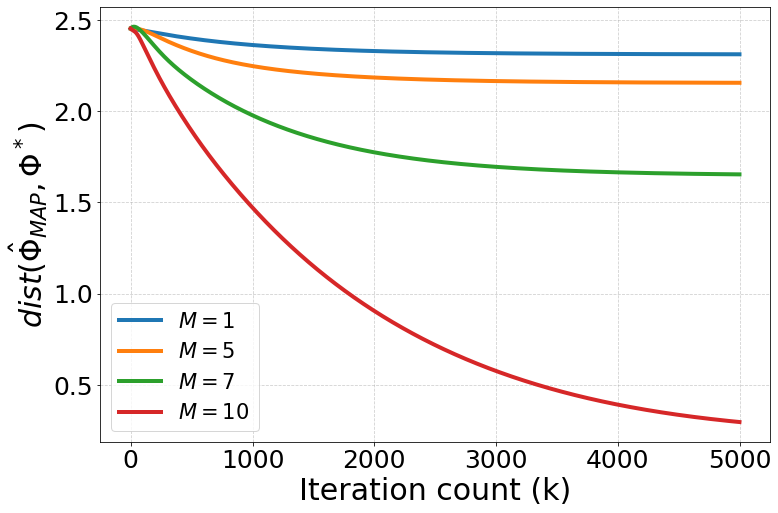

In [46]:
# Create a plot to show the convergence
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(K))), Error_CAMAP_1, label=r'$M = 1$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_5, label=r'$M = 5$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_7, label=r'$M = 7$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_10, label=r'$M = 10$ ', linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi}_{MAP},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)
plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:4]  
labels = labels[:4] 
plt.legend(handles=handles, labels=labels,fontsize=21)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [47]:
H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])
Phi_hat = Phi_true.dot(rot)
Error_CAMAP, _, Phi_MAP, F_MAP = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.452562688404641, Time: 0.02792191505432129
Iteration: 1, Subspace Dist: 2.452894760194166, Time: 0.018980979919433594
Iteration: 2, Subspace Dist: 2.453209226169917, Time: 0.016723155975341797
Iteration: 3, Subspace Dist: 2.4535064391823065, Time: 0.017919301986694336
Iteration: 4, Subspace Dist: 2.45378589269503, Time: 0.016956090927124023
Iteration: 5, Subspace Dist: 2.4540464572237424, Time: 0.0169827938079834
Iteration: 6, Subspace Dist: 2.4542865698673153, Time: 0.017995119094848633
Iteration: 7, Subspace Dist: 2.4545043872387904, Time: 0.01795053482055664
Iteration: 8, Subspace Dist: 2.4546979091288805, Time: 0.016995668411254883
Iteration: 9, Subspace Dist: 2.454865078216279, Time: 0.01791071891784668
Iteration: 10, Subspace Dist: 2.4550038597646484, Time: 0.015957117080688477
Iteration: 11, Subspace Dist: 2.455112304311459, Time: 0.016954898834228516
Iteration: 12, Subspace Dist: 2.4551885957221042, Time: 0.024934053421020508
Iteration: 13, Subspa

Iteration: 110, Subspace Dist: 2.345255178853062, Time: 0.023934602737426758
Iteration: 111, Subspace Dist: 2.3437525079733157, Time: 0.024932861328125
Iteration: 112, Subspace Dist: 2.3422515252261595, Time: 0.020943403244018555
Iteration: 113, Subspace Dist: 2.3407522759099053, Time: 0.021973609924316406
Iteration: 114, Subspace Dist: 2.339254801028807, Time: 0.023904085159301758
Iteration: 115, Subspace Dist: 2.3377591375713336, Time: 0.02194380760192871
Iteration: 116, Subspace Dist: 2.3362653187762086, Time: 0.02097344398498535
Iteration: 117, Subspace Dist: 2.3347733743862027, Time: 0.023905515670776367
Iteration: 118, Subspace Dist: 2.3332833308897336, Time: 0.02110576629638672
Iteration: 119, Subspace Dist: 2.331795211750395, Time: 0.026893138885498047
Iteration: 120, Subspace Dist: 2.3303090376245965, Time: 0.017983198165893555
Iteration: 121, Subspace Dist: 2.3288248265675513, Time: 0.01891922950744629
Iteration: 122, Subspace Dist: 2.327342594227884, Time: 0.0169856548309326

Iteration: 227, Subspace Dist: 2.1822762410362797, Time: 0.022940874099731445
Iteration: 228, Subspace Dist: 2.1809873912975117, Time: 0.020912647247314453
Iteration: 229, Subspace Dist: 2.1797001923110413, Time: 0.017953157424926758
Iteration: 230, Subspace Dist: 2.178414641722724, Time: 0.017950057983398438
Iteration: 231, Subspace Dist: 2.177130737122697, Time: 0.016986608505249023
Iteration: 232, Subspace Dist: 2.175848476043042, Time: 0.017955541610717773
Iteration: 233, Subspace Dist: 2.1745678559555452, Time: 0.017951011657714844
Iteration: 234, Subspace Dist: 2.1732888742695735, Time: 0.017949819564819336
Iteration: 235, Subspace Dist: 2.172011528330057, Time: 0.018917083740234375
Iteration: 236, Subspace Dist: 2.1707358154155814, Time: 0.01798391342163086
Iteration: 237, Subspace Dist: 2.1694617327365897, Time: 0.018918991088867188
Iteration: 238, Subspace Dist: 2.1681892774336977, Time: 0.02393651008605957
Iteration: 239, Subspace Dist: 2.166918446576112, Time: 0.020945310592

Iteration: 336, Subspace Dist: 2.0506267290709324, Time: 0.020941972732543945
Iteration: 337, Subspace Dist: 2.0494900933970177, Time: 0.021942853927612305
Iteration: 338, Subspace Dist: 2.0483545158227123, Time: 0.02197265625
Iteration: 339, Subspace Dist: 2.0472199903838963, Time: 0.0189511775970459
Iteration: 340, Subspace Dist: 2.046086511166666, Time: 0.0199127197265625
Iteration: 341, Subspace Dist: 2.0449540723084096, Time: 0.022059202194213867
Iteration: 342, Subspace Dist: 2.0438226679988443, Time: 0.0219728946685791
Iteration: 343, Subspace Dist: 2.0426922924810205, Time: 0.02096843719482422
Iteration: 344, Subspace Dist: 2.0415629400522888, Time: 0.02296924591064453
Iteration: 345, Subspace Dist: 2.040434605065227, Time: 0.017951488494873047
Iteration: 346, Subspace Dist: 2.0393072819285334, Time: 0.022909164428710938
Iteration: 347, Subspace Dist: 2.0381809651078817, Time: 0.021379709243774414
Iteration: 348, Subspace Dist: 2.0370556491267386, Time: 0.025931358337402344
Ite

Iteration: 446, Subspace Dist: 1.9310010580036634, Time: 0.026892662048339844
Iteration: 447, Subspace Dist: 1.9299580219237698, Time: 0.017949819564819336
Iteration: 448, Subspace Dist: 1.9289157366227434, Time: 0.016986846923828125
Iteration: 449, Subspace Dist: 1.9278742017162673, Time: 0.016922473907470703
Iteration: 450, Subspace Dist: 1.9268334168361543, Time: 0.017992019653320312
Iteration: 451, Subspace Dist: 1.9257933816295865, Time: 0.017948389053344727
Iteration: 452, Subspace Dist: 1.924754095758363, Time: 0.01904773712158203
Iteration: 453, Subspace Dist: 1.923715558898157, Time: 0.018949031829833984
Iteration: 454, Subspace Dist: 1.922677770737776, Time: 0.01795053482055664
Iteration: 455, Subspace Dist: 1.9216407309784374, Time: 0.01798391342163086
Iteration: 456, Subspace Dist: 1.9206044393330468, Time: 0.01792168617248535
Iteration: 457, Subspace Dist: 1.919568895525489, Time: 0.022968769073486328
Iteration: 458, Subspace Dist: 1.9185340992899256, Time: 0.0189566612243

Iteration: 555, Subspace Dist: 1.8216691799737994, Time: 0.02297186851501465
Iteration: 556, Subspace Dist: 1.8207060262986738, Time: 0.01795172691345215
Iteration: 557, Subspace Dist: 1.8197435722414557, Time: 0.017952919006347656
Iteration: 558, Subspace Dist: 1.8187818167883734, Time: 0.017919540405273438
Iteration: 559, Subspace Dist: 1.8178207589155644, Time: 0.018983840942382812
Iteration: 560, Subspace Dist: 1.816860397589224, Time: 0.018970489501953125
Iteration: 561, Subspace Dist: 1.8159007317657483, Time: 0.01795053482055664
Iteration: 562, Subspace Dist: 1.8149417603918856, Time: 0.01795196533203125
Iteration: 563, Subspace Dist: 1.8139834824048888, Time: 0.019948482513427734
Iteration: 564, Subspace Dist: 1.813025896732665, Time: 0.020973920822143555
Iteration: 565, Subspace Dist: 1.8120690022939339, Time: 0.016954421997070312
Iteration: 566, Subspace Dist: 1.8111127979983834, Time: 0.02393651008605957
Iteration: 567, Subspace Dist: 1.8101572827468266, Time: 0.024938106536

Iteration: 668, Subspace Dist: 1.7169799824128302, Time: 0.02196478843688965
Iteration: 669, Subspace Dist: 1.7160881239158736, Time: 0.019051790237426758
Iteration: 670, Subspace Dist: 1.7151968228273127, Time: 0.0189511775970459
Iteration: 671, Subspace Dist: 1.7143060779211556, Time: 0.018979549407958984
Iteration: 672, Subspace Dist: 1.713415887975474, Time: 0.019916296005249023
Iteration: 673, Subspace Dist: 1.7125262517724484, Time: 0.02493572235107422
Iteration: 674, Subspace Dist: 1.7116371680984168, Time: 0.025928020477294922
Iteration: 675, Subspace Dist: 1.7107486357439199, Time: 0.024968385696411133
Iteration: 676, Subspace Dist: 1.7098606535037442, Time: 0.020909547805786133
Iteration: 677, Subspace Dist: 1.7089732201769647, Time: 0.01994609832763672
Iteration: 678, Subspace Dist: 1.7080863345669879, Time: 0.023040056228637695
Iteration: 679, Subspace Dist: 1.707199995481591, Time: 0.019945144653320312
Iteration: 680, Subspace Dist: 1.706314201732962, Time: 0.0230717658996

Iteration: 776, Subspace Dist: 1.6236547921052724, Time: 0.02190876007080078
Iteration: 777, Subspace Dist: 1.622817023967759, Time: 0.024039268493652344
Iteration: 778, Subspace Dist: 1.6219797089650843, Time: 0.01994466781616211
Iteration: 779, Subspace Dist: 1.6211428464061244, Time: 0.04021620750427246
Iteration: 780, Subspace Dist: 1.620306435604495, Time: 0.028921127319335938
Iteration: 781, Subspace Dist: 1.6194704758785314, Time: 0.018063783645629883
Iteration: 782, Subspace Dist: 1.6186349665512725, Time: 0.024933338165283203
Iteration: 783, Subspace Dist: 1.617799906950444, Time: 0.018947839736938477
Iteration: 784, Subspace Dist: 1.6169652964084433, Time: 0.018949031829833984
Iteration: 785, Subspace Dist: 1.6161311342623181, Time: 0.021942138671875
Iteration: 786, Subspace Dist: 1.615297419853752, Time: 0.01909041404724121
Iteration: 787, Subspace Dist: 1.614464152529045, Time: 0.02078700065612793
Iteration: 788, Subspace Dist: 1.613631331639099, Time: 0.018980979919433594


Iteration: 886, Subspace Dist: 1.534092690243871, Time: 0.019948244094848633
Iteration: 887, Subspace Dist: 1.5333015333318742, Time: 0.01798224449157715
Iteration: 888, Subspace Dist: 1.5325107776034594, Time: 0.018329620361328125
Iteration: 889, Subspace Dist: 1.5317204227640597, Time: 0.017121076583862305
Iteration: 890, Subspace Dist: 1.5309304685214513, Time: 0.017950773239135742
Iteration: 891, Subspace Dist: 1.5301409145857314, Time: 0.01795196533203125
Iteration: 892, Subspace Dist: 1.5293517606692935, Time: 0.016956806182861328
Iteration: 893, Subspace Dist: 1.5285630064868065, Time: 0.016954421997070312
Iteration: 894, Subspace Dist: 1.5277746517551933, Time: 0.01791977882385254
Iteration: 895, Subspace Dist: 1.5269866961936054, Time: 0.017087936401367188
Iteration: 896, Subspace Dist: 1.5261991395234031, Time: 0.0189511775970459
Iteration: 897, Subspace Dist: 1.525411981468132, Time: 0.01795196533203125
Iteration: 898, Subspace Dist: 1.5246252217535008, Time: 0.0180976390838

Iteration: 1002, Subspace Dist: 1.4449330977189938, Time: 0.01894998550415039
Iteration: 1003, Subspace Dist: 1.4441869580171205, Time: 0.018952369689941406
Iteration: 1004, Subspace Dist: 1.4434411958227296, Time: 0.01826620101928711
Iteration: 1005, Subspace Dist: 1.442695810984704, Time: 0.01795339584350586
Iteration: 1006, Subspace Dist: 1.441950803352289, Time: 0.017075777053833008
Iteration: 1007, Subspace Dist: 1.4412061727750785, Time: 0.01795029640197754
Iteration: 1008, Subspace Dist: 1.4404619191030084, Time: 0.017917633056640625
Iteration: 1009, Subspace Dist: 1.4397180421863414, Time: 0.018114566802978516
Iteration: 1010, Subspace Dist: 1.4389745418756625, Time: 0.016954421997070312
Iteration: 1011, Subspace Dist: 1.438231418021867, Time: 0.01795196533203125
Iteration: 1012, Subspace Dist: 1.4374886704761505, Time: 0.018063783645629883
Iteration: 1013, Subspace Dist: 1.4367462990899982, Time: 0.01798391342163086
Iteration: 1014, Subspace Dist: 1.436004303715177, Time: 0.01

Iteration: 1116, Subspace Dist: 1.3622695451516293, Time: 0.018949270248413086
Iteration: 1117, Subspace Dist: 1.36156550175286, Time: 0.0180511474609375
Iteration: 1118, Subspace Dist: 1.3608618191828226, Time: 0.01795172691345215
Iteration: 1119, Subspace Dist: 1.3601584972896004, Time: 0.017984390258789062
Iteration: 1120, Subspace Dist: 1.3594555359210796, Time: 0.017063140869140625
Iteration: 1121, Subspace Dist: 1.3587529349249445, Time: 0.016987085342407227
Iteration: 1122, Subspace Dist: 1.3580506941486774, Time: 0.016921520233154297
Iteration: 1123, Subspace Dist: 1.35734881343956, Time: 0.01809215545654297
Iteration: 1124, Subspace Dist: 1.3566472926446709, Time: 0.01795220375061035
Iteration: 1125, Subspace Dist: 1.355946131610884, Time: 0.01696157455444336
Iteration: 1126, Subspace Dist: 1.3552453301848701, Time: 0.01891183853149414
Iteration: 1127, Subspace Dist: 1.354544888213094, Time: 0.01798701286315918
Iteration: 1128, Subspace Dist: 1.3538448055418162, Time: 0.019942

Iteration: 1223, Subspace Dist: 1.2889519500172975, Time: 0.020979881286621094
Iteration: 1224, Subspace Dist: 1.2882856133407758, Time: 0.017566442489624023
Iteration: 1225, Subspace Dist: 1.2876196201036296, Time: 0.01695871353149414
Iteration: 1226, Subspace Dist: 1.2869539701337467, Time: 0.018063783645629883
Iteration: 1227, Subspace Dist: 1.2862886632588784, Time: 0.016983985900878906
Iteration: 1228, Subspace Dist: 1.2856236993066386, Time: 0.018921613693237305
Iteration: 1229, Subspace Dist: 1.284959078104503, Time: 0.016987085342407227
Iteration: 1230, Subspace Dist: 1.2842947994798128, Time: 0.017950057983398438
Iteration: 1231, Subspace Dist: 1.2836308632597762, Time: 0.016922712326049805
Iteration: 1232, Subspace Dist: 1.282967269271466, Time: 0.016984939575195312
Iteration: 1233, Subspace Dist: 1.282304017341825, Time: 0.01792144775390625
Iteration: 1234, Subspace Dist: 1.2816411072976686, Time: 0.017984628677368164
Iteration: 1235, Subspace Dist: 1.2809785389656796, Time:

Iteration: 1329, Subspace Dist: 1.2201977415822667, Time: 0.018948078155517578
Iteration: 1330, Subspace Dist: 1.2195668313928383, Time: 0.018982410430908203
Iteration: 1331, Subspace Dist: 1.2189362458778286, Time: 0.017023801803588867
Iteration: 1332, Subspace Dist: 1.2183059848575766, Time: 0.017986297607421875
Iteration: 1333, Subspace Dist: 1.217676048152418, Time: 0.016952037811279297
Iteration: 1334, Subspace Dist: 1.2170464355826804, Time: 0.01808953285217285
Iteration: 1335, Subspace Dist: 1.2164171469686846, Time: 0.016919851303100586
Iteration: 1336, Subspace Dist: 1.2157881821307492, Time: 0.017984390258789062
Iteration: 1337, Subspace Dist: 1.215159540889188, Time: 0.018017292022705078
Iteration: 1338, Subspace Dist: 1.2145312230643135, Time: 0.018949508666992188
Iteration: 1339, Subspace Dist: 1.2139032284764357, Time: 0.02094244956970215
Iteration: 1340, Subspace Dist: 1.2132755569458649, Time: 0.018950462341308594
Iteration: 1341, Subspace Dist: 1.2126482082929118, Time

Iteration: 1434, Subspace Dist: 1.15569126919464, Time: 0.017952680587768555
Iteration: 1435, Subspace Dist: 1.1550934718271941, Time: 0.018093109130859375
Iteration: 1436, Subspace Dist: 1.1544959803940116, Time: 0.01791667938232422
Iteration: 1437, Subspace Dist: 1.1538987947191819, Time: 0.016993999481201172
Iteration: 1438, Subspace Dist: 1.1533019146268637, Time: 0.018086910247802734
Iteration: 1439, Subspace Dist: 1.152705339941285, Time: 0.018912315368652344
Iteration: 1440, Subspace Dist: 1.1521090704867485, Time: 0.01695394515991211
Iteration: 1441, Subspace Dist: 1.151513106087623, Time: 0.016921281814575195
Iteration: 1442, Subspace Dist: 1.1509174465683496, Time: 0.01798415184020996
Iteration: 1443, Subspace Dist: 1.150322091753444, Time: 0.019046306610107422
Iteration: 1444, Subspace Dist: 1.149727041467493, Time: 0.020943880081176758
Iteration: 1445, Subspace Dist: 1.149132295535156, Time: 0.02108621597290039
Iteration: 1446, Subspace Dist: 1.1485378537811646, Time: 0.018

Iteration: 1549, Subspace Dist: 1.0889070791119964, Time: 0.02004551887512207
Iteration: 1550, Subspace Dist: 1.0883433308798824, Time: 0.024933576583862305
Iteration: 1551, Subspace Dist: 1.087779868896265, Time: 0.016370058059692383
Iteration: 1552, Subspace Dist: 1.0872166929953448, Time: 0.01795196533203125
Iteration: 1553, Subspace Dist: 1.0866538030114234, Time: 0.0189511775970459
Iteration: 1554, Subspace Dist: 1.0860911987789013, Time: 0.018949508666992188
Iteration: 1555, Subspace Dist: 1.085528880132279, Time: 0.016991376876831055
Iteration: 1556, Subspace Dist: 1.0849668469061564, Time: 0.017952919006347656
Iteration: 1557, Subspace Dist: 1.084405098935235, Time: 0.0169522762298584
Iteration: 1558, Subspace Dist: 1.0838436360543129, Time: 0.016957759857177734
Iteration: 1559, Subspace Dist: 1.08328245809829, Time: 0.016951799392700195
Iteration: 1560, Subspace Dist: 1.0827215649021673, Time: 0.021015644073486328
Iteration: 1561, Subspace Dist: 1.0821609563010448, Time: 0.017

Iteration: 1664, Subspace Dist: 1.0259121526955368, Time: 0.018919706344604492
Iteration: 1665, Subspace Dist: 1.0253802612081593, Time: 0.01795196533203125
Iteration: 1666, Subspace Dist: 1.0248486375672514, Time: 0.01795339584350586
Iteration: 1667, Subspace Dist: 1.0243172816187074, Time: 0.016985416412353516
Iteration: 1668, Subspace Dist: 1.0237861932085202, Time: 0.018918752670288086
Iteration: 1669, Subspace Dist: 1.0232553721827835, Time: 0.01994466781616211
Iteration: 1670, Subspace Dist: 1.022724818387695, Time: 0.018950223922729492
Iteration: 1671, Subspace Dist: 1.022194531669549, Time: 0.017952919006347656
Iteration: 1672, Subspace Dist: 1.021664511874746, Time: 0.01897740364074707
Iteration: 1673, Subspace Dist: 1.0211347588497823, Time: 0.017264842987060547
Iteration: 1674, Subspace Dist: 1.0206052724412589, Time: 0.017951250076293945
Iteration: 1675, Subspace Dist: 1.020076052495876, Time: 0.018949508666992188
Iteration: 1676, Subspace Dist: 1.0195470988604334, Time: 0.

Iteration: 1780, Subspace Dist: 0.9659609315020316, Time: 0.02003645896911621
Iteration: 1781, Subspace Dist: 0.9654591075415948, Time: 0.01795029640197754
Iteration: 1782, Subspace Dist: 0.9649575342109314, Time: 0.017115354537963867
Iteration: 1783, Subspace Dist: 0.9644562113672539, Time: 0.01792001724243164
Iteration: 1784, Subspace Dist: 0.9639551388678642, Time: 0.016954421997070312
Iteration: 1785, Subspace Dist: 0.9634543165701598, Time: 0.01795196533203125
Iteration: 1786, Subspace Dist: 0.9629537443316286, Time: 0.01795196533203125
Iteration: 1787, Subspace Dist: 0.9624534220098527, Time: 0.01795196533203125
Iteration: 1788, Subspace Dist: 0.9619533494625109, Time: 0.017986774444580078
Iteration: 1789, Subspace Dist: 0.9614535265473673, Time: 0.017918825149536133
Iteration: 1790, Subspace Dist: 0.9609539531222852, Time: 0.016952991485595703
Iteration: 1791, Subspace Dist: 0.9604546290452186, Time: 0.018082618713378906
Iteration: 1792, Subspace Dist: 0.9599555541742106, Time: 

Iteration: 1895, Subspace Dist: 0.9098594303109545, Time: 0.018949031829833984
Iteration: 1896, Subspace Dist: 0.9093855152248066, Time: 0.018947839736938477
Iteration: 1897, Subspace Dist: 0.9089118349379776, Time: 0.016954660415649414
Iteration: 1898, Subspace Dist: 0.9084383893178506, Time: 0.01795196533203125
Iteration: 1899, Subspace Dist: 0.9079651782318887, Time: 0.01898503303527832
Iteration: 1900, Subspace Dist: 0.9074922015476418, Time: 0.016951560974121094
Iteration: 1901, Subspace Dist: 0.9070194591327417, Time: 0.017919540405273438
Iteration: 1902, Subspace Dist: 0.9065469508549033, Time: 0.018950939178466797
Iteration: 1903, Subspace Dist: 0.9060746765819255, Time: 0.016987085342407227
Iteration: 1904, Subspace Dist: 0.90560263618169, Time: 0.018950223922729492
Iteration: 1905, Subspace Dist: 0.9051308295221631, Time: 0.016986370086669922
Iteration: 1906, Subspace Dist: 0.9046592564713888, Time: 0.018951416015625
Iteration: 1907, Subspace Dist: 0.9041879168975032, Time: 0

Iteration: 2008, Subspace Dist: 0.8577623119131612, Time: 0.017987728118896484
Iteration: 2009, Subspace Dist: 0.8573141089988204, Time: 0.017956018447875977
Iteration: 2010, Subspace Dist: 0.8568661264082932, Time: 0.01891016960144043
Iteration: 2011, Subspace Dist: 0.8564183640179107, Time: 0.016953706741333008
Iteration: 2012, Subspace Dist: 0.8559708217040738, Time: 0.02007460594177246
Iteration: 2013, Subspace Dist: 0.8555234993432623, Time: 0.0169527530670166
Iteration: 2014, Subspace Dist: 0.85507639681203, Time: 0.018917322158813477
Iteration: 2015, Subspace Dist: 0.8546295139870066, Time: 0.018982410430908203
Iteration: 2016, Subspace Dist: 0.8541828507448929, Time: 0.016956090927124023
Iteration: 2017, Subspace Dist: 0.8537364069624657, Time: 0.017948627471923828
Iteration: 2018, Subspace Dist: 0.8532901825165788, Time: 0.01891922950744629
Iteration: 2019, Subspace Dist: 0.8528441772841567, Time: 0.016988754272460938
Iteration: 2020, Subspace Dist: 0.8523983911422023, Time: 0

Iteration: 2123, Subspace Dist: 0.8076331710966548, Time: 0.01991558074951172
Iteration: 2124, Subspace Dist: 0.8072095127552401, Time: 0.016989707946777344
Iteration: 2125, Subspace Dist: 0.8067860609889432, Time: 0.019908428192138672
Iteration: 2126, Subspace Dist: 0.806362815682246, Time: 0.018949508666992188
Iteration: 2127, Subspace Dist: 0.8059397767197021, Time: 0.017983436584472656
Iteration: 2128, Subspace Dist: 0.8055169439859328, Time: 0.017952680587768555
Iteration: 2129, Subspace Dist: 0.8050943173656218, Time: 0.016952991485595703
Iteration: 2130, Subspace Dist: 0.8046718967435248, Time: 0.016958951950073242
Iteration: 2131, Subspace Dist: 0.804249682004462, Time: 0.016950368881225586
Iteration: 2132, Subspace Dist: 0.8038276730333173, Time: 0.016954421997070312
Iteration: 2133, Subspace Dist: 0.8034058697150481, Time: 0.01792168617248535
Iteration: 2134, Subspace Dist: 0.8029842719346733, Time: 0.01795196533203125
Iteration: 2135, Subspace Dist: 0.8025628795772805, Time:

Iteration: 2229, Subspace Dist: 0.7638530195121787, Time: 0.017986536026000977
Iteration: 2230, Subspace Dist: 0.7634506279379764, Time: 0.01791548728942871
Iteration: 2231, Subspace Dist: 0.7630484310561229, Time: 0.01998281478881836
Iteration: 2232, Subspace Dist: 0.7626464287578847, Time: 0.016954898834228516
Iteration: 2233, Subspace Dist: 0.7622446209345891, Time: 0.017943143844604492
Iteration: 2234, Subspace Dist: 0.7618430074776228, Time: 0.020032405853271484
Iteration: 2235, Subspace Dist: 0.7614415882784361, Time: 0.018979787826538086
Iteration: 2236, Subspace Dist: 0.7610403632285344, Time: 0.016922950744628906
Iteration: 2237, Subspace Dist: 0.7606393322194902, Time: 0.017984390258789062
Iteration: 2238, Subspace Dist: 0.7602384951429352, Time: 0.01792120933532715
Iteration: 2239, Subspace Dist: 0.7598378518905562, Time: 0.01798725128173828
Iteration: 2240, Subspace Dist: 0.7594374023541096, Time: 0.018914222717285156
Iteration: 2241, Subspace Dist: 0.7590371464254037, Time

Iteration: 2334, Subspace Dist: 0.7226448270883512, Time: 0.017957448959350586
Iteration: 2335, Subspace Dist: 0.7222622956834421, Time: 0.018911123275756836
Iteration: 2336, Subspace Dist: 0.721879947876355, Time: 0.019948720932006836
Iteration: 2337, Subspace Dist: 0.7214977835644617, Time: 0.01798224449157715
Iteration: 2338, Subspace Dist: 0.7211158026451894, Time: 0.019022226333618164
Iteration: 2339, Subspace Dist: 0.7207340050160219, Time: 0.01795363426208496
Iteration: 2340, Subspace Dist: 0.7203523905745, Time: 0.018980026245117188
Iteration: 2341, Subspace Dist: 0.7199709592182181, Time: 0.018918514251708984
Iteration: 2342, Subspace Dist: 0.7195897108448249, Time: 0.017950773239135742
Iteration: 2343, Subspace Dist: 0.7192086453520266, Time: 0.01795196533203125
Iteration: 2344, Subspace Dist: 0.7188277626375841, Time: 0.017987728118896484
Iteration: 2345, Subspace Dist: 0.7184470625993108, Time: 0.017949581146240234
Iteration: 2346, Subspace Dist: 0.7180665451350787, Time: 0

Iteration: 2449, Subspace Dist: 0.6798322363167887, Time: 0.01795053482055664
Iteration: 2450, Subspace Dist: 0.6794701593097779, Time: 0.017983436584472656
Iteration: 2451, Subspace Dist: 0.6791082544504514, Time: 0.01695704460144043
Iteration: 2452, Subspace Dist: 0.6787465216422542, Time: 0.017917871475219727
Iteration: 2453, Subspace Dist: 0.6783849607886818, Time: 0.018950939178466797
Iteration: 2454, Subspace Dist: 0.6780235717932771, Time: 0.018949270248413086
Iteration: 2455, Subspace Dist: 0.6776623545596385, Time: 0.018949031829833984
Iteration: 2456, Subspace Dist: 0.677301308991413, Time: 0.019945383071899414
Iteration: 2457, Subspace Dist: 0.6769404349922951, Time: 0.01795363426208496
Iteration: 2458, Subspace Dist: 0.6765797324660321, Time: 0.018979310989379883
Iteration: 2459, Subspace Dist: 0.6762192013164183, Time: 0.017645835876464844
Iteration: 2460, Subspace Dist: 0.675858841447301, Time: 0.019076108932495117
Iteration: 2461, Subspace Dist: 0.6754986527625757, Time:

Iteration: 2558, Subspace Dist: 0.6413591079362566, Time: 0.019946813583374023
Iteration: 2559, Subspace Dist: 0.6410152370050062, Time: 0.01994633674621582
Iteration: 2560, Subspace Dist: 0.6406715279834637, Time: 0.019945859909057617
Iteration: 2561, Subspace Dist: 0.6403279807802971, Time: 0.0219419002532959
Iteration: 2562, Subspace Dist: 0.6399845953042185, Time: 0.022971391677856445
Iteration: 2563, Subspace Dist: 0.6396413714639869, Time: 0.029889583587646484
Iteration: 2564, Subspace Dist: 0.6392983091684045, Time: 0.02197265625
Iteration: 2565, Subspace Dist: 0.6389554083263246, Time: 0.019944429397583008
Iteration: 2566, Subspace Dist: 0.6386126688466386, Time: 0.01894974708557129
Iteration: 2567, Subspace Dist: 0.6382700906382891, Time: 0.02191162109375
Iteration: 2568, Subspace Dist: 0.6379276736102627, Time: 0.023934125900268555
Iteration: 2569, Subspace Dist: 0.6375854176715904, Time: 0.01994609832763672
Iteration: 2570, Subspace Dist: 0.6372433227313472, Time: 0.02194380

Iteration: 2666, Subspace Dist: 0.6051381558147246, Time: 0.0189516544342041
Iteration: 2667, Subspace Dist: 0.6048112525219739, Time: 0.01642012596130371
Iteration: 2668, Subspace Dist: 0.6044845015308183, Time: 0.016954898834228516
Iteration: 2669, Subspace Dist: 0.6041579027546264, Time: 0.016920089721679688
Iteration: 2670, Subspace Dist: 0.6038314561068174, Time: 0.016954660415649414
Iteration: 2671, Subspace Dist: 0.6035051615008453, Time: 0.016986608505249023
Iteration: 2672, Subspace Dist: 0.6031790188502107, Time: 0.016963958740234375
Iteration: 2673, Subspace Dist: 0.6028530280684518, Time: 0.017536163330078125
Iteration: 2674, Subspace Dist: 0.6025271890691496, Time: 0.018950700759887695
Iteration: 2675, Subspace Dist: 0.6022015017659277, Time: 0.022069692611694336
Iteration: 2676, Subspace Dist: 0.6018759660724475, Time: 0.019977331161499023
Iteration: 2677, Subspace Dist: 0.6015505819024156, Time: 0.021909236907958984
Iteration: 2678, Subspace Dist: 0.6012253491695794, Tim

Iteration: 2780, Subspace Dist: 0.5688315961550877, Time: 0.02393507957458496
Iteration: 2781, Subspace Dist: 0.5685215070233063, Time: 0.02197575569152832
Iteration: 2782, Subspace Dist: 0.5682115605763628, Time: 0.024899005889892578
Iteration: 2783, Subspace Dist: 0.5679017567321336, Time: 0.024967432022094727
Iteration: 2784, Subspace Dist: 0.5675920954085252, Time: 0.02589702606201172
Iteration: 2785, Subspace Dist: 0.5672825765234898, Time: 0.020943403244018555
Iteration: 2786, Subspace Dist: 0.5669731999950092, Time: 0.019978761672973633
Iteration: 2787, Subspace Dist: 0.5666639657411067, Time: 0.023906707763671875
Iteration: 2788, Subspace Dist: 0.5663548736798448, Time: 0.021938323974609375
Iteration: 2789, Subspace Dist: 0.5660459237293163, Time: 0.020192861557006836
Iteration: 2790, Subspace Dist: 0.565737115807655, Time: 0.022941112518310547
Iteration: 2791, Subspace Dist: 0.5654284498330384, Time: 0.016954660415649414
Iteration: 2792, Subspace Dist: 0.5651199257236676, Time

Iteration: 2892, Subspace Dist: 0.5349700517238878, Time: 0.02590012550354004
Iteration: 2893, Subspace Dist: 0.5346754411061179, Time: 0.019945621490478516
Iteration: 2894, Subspace Dist: 0.5343809641996783, Time: 0.017983675003051758
Iteration: 2895, Subspace Dist: 0.5340866209264129, Time: 0.01757955551147461
Iteration: 2896, Subspace Dist: 0.5337924112082125, Time: 0.018948793411254883
Iteration: 2897, Subspace Dist: 0.5334983349669881, Time: 0.016985177993774414
Iteration: 2898, Subspace Dist: 0.533204392124692, Time: 0.017955541610717773
Iteration: 2899, Subspace Dist: 0.5329105826033101, Time: 0.017870426177978516
Iteration: 2900, Subspace Dist: 0.5326169063248546, Time: 0.016956567764282227
Iteration: 2901, Subspace Dist: 0.532323363211379, Time: 0.017157316207885742
Iteration: 2902, Subspace Dist: 0.5320299531849653, Time: 0.017952680587768555
Iteration: 2903, Subspace Dist: 0.5317366761677341, Time: 0.023966550827026367
Iteration: 2904, Subspace Dist: 0.5314435320818311, Time

Iteration: 3001, Subspace Dist: 0.5036282956453267, Time: 0.02290654182434082
Iteration: 3002, Subspace Dist: 0.5033478064286894, Time: 0.018949031829833984
Iteration: 3003, Subspace Dist: 0.5030674425954965, Time: 0.01994800567626953
Iteration: 3004, Subspace Dist: 0.5027872040710605, Time: 0.016954421997070312
Iteration: 3005, Subspace Dist: 0.5025070907807266, Time: 0.017951250076293945
Iteration: 3006, Subspace Dist: 0.5022271026498569, Time: 0.018949031829833984
Iteration: 3007, Subspace Dist: 0.5019472396038581, Time: 0.01795196533203125
Iteration: 3008, Subspace Dist: 0.501667501568157, Time: 0.01795220375061035
Iteration: 3009, Subspace Dist: 0.5013878884682124, Time: 0.01795172691345215
Iteration: 3010, Subspace Dist: 0.5011084002295175, Time: 0.017952442169189453
Iteration: 3011, Subspace Dist: 0.5008290367775853, Time: 0.018952131271362305
Iteration: 3012, Subspace Dist: 0.5005497980379705, Time: 0.023935556411743164
Iteration: 3013, Subspace Dist: 0.5002706839362472, Time: 

Iteration: 3115, Subspace Dist: 0.47244235414319674, Time: 0.023937702178955078
Iteration: 3116, Subspace Dist: 0.47217568452854547, Time: 0.017992734909057617
Iteration: 3117, Subspace Dist: 0.471909131967189, Time: 0.01990675926208496
Iteration: 3118, Subspace Dist: 0.47164269638762685, Time: 0.017981529235839844
Iteration: 3119, Subspace Dist: 0.47137637771838575, Time: 0.0180814266204834
Iteration: 3120, Subspace Dist: 0.47111017588802184, Time: 0.01791858673095703
Iteration: 3121, Subspace Dist: 0.4708440908251106, Time: 0.01795029640197754
Iteration: 3122, Subspace Dist: 0.47057812245825714, Time: 0.01798558235168457
Iteration: 3123, Subspace Dist: 0.47031227071609616, Time: 0.016952991485595703
Iteration: 3124, Subspace Dist: 0.47004653552727826, Time: 0.016957759857177734
Iteration: 3125, Subspace Dist: 0.4697809168204906, Time: 0.01791858673095703
Iteration: 3126, Subspace Dist: 0.46951541452443984, Time: 0.015988826751708984
Iteration: 3127, Subspace Dist: 0.46925002856785986

Iteration: 3227, Subspace Dist: 0.44328682148223847, Time: 0.02390575408935547
Iteration: 3228, Subspace Dist: 0.4430328231135574, Time: 0.017949819564819336
Iteration: 3229, Subspace Dist: 0.4427789339440821, Time: 0.01795363426208496
Iteration: 3230, Subspace Dist: 0.4425251539050111, Time: 0.01798224449157715
Iteration: 3231, Subspace Dist: 0.4422714829275657, Time: 0.017921924591064453
Iteration: 3232, Subspace Dist: 0.44201792094298636, Time: 0.018949270248413086
Iteration: 3233, Subspace Dist: 0.4417644678825396, Time: 0.016991615295410156
Iteration: 3234, Subspace Dist: 0.4415111236775077, Time: 0.01691579818725586
Iteration: 3235, Subspace Dist: 0.4412578882592016, Time: 0.016954898834228516
Iteration: 3236, Subspace Dist: 0.4410047615589473, Time: 0.016954898834228516
Iteration: 3237, Subspace Dist: 0.4407517435080958, Time: 0.016956567764282227
Iteration: 3238, Subspace Dist: 0.4404988340380229, Time: 0.016992568969726562
Iteration: 3239, Subspace Dist: 0.44024603308012067, T

Iteration: 3341, Subspace Dist: 0.41501795678267617, Time: 0.02393627166748047
Iteration: 3342, Subspace Dist: 0.4147759690229066, Time: 0.019946813583374023
Iteration: 3343, Subspace Dist: 0.41453408275195214, Time: 0.01698613166809082
Iteration: 3344, Subspace Dist: 0.414292297903274, Time: 0.016923189163208008
Iteration: 3345, Subspace Dist: 0.41405061441036595, Time: 0.01795196533203125
Iteration: 3346, Subspace Dist: 0.4138090322067313, Time: 0.01795196533203125
Iteration: 3347, Subspace Dist: 0.4135675512258906, Time: 0.016954660415649414
Iteration: 3348, Subspace Dist: 0.41332617140138483, Time: 0.01795339584350586
Iteration: 3349, Subspace Dist: 0.4130848926667715, Time: 0.016952991485595703
Iteration: 3350, Subspace Dist: 0.41284371495562594, Time: 0.016954660415649414
Iteration: 3351, Subspace Dist: 0.4126026382015405, Time: 0.016954898834228516
Iteration: 3352, Subspace Dist: 0.41236166233812227, Time: 0.01795196533203125
Iteration: 3353, Subspace Dist: 0.4121207872990035, T

Iteration: 3448, Subspace Dist: 0.3896876911299137, Time: 0.020907878875732422
Iteration: 3449, Subspace Dist: 0.3894561886760465, Time: 0.016991376876831055
Iteration: 3450, Subspace Dist: 0.3892247806842901, Time: 0.017917871475219727
Iteration: 3451, Subspace Dist: 0.3889934670897645, Time: 0.01695418357849121
Iteration: 3452, Subspace Dist: 0.3887622478276142, Time: 0.016954660415649414
Iteration: 3453, Subspace Dist: 0.38853112283298474, Time: 0.016954421997070312
Iteration: 3454, Subspace Dist: 0.38830009204104543, Time: 0.016956090927124023
Iteration: 3455, Subspace Dist: 0.38806915538696135, Time: 0.016922950744628906
Iteration: 3456, Subspace Dist: 0.3878383128059343, Time: 0.017983675003051758
Iteration: 3457, Subspace Dist: 0.3876075642331563, Time: 0.016956329345703125
Iteration: 3458, Subspace Dist: 0.3873769096038443, Time: 0.01791691780090332
Iteration: 3459, Subspace Dist: 0.38714634885322863, Time: 0.016986846923828125
Iteration: 3460, Subspace Dist: 0.3869158819165486

Iteration: 3562, Subspace Dist: 0.36388932199008744, Time: 0.02293848991394043
Iteration: 3563, Subspace Dist: 0.36366817318373545, Time: 0.021908998489379883
Iteration: 3564, Subspace Dist: 0.36344711151648446, Time: 0.01795196533203125
Iteration: 3565, Subspace Dist: 0.36322613692463207, Time: 0.018950939178466797
Iteration: 3566, Subspace Dist: 0.3630052493445017, Time: 0.017983436584472656
Iteration: 3567, Subspace Dist: 0.36278444871240073, Time: 0.017920494079589844
Iteration: 3568, Subspace Dist: 0.3625637349646604, Time: 0.017983675003051758
Iteration: 3569, Subspace Dist: 0.36234310803761705, Time: 0.017920970916748047
Iteration: 3570, Subspace Dist: 0.36212256786760433, Time: 0.0169525146484375
Iteration: 3571, Subspace Dist: 0.3619021143909748, Time: 0.0189511775970459
Iteration: 3572, Subspace Dist: 0.361681747544081, Time: 0.016989707946777344
Iteration: 3573, Subspace Dist: 0.36146146726328515, Time: 0.02093958854675293
Iteration: 3574, Subspace Dist: 0.3612412734849545, 

Iteration: 3676, Subspace Dist: 0.339224345335318, Time: 0.02194380760192871
Iteration: 3677, Subspace Dist: 0.3390127215134731, Time: 0.017954587936401367
Iteration: 3678, Subspace Dist: 0.3388011776029975, Time: 0.01795196533203125
Iteration: 3679, Subspace Dist: 0.33858971354066136, Time: 0.02038860321044922
Iteration: 3680, Subspace Dist: 0.3383783292632305, Time: 0.018738985061645508
Iteration: 3681, Subspace Dist: 0.33816702470746757, Time: 0.017919540405273438
Iteration: 3682, Subspace Dist: 0.3379557998101398, Time: 0.018980026245117188
Iteration: 3683, Subspace Dist: 0.3377446545080157, Time: 0.01695418357849121
Iteration: 3684, Subspace Dist: 0.3375335887378597, Time: 0.017956018447875977
Iteration: 3685, Subspace Dist: 0.33732260243643886, Time: 0.018035888671875
Iteration: 3686, Subspace Dist: 0.33711169554051656, Time: 0.01798534393310547
Iteration: 3687, Subspace Dist: 0.33690086798686164, Time: 0.021061420440673828
Iteration: 3688, Subspace Dist: 0.3366901197122436, Time

Iteration: 3788, Subspace Dist: 0.3160047866592928, Time: 0.021910905838012695
Iteration: 3789, Subspace Dist: 0.31580171948162095, Time: 0.021939992904663086
Iteration: 3790, Subspace Dist: 0.3155987251186936, Time: 0.017984390258789062
Iteration: 3791, Subspace Dist: 0.31539580350686247, Time: 0.016954898834228516
Iteration: 3792, Subspace Dist: 0.3151929545824566, Time: 0.01695418357849121
Iteration: 3793, Subspace Dist: 0.31499017828180065, Time: 0.01792001724243164
Iteration: 3794, Subspace Dist: 0.3147874745412179, Time: 0.017952919006347656
Iteration: 3795, Subspace Dist: 0.3145848432970095, Time: 0.017950773239135742
Iteration: 3796, Subspace Dist: 0.31438228448547517, Time: 0.016986608505249023
Iteration: 3797, Subspace Dist: 0.3141797980429124, Time: 0.01795220375061035
Iteration: 3798, Subspace Dist: 0.3139773839055953, Time: 0.016922473907470703
Iteration: 3799, Subspace Dist: 0.3137750420097972, Time: 0.027926921844482422
Iteration: 3800, Subspace Dist: 0.31357277229178365

Iteration: 3902, Subspace Dist: 0.29330875095916087, Time: 0.02393484115600586
Iteration: 3903, Subspace Dist: 0.29311357198949456, Time: 0.016955137252807617
Iteration: 3904, Subspace Dist: 0.2929184585002722, Time: 0.017951250076293945
Iteration: 3905, Subspace Dist: 0.2927234104262447, Time: 0.018950223922729492
Iteration: 3906, Subspace Dist: 0.29252842770213644, Time: 0.01795172691345215
Iteration: 3907, Subspace Dist: 0.29233351026264187, Time: 0.017951250076293945
Iteration: 3908, Subspace Dist: 0.29213865804245803, Time: 0.016954660415649414
Iteration: 3909, Subspace Dist: 0.2919438709762449, Time: 0.016986608505249023
Iteration: 3910, Subspace Dist: 0.2917491489986481, Time: 0.01894998550415039
Iteration: 3911, Subspace Dist: 0.291554492044284, Time: 0.017951488494873047
Iteration: 3912, Subspace Dist: 0.2913599000477519, Time: 0.016954898834228516
Iteration: 3913, Subspace Dist: 0.29116537294364164, Time: 0.02293872833251953
Iteration: 3914, Subspace Dist: 0.29097091066650477

Iteration: 4006, Subspace Dist: 0.2733488629974364, Time: 0.024900197982788086
Iteration: 4007, Subspace Dist: 0.2731601401912259, Time: 0.021073102951049805
Iteration: 4008, Subspace Dist: 0.2729714759460103, Time: 0.01797771453857422
Iteration: 4009, Subspace Dist: 0.27278287019368747, Time: 0.017923593521118164
Iteration: 4010, Subspace Dist: 0.2725943228661262, Time: 0.01798248291015625
Iteration: 4011, Subspace Dist: 0.27240583389515355, Time: 0.01792287826538086
Iteration: 4012, Subspace Dist: 0.27221740321257376, Time: 0.01807093620300293
Iteration: 4013, Subspace Dist: 0.2720290307501361, Time: 0.016986846923828125
Iteration: 4014, Subspace Dist: 0.2718407164395709, Time: 0.018918752670288086
Iteration: 4015, Subspace Dist: 0.2716524602125615, Time: 0.01811528205871582
Iteration: 4016, Subspace Dist: 0.27146426200075907, Time: 0.01891303062438965
Iteration: 4017, Subspace Dist: 0.2712761217357811, Time: 0.026076316833496094
Iteration: 4018, Subspace Dist: 0.271088039349203, Tim

Iteration: 4120, Subspace Dist: 0.25219501712986453, Time: 0.024060964584350586
Iteration: 4121, Subspace Dist: 0.2520125219435648, Time: 0.019977807998657227
Iteration: 4122, Subspace Dist: 0.2518300772826856, Time: 0.017952680587768555
Iteration: 4123, Subspace Dist: 0.2516476830738598, Time: 0.0169222354888916
Iteration: 4124, Subspace Dist: 0.25146533924366643, Time: 0.016986608505249023
Iteration: 4125, Subspace Dist: 0.25128304571861393, Time: 0.017591238021850586
Iteration: 4126, Subspace Dist: 0.2511008024251511, Time: 0.0169522762298584
Iteration: 4127, Subspace Dist: 0.25091860928967413, Time: 0.01891922950744629
Iteration: 4128, Subspace Dist: 0.25073646623851914, Time: 0.01798701286315918
Iteration: 4129, Subspace Dist: 0.25055437319795715, Time: 0.01695394515991211
Iteration: 4130, Subspace Dist: 0.2503723300941938, Time: 0.017953157424926758
Iteration: 4131, Subspace Dist: 0.2501903368533959, Time: 0.019945383071899414
Iteration: 4132, Subspace Dist: 0.2500083934016346, T

Iteration: 4225, Subspace Dist: 0.23329482965999787, Time: 0.02505326271057129
Iteration: 4226, Subspace Dist: 0.2331172266851649, Time: 0.019944429397583008
Iteration: 4227, Subspace Dist: 0.2329396661576141, Time: 0.018947839736938477
Iteration: 4228, Subspace Dist: 0.232762147996189, Time: 0.018950939178466797
Iteration: 4229, Subspace Dist: 0.23258467211966657, Time: 0.020091772079467773
Iteration: 4230, Subspace Dist: 0.232407238446715, Time: 0.01795029640197754
Iteration: 4231, Subspace Dist: 0.2322298468959067, Time: 0.01695418357849121
Iteration: 4232, Subspace Dist: 0.2320524973857413, Time: 0.017953157424926758
Iteration: 4233, Subspace Dist: 0.2318751898345993, Time: 0.01798272132873535
Iteration: 4234, Subspace Dist: 0.23169792416079557, Time: 0.017952442169189453
Iteration: 4235, Subspace Dist: 0.23152070028251784, Time: 0.01709771156311035
Iteration: 4236, Subspace Dist: 0.23134351811789355, Time: 0.017917871475219727
Iteration: 4237, Subspace Dist: 0.2311663775849321, Ti

Iteration: 4337, Subspace Dist: 0.21364802920382397, Time: 0.026073217391967773
Iteration: 4338, Subspace Dist: 0.21347465241118693, Time: 0.018950939178466797
Iteration: 4339, Subspace Dist: 0.21330130830898278, Time: 0.017989158630371094
Iteration: 4340, Subspace Dist: 0.21312799680299982, Time: 0.016954898834228516
Iteration: 4341, Subspace Dist: 0.21295471779885694, Time: 0.019942283630371094
Iteration: 4342, Subspace Dist: 0.21278147120203425, Time: 0.02590012550354004
Iteration: 4343, Subspace Dist: 0.2126082569178624, Time: 0.018949270248413086
Iteration: 4344, Subspace Dist: 0.21243507485153237, Time: 0.01695394515991211
Iteration: 4345, Subspace Dist: 0.21226192490806592, Time: 0.01910567283630371
Iteration: 4346, Subspace Dist: 0.21208880699235677, Time: 0.017949819564819336
Iteration: 4347, Subspace Dist: 0.21191572100913056, Time: 0.017953157424926758
Iteration: 4348, Subspace Dist: 0.21174266686296936, Time: 0.022938966751098633
Iteration: 4349, Subspace Dist: 0.2115696444

Iteration: 4441, Subspace Dist: 0.19577403531378623, Time: 0.02190995216369629
Iteration: 4442, Subspace Dist: 0.19560352369201064, Time: 0.01811814308166504
Iteration: 4443, Subspace Dist: 0.195433034043797, Time: 0.018914222717285156
Iteration: 4444, Subspace Dist: 0.19526256625562613, Time: 0.01808333396911621
Iteration: 4445, Subspace Dist: 0.19509212021375455, Time: 0.017985105514526367
Iteration: 4446, Subspace Dist: 0.19492169580417953, Time: 0.01795053482055664
Iteration: 4447, Subspace Dist: 0.19475129291269944, Time: 0.018095016479492188
Iteration: 4448, Subspace Dist: 0.19458091142482878, Time: 0.01791691780090332
Iteration: 4449, Subspace Dist: 0.19441055122589512, Time: 0.02094411849975586
Iteration: 4450, Subspace Dist: 0.19424021220095855, Time: 0.022940635681152344
Iteration: 4451, Subspace Dist: 0.19406989423484244, Time: 0.01794910430908203
Iteration: 4452, Subspace Dist: 0.193899597212158, Time: 0.02294015884399414
Iteration: 4453, Subspace Dist: 0.1937293210172138, 

Iteration: 4555, Subspace Dist: 0.17644822095242896, Time: 0.022937536239624023
Iteration: 4556, Subspace Dist: 0.17627941921481577, Time: 0.01894855499267578
Iteration: 4557, Subspace Dist: 0.17611062471299727, Time: 0.017984628677368164
Iteration: 4558, Subspace Dist: 0.17594183729847693, Time: 0.017954349517822266
Iteration: 4559, Subspace Dist: 0.1757730568223259, Time: 0.01707625389099121
Iteration: 4560, Subspace Dist: 0.17560428313522417, Time: 0.01798415184020996
Iteration: 4561, Subspace Dist: 0.17543551608745328, Time: 0.0169222354888916
Iteration: 4562, Subspace Dist: 0.17526675552886198, Time: 0.01811075210571289
Iteration: 4563, Subspace Dist: 0.17509800130893233, Time: 0.0169222354888916
Iteration: 4564, Subspace Dist: 0.17492925327669698, Time: 0.01894974708557129
Iteration: 4565, Subspace Dist: 0.17476051128077755, Time: 0.018118858337402344
Iteration: 4566, Subspace Dist: 0.17459177516940314, Time: 0.01891469955444336
Iteration: 4567, Subspace Dist: 0.1744230447903651,

Iteration: 4669, Subspace Dist: 0.1572127001076257, Time: 0.021941184997558594
Iteration: 4670, Subspace Dist: 0.15704365438454249, Time: 0.021022319793701172
Iteration: 4671, Subspace Dist: 0.1568745957896296, Time: 0.017983436584472656
Iteration: 4672, Subspace Dist: 0.15670552411163505, Time: 0.017952680587768555
Iteration: 4673, Subspace Dist: 0.1565364391385838, Time: 0.017919063568115234
Iteration: 4674, Subspace Dist: 0.1563673406577227, Time: 0.017953872680664062
Iteration: 4675, Subspace Dist: 0.1561982284555642, Time: 0.01798272132873535
Iteration: 4676, Subspace Dist: 0.15602910231784822, Time: 0.017952680587768555
Iteration: 4677, Subspace Dist: 0.15585996202956334, Time: 0.016921520233154297
Iteration: 4678, Subspace Dist: 0.15569080737492827, Time: 0.018062353134155273
Iteration: 4679, Subspace Dist: 0.1555216381373817, Time: 0.01695418357849121
Iteration: 4680, Subspace Dist: 0.15535245409958662, Time: 0.026064395904541016
Iteration: 4681, Subspace Dist: 0.15518325504343

Iteration: 4782, Subspace Dist: 0.13797411003351762, Time: 0.02393627166748047
Iteration: 4783, Subspace Dist: 0.13780206485349733, Time: 0.01909613609313965
Iteration: 4784, Subspace Dist: 0.13762997692958004, Time: 0.016954421997070312
Iteration: 4785, Subspace Dist: 0.13745784592860716, Time: 0.018981456756591797
Iteration: 4786, Subspace Dist: 0.13728567151587068, Time: 0.018060922622680664
Iteration: 4787, Subspace Dist: 0.13711345335513792, Time: 0.018949031829833984
Iteration: 4788, Subspace Dist: 0.13694119110860525, Time: 0.01799750328063965
Iteration: 4789, Subspace Dist: 0.1367688844368839, Time: 0.017904996871948242
Iteration: 4790, Subspace Dist: 0.13659653299903102, Time: 0.01798415184020996
Iteration: 4791, Subspace Dist: 0.136424136452477, Time: 0.01792168617248535
Iteration: 4792, Subspace Dist: 0.13625169445307922, Time: 0.017952680587768555
Iteration: 4793, Subspace Dist: 0.13607920665506193, Time: 0.018978595733642578
Iteration: 4794, Subspace Dist: 0.13590667271101

Iteration: 4887, Subspace Dist: 0.11960494163918912, Time: 0.02197098731994629
Iteration: 4888, Subspace Dist: 0.11942623744025657, Time: 0.01992011070251465
Iteration: 4889, Subspace Dist: 0.11924744448060697, Time: 0.017981767654418945
Iteration: 4890, Subspace Dist: 0.11906856218099739, Time: 0.017948627471923828
Iteration: 4891, Subspace Dist: 0.11888958995871118, Time: 0.017923831939697266
Iteration: 4892, Subspace Dist: 0.11871052722748619, Time: 0.017950773239135742
Iteration: 4893, Subspace Dist: 0.11853137339747231, Time: 0.018949270248413086
Iteration: 4894, Subspace Dist: 0.11835212787525236, Time: 0.018950700759887695
Iteration: 4895, Subspace Dist: 0.11817279006375403, Time: 0.019946813583374023
Iteration: 4896, Subspace Dist: 0.11799335936222884, Time: 0.019947528839111328
Iteration: 4897, Subspace Dist: 0.1178138351662571, Time: 0.017951488494873047
Iteration: 4898, Subspace Dist: 0.11763421686767733, Time: 0.023936033248901367
Iteration: 4899, Subspace Dist: 0.117454503

Iteration: 4997, Subspace Dist: 0.0992653697061733, Time: 0.025087594985961914
Iteration: 4998, Subspace Dist: 0.09907243720108985, Time: 0.019947290420532227
Iteration: 4999, Subspace Dist: 0.09887932166633558, Time: 0.018947362899780273


In [52]:
task = 0
M_MAP = np.dot(F_MAP[task],Phi_MAP)
np.linalg.norm(M[task] - M_MAP, 'fro')

0.2487953268500991

In [60]:
import pickle

# Saving the tasks operators
with open('M_LR_NI.pkl', 'wb') as file:
    pickle.dump(M, file)

# Saving the true representation
with open('Phi_LR_NI.pkl', 'wb') as file:
    pickle.dump(Phi_true, file) 
    
# Saving the data generated
with open('X_LR_NI.pkl', 'wb') as file:
    pickle.dump(X, file) 
    
with open('Y_LR_NI.pkl', 'wb') as file:
    pickle.dump(Y, file) 
    
# Saving the estimated representation
with open('Phi_MAP_LR_NI.pkl', 'wb') as file:
    pickle.dump(Phi_MAP, file)  
    
# Saving the estimated weights
with open('F_MAP_LR_NI.pkl', 'wb') as file:
    pickle.dump(F_MAP, file)    